In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-CosineAnnealingWarmRestarts2-wd
Time: Tue Nov 17 19:40:31 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-3
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

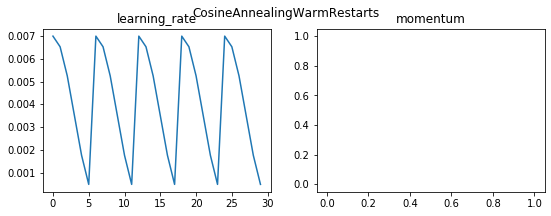

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': 6,
    'T_mult': 1, 
    'eta_min': 1e-5
    
}

CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [18]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 0)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, warmup=100, init_lr=0.01, weight_decay=0):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))

        defaults = dict(lr=lr, beta=beta, eps=eps, warmup=warmup,
                        init_lr=init_lr, base_lr=lr, weight_decay=weight_decay)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [21]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
    #
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam, LookaheadDiffGrad, LookaheadYogi, RangerLars
]

# train

In [22]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [23]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.031818741125506526
epoch21 save best model... 0.031526215408413175
fold0 score: 0.03152621556236923


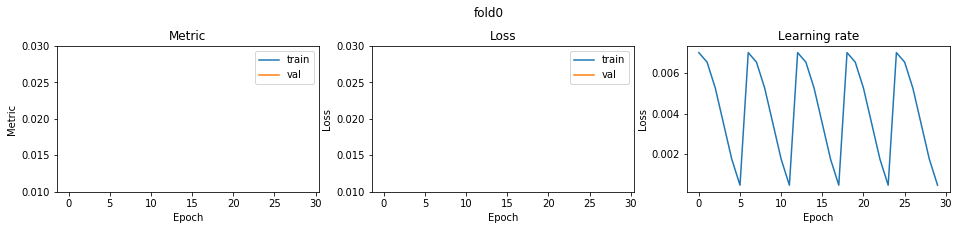

fold 1


epoch1 save best model... 0.032236802622787934
epoch2 save best model... 0.03199357323740658
epoch5 save best model... 0.031844932839739534
epoch15 save best model... 0.03181035783906601
fold1 score: 0.03181035729159901


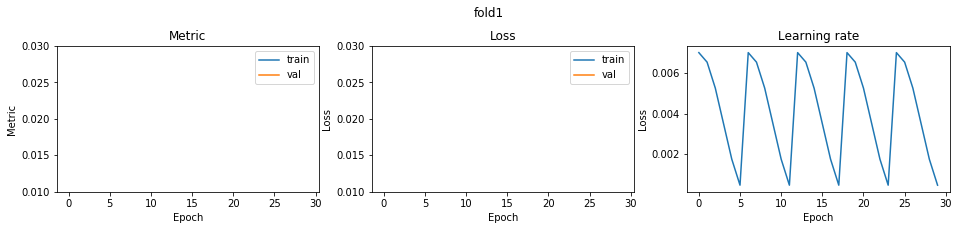

fold 2


epoch1 save best model... 0.032130808691502866
epoch2 save best model... 0.03203829477833341
epoch6 save best model... 0.03202744626403398
epoch14 save best model... 0.03178882919290962
fold2 score: 0.031788828353386485


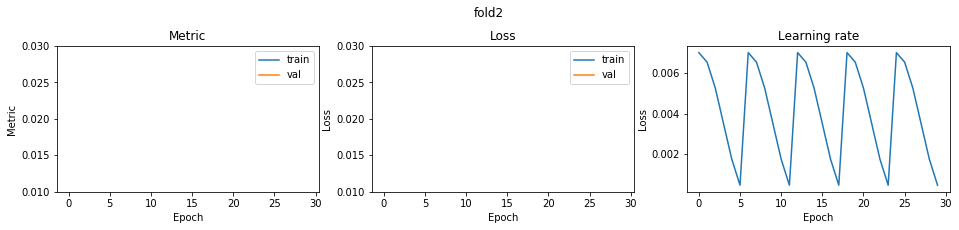

fold 3


epoch1 save best model... 0.03186764321915788
fold3 score: 0.03186764297516871


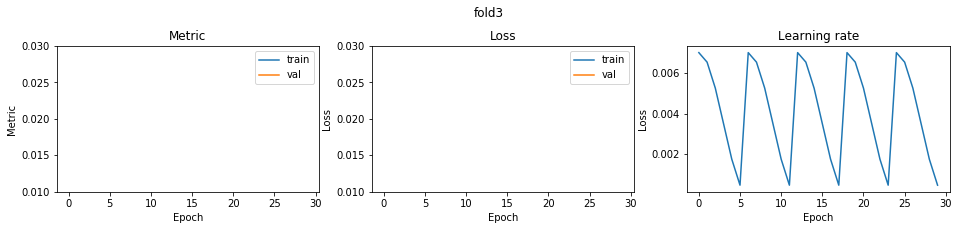

fold 4


epoch1 save best model... 0.031974516376208066
epoch2 save best model... 0.03184466594002785
fold4 score: 0.031844667641641546


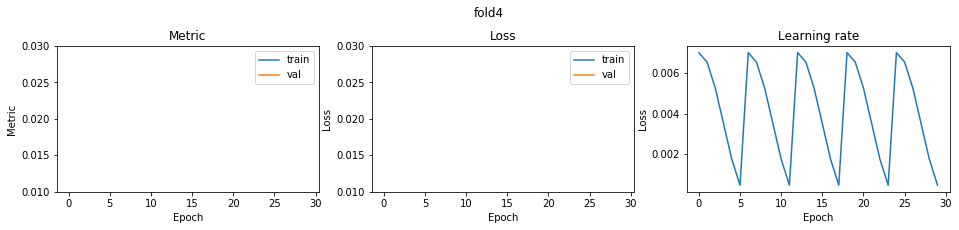

CV score: 0.031767539444251834

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.020075621694360345
epoch2 save best model... 0.019389790115805855
epoch3 save best model... 0.018141567651903712
epoch4 save best model... 0.017670732081479526
epoch5 save best model... 0.017299419241810984
epoch6 save best model... 0.017105227635838178
epoch9 save best model... 0.017062369273266924
epoch10 save best model... 0.01670566953141624
epoch11 save best model... 0.016528828147637547
epoch12 save best model... 0.016423499713182993
epoch16 save best model... 0.01640362803970627
epoch17 save best model... 0.016227206824546793
epoch18 save best model... 0.016174160070496702
epoch24 save best model... 0.01616483707074288
fold0 score: 0.01616483691963508


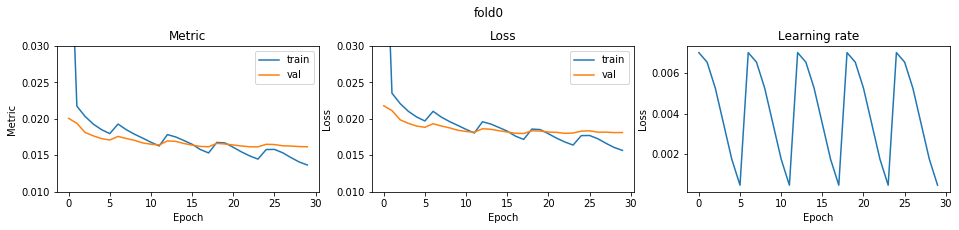

fold 1


epoch1 save best model... 0.020172999607342663
epoch2 save best model... 0.01901643826036552
epoch3 save best model... 0.018369798454941744
epoch4 save best model... 0.01777367218463126
epoch5 save best model... 0.01739866763317699
epoch6 save best model... 0.017288169306044047
epoch9 save best model... 0.01725357708958945
epoch10 save best model... 0.01700101781353833
epoch11 save best model... 0.016795505376778395
epoch12 save best model... 0.016628046467430053
epoch17 save best model... 0.016494979897306458
epoch18 save best model... 0.016463645435547156
fold1 score: 0.016463645378888808


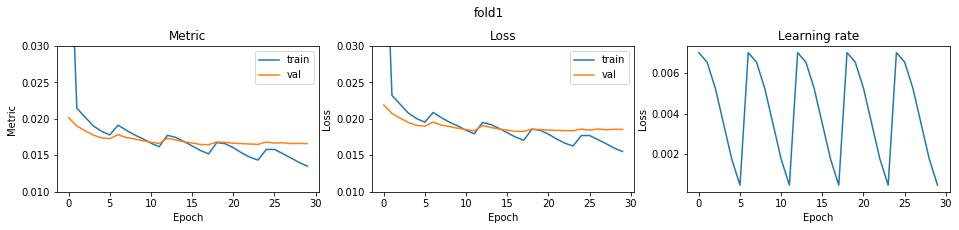

fold 2


epoch1 save best model... 0.020294935696928723
epoch2 save best model... 0.018979723282212698
epoch3 save best model... 0.01811836677265822
epoch4 save best model... 0.017548357842731555
epoch5 save best model... 0.01722023921695534
epoch6 save best model... 0.017066075294695525
epoch10 save best model... 0.016805265907272035
epoch11 save best model... 0.016528936480056333
epoch12 save best model... 0.01643420710177669
epoch17 save best model... 0.01634952378403892
epoch18 save best model... 0.01626204751605093
fold2 score: 0.01626204749777224


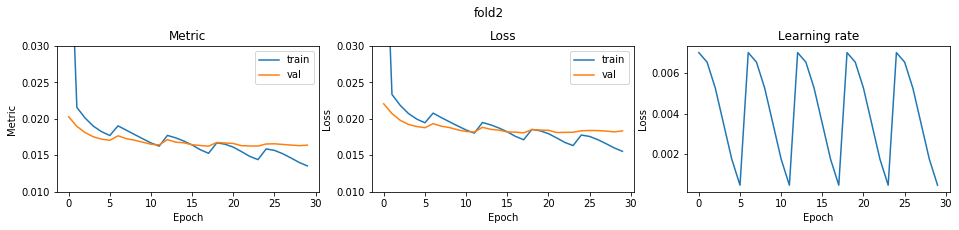

fold 3


epoch1 save best model... 0.020376752598682133
epoch2 save best model... 0.019479780394269963
epoch3 save best model... 0.0186773546107945
epoch4 save best model... 0.018134207018398615
epoch5 save best model... 0.01780605771979805
epoch6 save best model... 0.0175873365257453
epoch9 save best model... 0.017377397561857397
epoch10 save best model... 0.01706507024662845
epoch11 save best model... 0.01685739500503266
epoch12 save best model... 0.016766438218669494
epoch16 save best model... 0.016727721195981957
epoch17 save best model... 0.016601097932115096
epoch18 save best model... 0.016507936669577228
epoch23 save best model... 0.01642589013395589
epoch24 save best model... 0.016381816760316525
fold3 score: 0.016381816727246583


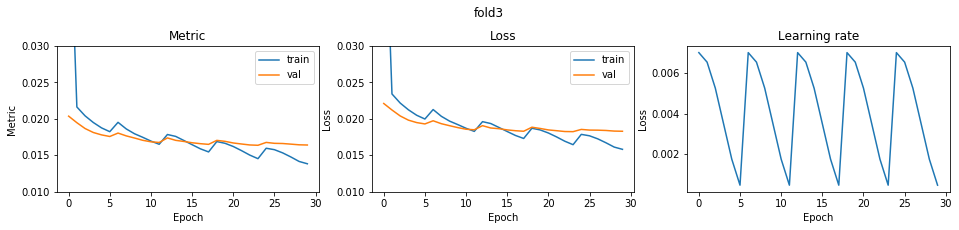

fold 4


epoch1 save best model... 0.020201584860546715
epoch2 save best model... 0.018884705345661872
epoch3 save best model... 0.018105774854812642
epoch4 save best model... 0.01766653433442116
epoch5 save best model... 0.01735208654279793
epoch6 save best model... 0.017199321151848943
epoch9 save best model... 0.01710679400457676
epoch10 save best model... 0.016880014710603516
epoch11 save best model... 0.016691930594181552
epoch12 save best model... 0.0165739441044408
epoch16 save best model... 0.01656175915423382
epoch17 save best model... 0.016459824573800207
epoch18 save best model... 0.016365199280236605
epoch23 save best model... 0.016338326426855117
fold4 score: 0.016338326191724886


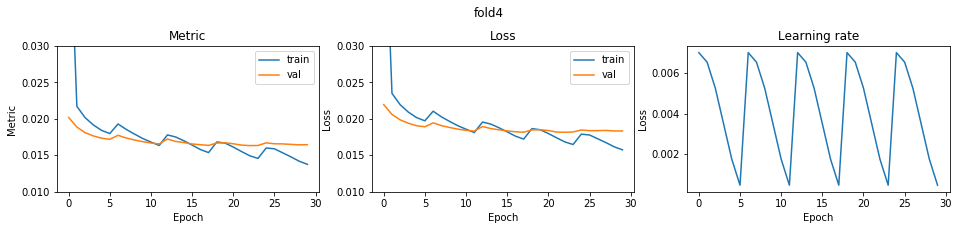

CV score: 0.01632213083320339

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.698643378163253
epoch2 save best model... 0.6778252654846817
epoch3 save best model... 0.6583045309659832
epoch4 save best model... 0.6449710520090438
epoch5 save best model... 0.6427281736784481
epoch6 save best model... 0.6423669483232607
epoch7 save best model... 0.5429548527765383
epoch8 save best model... 0.406410101999726
epoch9 save best model... 0.31152122801420085
epoch10 save best model... 0.2756475255130907
epoch11 save best model... 0.2700722015800128
epoch12 save best model... 0.2671162455527277
epoch13 save best model... 0.15643406748635894
epoch14 save best model... 0.09989382771601167
epoch15 save best model... 0.07668461687947732
epoch16 save best model... 0.0690170416833328
epoch17 save best model... 0.06533758316808518
epoch19 save best model... 0.042850411868312635
epoch20 save best model... 0.03320711042418024
epoch21 save best model... 0.029164378045461986
epoch22 save best model... 0.027952387664204034
epoch23 save best model... 0.0273

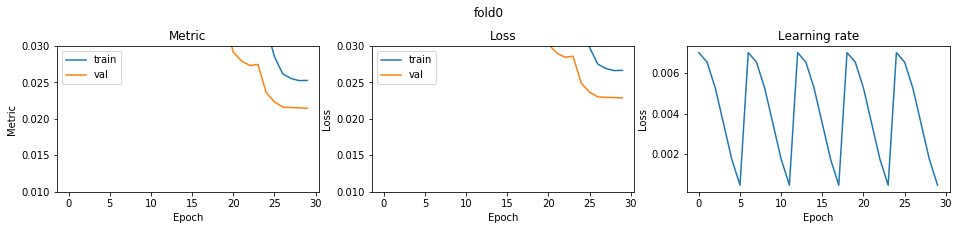

fold 1


epoch1 save best model... 0.6987565298046765
epoch2 save best model... 0.6781362143321199
epoch3 save best model... 0.6584768286732395
epoch4 save best model... 0.6465702428581992
epoch5 save best model... 0.6413740302495681
epoch6 save best model... 0.6385669697387584
epoch7 save best model... 0.5429235198797085
epoch8 save best model... 0.40550073372201406
epoch9 save best model... 0.31221279133205454
epoch10 save best model... 0.27811787136053545
epoch11 save best model... 0.2693355816810488
epoch12 save best model... 0.26760180133245726
epoch13 save best model... 0.15442553823943234
epoch14 save best model... 0.10081347821105936
epoch15 save best model... 0.0760423419116488
epoch16 save best model... 0.06773991709480418
epoch17 save best model... 0.06478420355055702
epoch19 save best model... 0.04212878485914514
epoch20 save best model... 0.032954483651393744
epoch21 save best model... 0.028648026461979746
epoch22 save best model... 0.02756572201275953
epoch23 save best model... 0.

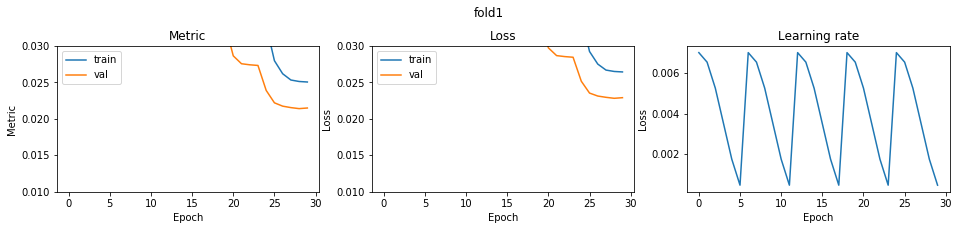

fold 2


epoch1 save best model... 0.7053184251655993
epoch2 save best model... 0.682563730539942
epoch3 save best model... 0.66349017364774
epoch4 save best model... 0.6498911734267231
epoch5 save best model... 0.6470157686738931
epoch6 save best model... 0.6468388553658714
epoch7 save best model... 0.5459688179963921
epoch8 save best model... 0.40759919749818596
epoch9 save best model... 0.31757358002429076
epoch10 save best model... 0.2783540451233304
epoch11 save best model... 0.2679300588596163
epoch13 save best model... 0.15640140146417697
epoch14 save best model... 0.09736707707789363
epoch15 save best model... 0.073895936131165
epoch16 save best model... 0.06603687338566666
epoch17 save best model... 0.06518724458544638
epoch19 save best model... 0.041991261135991324
epoch20 save best model... 0.03240596087626972
epoch21 save best model... 0.029207771624898717
epoch22 save best model... 0.027847724736049198
epoch23 save best model... 0.0273842697368549
epoch25 save best model... 0.02339

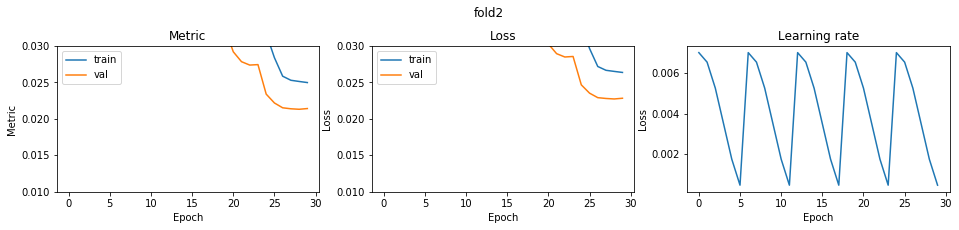

fold 3


epoch1 save best model... 0.6899540141937673
epoch2 save best model... 0.6722474177225847
epoch3 save best model... 0.6515876095767444
epoch4 save best model... 0.6395003241667172
epoch5 save best model... 0.6353896741714999
epoch7 save best model... 0.5374978440497622
epoch8 save best model... 0.40131460859998214
epoch9 save best model... 0.31043472222152224
epoch10 save best model... 0.27681611440990944
epoch11 save best model... 0.2623642968493333
epoch13 save best model... 0.15282686675192284
epoch14 save best model... 0.09941642586150311
epoch15 save best model... 0.07492579919262736
epoch16 save best model... 0.06845972633714828
epoch17 save best model... 0.06605753899978342
epoch18 save best model... 0.06417675787298717
epoch19 save best model... 0.04312000872571539
epoch20 save best model... 0.032557539924436114
epoch21 save best model... 0.029477315933225095
epoch22 save best model... 0.02782171806723626
epoch23 save best model... 0.027733192193175504
epoch25 save best model..

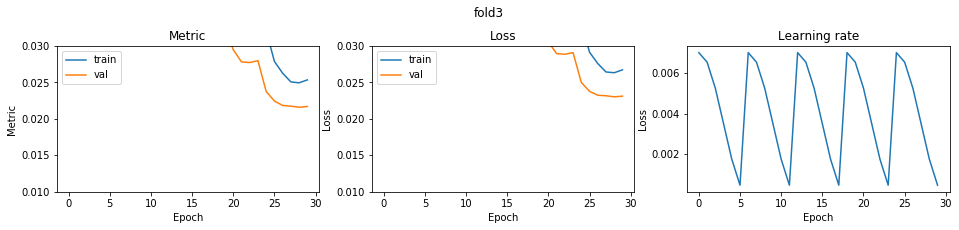

fold 4


epoch1 save best model... 0.6979989603874623
epoch2 save best model... 0.6794053652563508
epoch3 save best model... 0.6604229238961986
epoch4 save best model... 0.6465764338986477
epoch5 save best model... 0.6430311998365137
epoch6 save best model... 0.6419749850021136
epoch7 save best model... 0.5450372574541184
epoch8 save best model... 0.407372086941517
epoch9 save best model... 0.3121261358939977
epoch10 save best model... 0.2759581258872647
epoch11 save best model... 0.27021549944182466
epoch12 save best model... 0.26663889489847326
epoch13 save best model... 0.15276896328344974
epoch14 save best model... 0.09735252800522741
epoch15 save best model... 0.0739149747649738
epoch16 save best model... 0.06695238485049822
epoch17 save best model... 0.06382039385361932
epoch19 save best model... 0.042379476961622475
epoch20 save best model... 0.03191980908885768
epoch21 save best model... 0.02880346596257969
epoch22 save best model... 0.027298375926826973
epoch23 save best model... 0.026

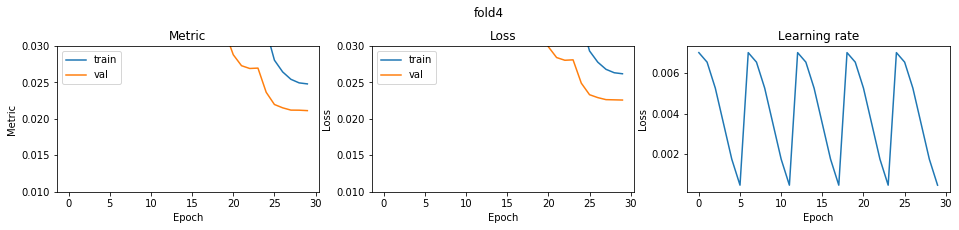

CV score: 0.021382929175292387

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.020177580875287295
epoch2 save best model... 0.01886140035978754
epoch3 save best model... 0.018009963439001037
epoch4 save best model... 0.017548386032156357
epoch5 save best model... 0.01729040840356388
epoch6 save best model... 0.01698768971772156
epoch10 save best model... 0.016784168773909907
epoch11 save best model... 0.016536504855901343
epoch12 save best model... 0.016433804343902167
epoch17 save best model... 0.0162306882665919
epoch18 save best model... 0.016176776554019685
fold0 score: 0.01617677638131141


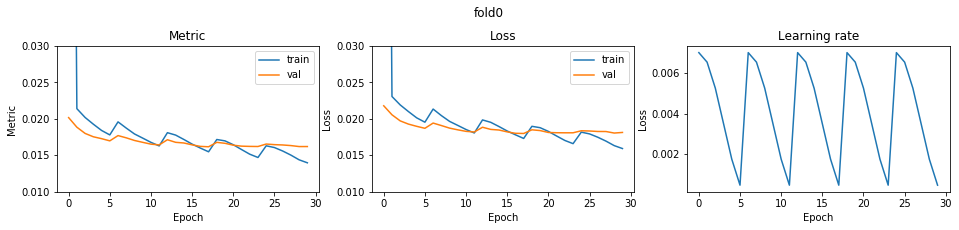

fold 1


epoch1 save best model... 0.020392500042769355
epoch2 save best model... 0.01907374576925824
epoch3 save best model... 0.018490113862882473
epoch4 save best model... 0.017719396546408347
epoch5 save best model... 0.017513316476072096
epoch6 save best model... 0.01722731121312203
epoch10 save best model... 0.016976065123969368
epoch11 save best model... 0.01672257095304572
epoch12 save best model... 0.01666640650882458
epoch17 save best model... 0.016594856515302694
epoch18 save best model... 0.016498322032288473
epoch23 save best model... 0.0164959048831105
epoch24 save best model... 0.016447412467157006
fold1 score: 0.01644741239123672


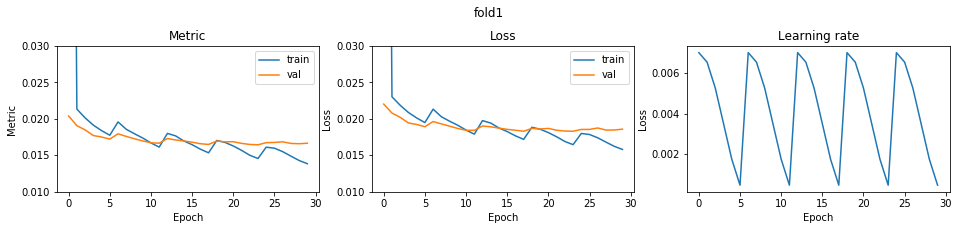

fold 2


epoch1 save best model... 0.02042323971406138
epoch2 save best model... 0.0188686938094445
epoch3 save best model... 0.018127391433547423
epoch4 save best model... 0.017646068801747336
epoch5 save best model... 0.01726400428874926
epoch6 save best model... 0.016969020643090502
epoch10 save best model... 0.016790834271006742
epoch11 save best model... 0.016508020283210845
epoch12 save best model... 0.016405944688269843
epoch17 save best model... 0.016324694809501942
epoch18 save best model... 0.016245430780162596
epoch23 save best model... 0.016228304826840165
epoch24 save best model... 0.01616665428832401
fold2 score: 0.01616665423668362


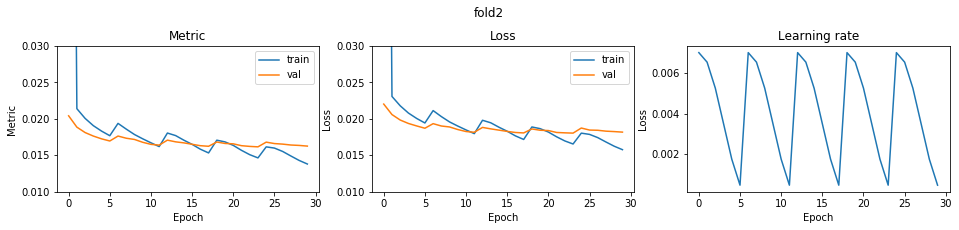

fold 3


epoch1 save best model... 0.020493153701186317
epoch2 save best model... 0.019064631966920674
epoch3 save best model... 0.01830839962912787
epoch4 save best model... 0.017872546571211418
epoch5 save best model... 0.01743053727844785
epoch6 save best model... 0.017243414769343744
epoch9 save best model... 0.017240328674792294
epoch10 save best model... 0.017053458948273866
epoch11 save best model... 0.016781104371749324
epoch12 save best model... 0.016631387560235883
epoch17 save best model... 0.016492488388404895
epoch18 save best model... 0.016414989873444436
epoch24 save best model... 0.016414937524205597
fold3 score: 0.016414937426340665


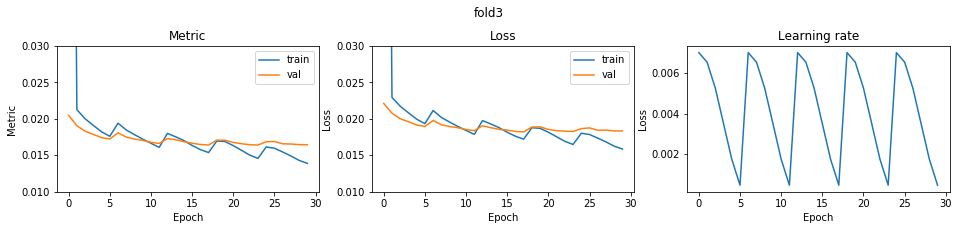

fold 4


epoch1 save best model... 0.020376052725253994
epoch2 save best model... 0.018653351065102363
epoch3 save best model... 0.018195667341436367
epoch4 save best model... 0.017747180052695623
epoch5 save best model... 0.017301191499876814
epoch6 save best model... 0.017149001544931212
epoch10 save best model... 0.016873218180666887
epoch11 save best model... 0.016713638428878675
epoch12 save best model... 0.01658412271385041
epoch17 save best model... 0.0165230050305401
epoch18 save best model... 0.016466865711049907
epoch23 save best model... 0.016457410073565458
epoch24 save best model... 0.016433450297912867
epoch30 save best model... 0.016419854922674105
fold4 score: 0.016419088860375783


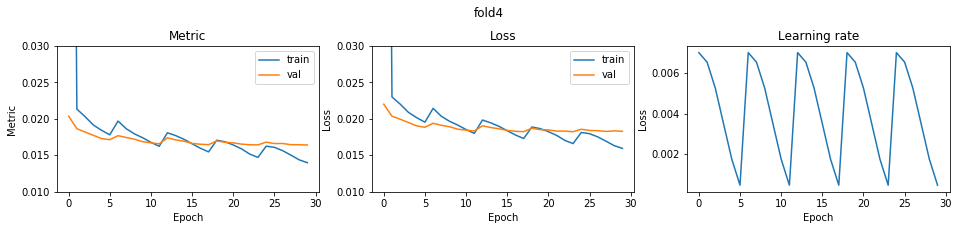

CV score: 0.016324975494012423

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02089450257853658
epoch2 save best model... 0.019280314475196098
epoch3 save best model... 0.01865511382070788
epoch4 save best model... 0.018182709001870252
epoch5 save best model... 0.017736094618950184
epoch6 save best model... 0.017567430175246843
epoch8 save best model... 0.017444109257336086
epoch9 save best model... 0.017067009237741283
epoch10 save best model... 0.016817993841267663
epoch11 save best model... 0.01662878445636031
epoch12 save best model... 0.016528206095438883
epoch16 save best model... 0.01634763167886772
epoch17 save best model... 0.016208164757945
epoch18 save best model... 0.01617380468289374
epoch23 save best model... 0.01616491493864456
epoch24 save best model... 0.01615455490208161
fold0 score: 0.016154554817994084


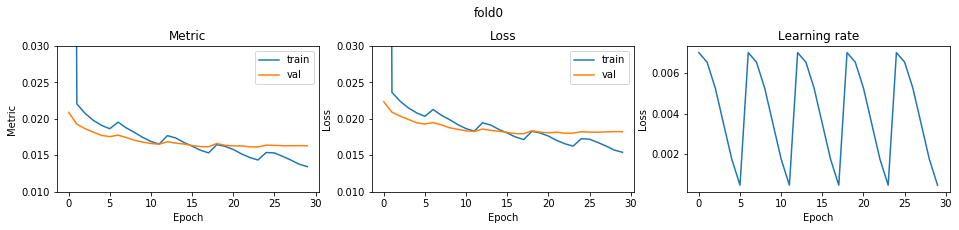

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021185859612565455
epoch2 save best model... 0.01954185898721517
epoch3 save best model... 0.01865880633794547
epoch4 save best model... 0.018181638862181427
epoch5 save best model... 0.01788250578868278
epoch6 save best model... 0.017685609028731317
epoch8 save best model... 0.017560962852838372
epoch9 save best model... 0.017164416113810213
epoch10 save best model... 0.017155442453919145
epoch11 save best model... 0.016861599995857575
epoch12 save best model... 0.016757049774770164
epoch16 save best model... 0.016603379805505913
epoch17 save best model... 0.016551621356717165
epoch18 save best model... 0.016491910709226475
epoch24 save best model... 0.016491414934963727
fold1 score: 0.01649141495372491


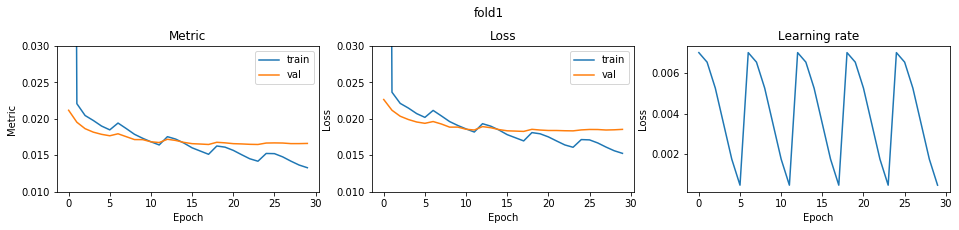

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021253576462735724
epoch2 save best model... 0.019510828602382575
epoch3 save best model... 0.01878908082696837
epoch4 save best model... 0.018051135114176206
epoch5 save best model... 0.0176828918661553
epoch6 save best model... 0.01752615712352197
epoch8 save best model... 0.017396532284300863
epoch9 save best model... 0.01701884841986508
epoch10 save best model... 0.016779965443307895
epoch11 save best model... 0.01662779760696155
epoch12 save best model... 0.016584176519674736
epoch16 save best model... 0.016416712152041914
epoch17 save best model... 0.01630164737547719
epoch18 save best model... 0.016250183128285623
fold2 score: 0.016250183089129237


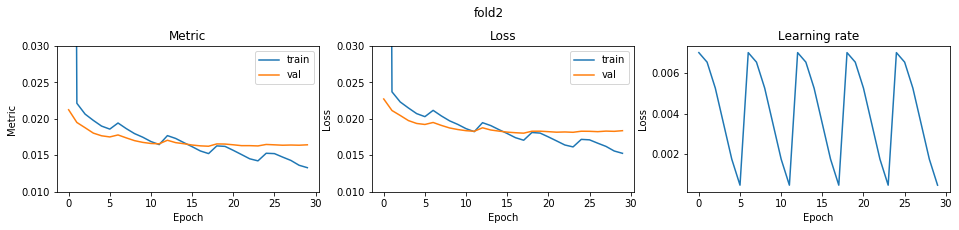

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02126112760623794
epoch2 save best model... 0.01959453095429511
epoch3 save best model... 0.018867822332575
epoch4 save best model... 0.018264711880313915
epoch5 save best model... 0.01789878097772259
epoch6 save best model... 0.01776530302017248
epoch8 save best model... 0.017571508787266894
epoch9 save best model... 0.017312722611145578
epoch10 save best model... 0.01701732222330258
epoch11 save best model... 0.01687689450291539
epoch12 save best model... 0.016742385356583057
epoch16 save best model... 0.016596962571364737
epoch17 save best model... 0.0165242697390174
epoch18 save best model... 0.016447228887850305
epoch24 save best model... 0.01643129530784956
fold3 score: 0.01643129534584659


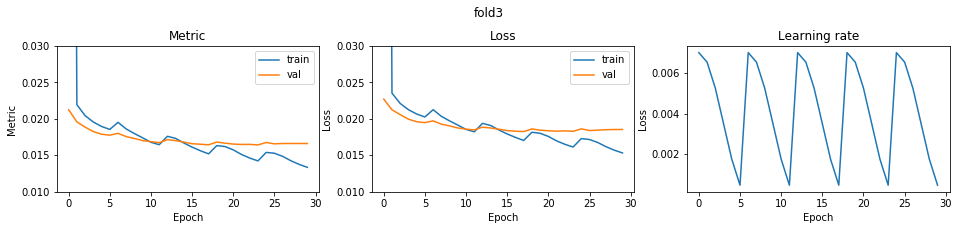

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.020898884868329914
epoch2 save best model... 0.019339383719382906
epoch3 save best model... 0.018382663998523716
epoch4 save best model... 0.01794145959588553
epoch5 save best model... 0.01757630042621446
epoch6 save best model... 0.01749123981591645
epoch8 save best model... 0.01742821640137727
epoch9 save best model... 0.0171361567155545
epoch10 save best model... 0.016869081500790386
epoch11 save best model... 0.016763462521695874
epoch12 save best model... 0.016711273668906682
epoch15 save best model... 0.016663242986845808
epoch16 save best model... 0.016569789033595277
epoch17 save best model... 0.016424946891300907
epoch18 save best model... 0.016372180010503952
fold4 score: 0.016372179900362466


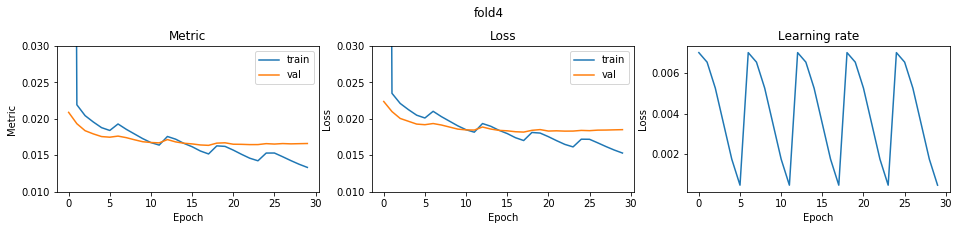

CV score: 0.016339922808089054

optimizer: AggMo
fold 0


epoch1 save best model... 0.27544877525071076
epoch2 save best model... 0.03358060140035419
epoch3 save best model... 0.03067602294588415
epoch4 save best model... 0.030539279069607243
epoch5 save best model... 0.030292687676252972
epoch6 save best model... 0.030254723714634876
epoch7 save best model... 0.03025421074216078
fold0 score: 0.030254210771331468


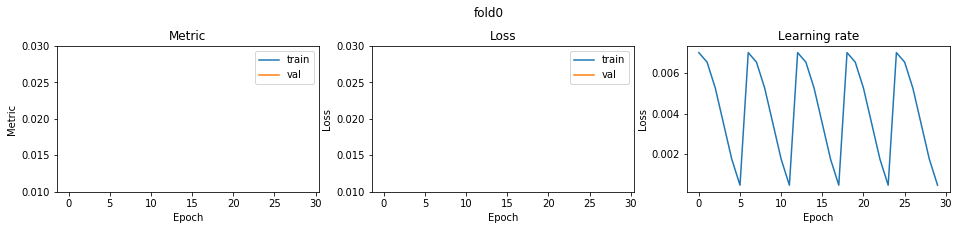

fold 1


epoch1 save best model... 0.2719704919182975
epoch2 save best model... 0.033517348070158506
epoch3 save best model... 0.030716938137885893
epoch4 save best model... 0.03045330032719841
epoch5 save best model... 0.030351979337593614
epoch6 save best model... 0.030294820328499197
fold1 score: 0.0302948201098577


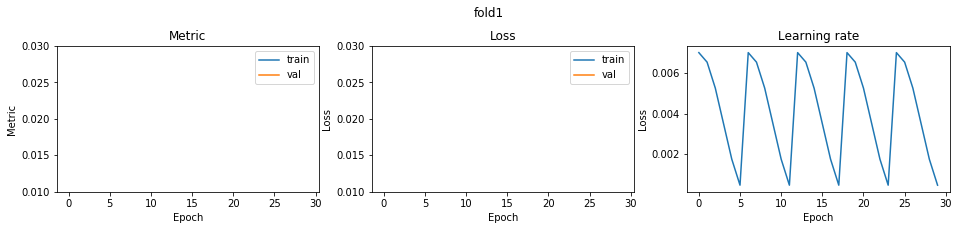

fold 2


epoch1 save best model... 0.2539221891294337
epoch2 save best model... 0.03264605816844982
epoch3 save best model... 0.030299023076413186
epoch4 save best model... 0.029987384607401326
fold2 score: 0.029987384458359256


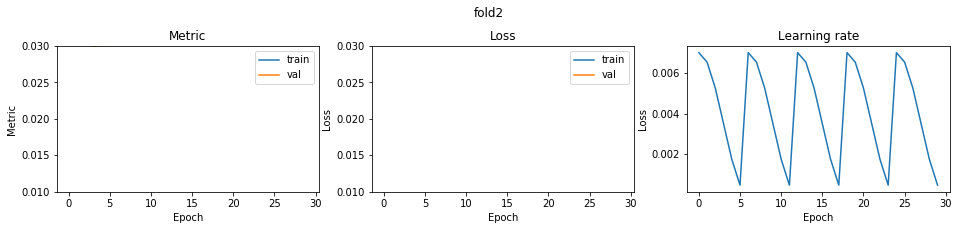

fold 3


epoch1 save best model... 0.2958872773109645
epoch2 save best model... 0.03398441985283463
epoch3 save best model... 0.031025714486633726
epoch4 save best model... 0.030520348764260158
epoch7 save best model... 0.030500960851550647
epoch8 save best model... 0.030500917439614177
fold3 score: 0.03050091744915411


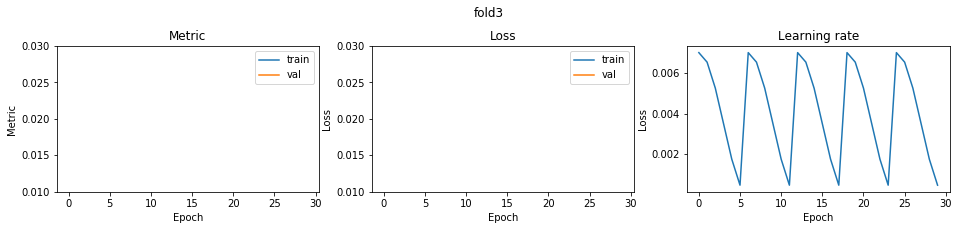

fold 4


epoch1 save best model... 0.26753783588528907
epoch2 save best model... 0.03299860162045255
epoch3 save best model... 0.0301999991051089
epoch4 save best model... 0.03015663228029542
epoch6 save best model... 0.030079319631014706
epoch7 save best model... 0.030040820028658335
fold4 score: 0.03004082006622201


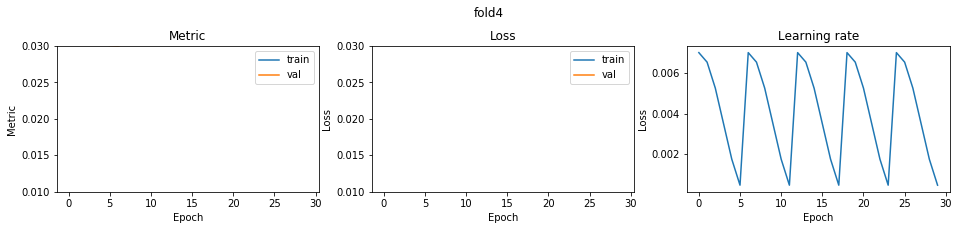

CV score: 0.030215637362335998

optimizer: Apollo
fold 0


epoch1 save best model... 0.7042104169285107
epoch2 save best model... 0.6960318375285502
epoch3 save best model... 0.6897113142904225
epoch4 save best model... 0.6841736498889185
epoch6 save best model... 0.6820365760483883
epoch7 save best model... 0.6733303839633568
epoch8 save best model... 0.668351737676286
epoch9 save best model... 0.659596113382005
epoch10 save best model... 0.6553538864457255
epoch11 save best model... 0.6543647499725325
epoch12 save best model... 0.6542680462563499
epoch13 save best model... 0.6440874632507358
epoch14 save best model... 0.635427505578973
epoch15 save best model... 0.6291993141174317
epoch16 save best model... 0.6217607481061462
epoch17 save best model... 0.6185602660602753
epoch19 save best model... 0.6060433446682124
epoch20 save best model... 0.5908378438145805
epoch21 save best model... 0.580623331401234
epoch22 save best model... 0.570300326559158
epoch23 save best model... 0.5660711623813134
epoch24 save best model... 0.5649411158029474
e

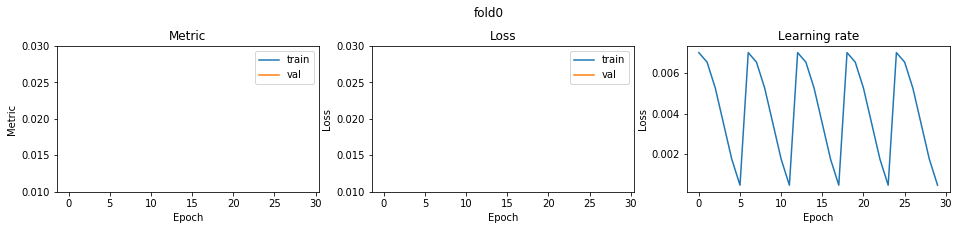

fold 1


epoch1 save best model... 0.7036611590034518
epoch2 save best model... 0.6968963518314357
epoch3 save best model... 0.6924956242107644
epoch4 save best model... 0.6883937050362442
epoch5 save best model... 0.6849155538200001
epoch7 save best model... 0.6762541355970482
epoch8 save best model... 0.6692684018875369
epoch9 save best model... 0.6637526514807767
epoch10 save best model... 0.6591812197019691
epoch11 save best model... 0.6571324757330237
epoch12 save best model... 0.6562063833878996
epoch13 save best model... 0.6472143996791271
epoch14 save best model... 0.638693827720676
epoch15 save best model... 0.6316697078865844
epoch16 save best model... 0.6247860036805649
epoch17 save best model... 0.6213552361605895
epoch18 save best model... 0.620466170372901
epoch19 save best model... 0.6095094108233883
epoch20 save best model... 0.5949668108289783
epoch21 save best model... 0.5829202583559175
epoch22 save best model... 0.5751483838578296
epoch23 save best model... 0.567671197290218

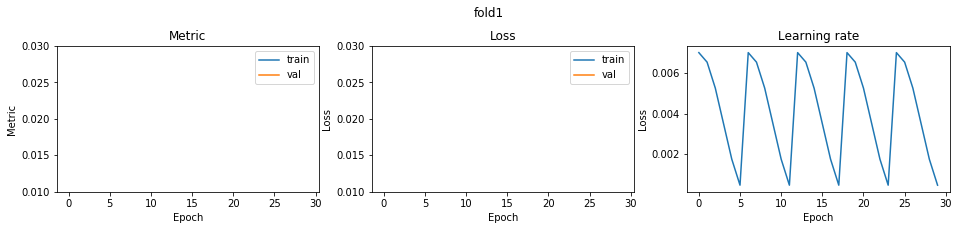

fold 2


epoch1 save best model... 0.7005595368061339
epoch2 save best model... 0.6931425106500976
epoch3 save best model... 0.6856938531551418
epoch4 save best model... 0.6837258755576776
epoch5 save best model... 0.6792831987882698
epoch6 save best model... 0.677462092943033
epoch7 save best model... 0.6721796994601493
epoch8 save best model... 0.6663355011417427
epoch9 save best model... 0.6567968683651298
epoch10 save best model... 0.6538010256440907
epoch11 save best model... 0.6519316899855225
epoch13 save best model... 0.6427188876903418
epoch14 save best model... 0.632188912322348
epoch15 save best model... 0.6239777808853205
epoch16 save best model... 0.6184414306841833
epoch17 save best model... 0.6146542095708858
epoch18 save best model... 0.6137647092220152
epoch19 save best model... 0.6007629679530812
epoch20 save best model... 0.586981986127972
epoch21 save best model... 0.574204045538208
epoch22 save best model... 0.5670316916958132
epoch23 save best model... 0.5616122488417097
e

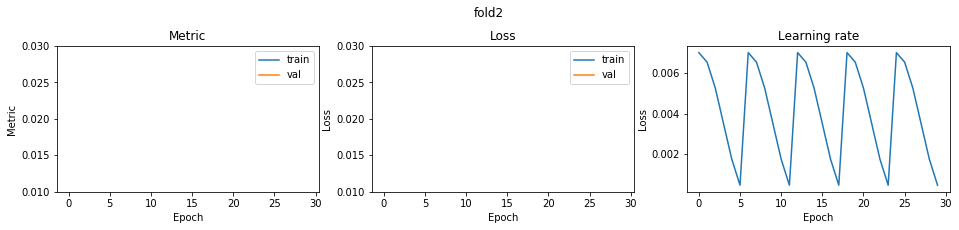

fold 3


epoch1 save best model... 0.7065570272997463
epoch2 save best model... 0.6977129862085834
epoch3 save best model... 0.6910662538098311
epoch4 save best model... 0.6870885280650406
epoch6 save best model... 0.6855021345045138
epoch7 save best model... 0.6791169421004815
epoch8 save best model... 0.6707817618287506
epoch9 save best model... 0.663460586527214
epoch10 save best model... 0.660003524869341
epoch11 save best model... 0.657317906903243
epoch13 save best model... 0.6493122553499522
epoch14 save best model... 0.6398125755216646
epoch15 save best model... 0.6338751740227527
epoch16 save best model... 0.6288854555551446
epoch17 save best model... 0.625431941120391
epoch18 save best model... 0.6244309872592501
epoch19 save best model... 0.612661069943856
epoch20 save best model... 0.6015921756455458
epoch21 save best model... 0.5916469100667566
epoch22 save best model... 0.5838497694912695
epoch23 save best model... 0.5780926769578104
epoch25 save best model... 0.5602457847030397
e

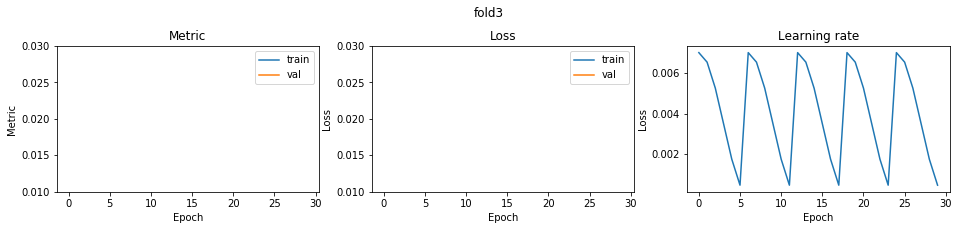

fold 4


epoch1 save best model... 0.7056871978731525
epoch2 save best model... 0.6994059467098436
epoch3 save best model... 0.6944962965600311
epoch4 save best model... 0.6896062534056383
epoch5 save best model... 0.6871013664982042
epoch6 save best model... 0.6865046144889536
epoch7 save best model... 0.6793145664460567
epoch8 save best model... 0.6724820244285131
epoch9 save best model... 0.6659270009853302
epoch10 save best model... 0.6621360661771684
epoch11 save best model... 0.6583398944153058
epoch13 save best model... 0.6495809889056959
epoch14 save best model... 0.6406324809395914
epoch15 save best model... 0.6314453397361999
epoch16 save best model... 0.6265212872848424
epoch17 save best model... 0.6254585046159923
epoch18 save best model... 0.6245872205102091
epoch19 save best model... 0.6101220552633455
epoch20 save best model... 0.5970904332901731
epoch21 save best model... 0.5859716680978588
epoch22 save best model... 0.5776538316372587
epoch23 save best model... 0.57438077182595

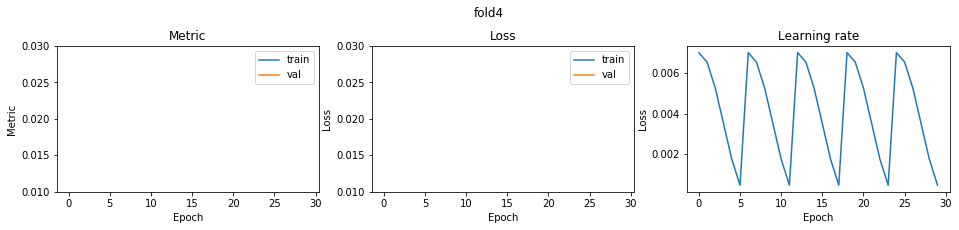

CV score: 0.4904410997652461

optimizer: PID
fold 0


epoch1 save best model... 0.7019045250562438
epoch2 save best model... 0.6932277599336889
epoch3 save best model... 0.687953889125572
epoch4 save best model... 0.6844405831128427
epoch5 save best model... 0.6830946550553915
epoch7 save best model... 0.6769703758604706
epoch8 save best model... 0.6665656441708089
epoch9 save best model... 0.6613312821724964
epoch10 save best model... 0.6564931588998416
epoch12 save best model... 0.6554298434550778
epoch13 save best model... 0.6454517023438473
epoch14 save best model... 0.6383844954549316
epoch15 save best model... 0.6293652835359335
epoch16 save best model... 0.6242194473336118
epoch17 save best model... 0.6205322873076436
epoch19 save best model... 0.606504057778856
epoch20 save best model... 0.5957151542763504
epoch21 save best model... 0.5839416774367417
epoch22 save best model... 0.5757710722149912
epoch23 save best model... 0.5713593976372738
epoch24 save best model... 0.5702501581578701
epoch25 save best model... 0.551207192965140

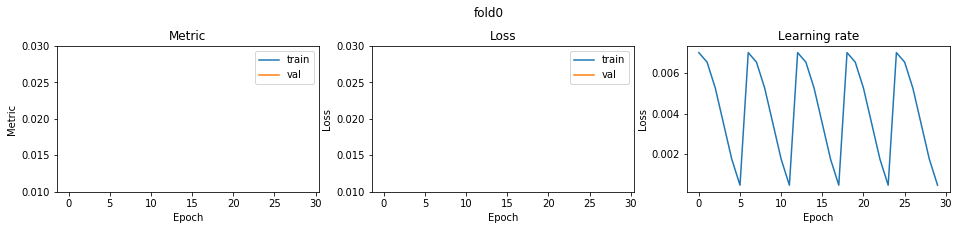

fold 1


epoch1 save best model... 0.7035828147344096
epoch2 save best model... 0.6943153295030244
epoch3 save best model... 0.6911380807450052
epoch4 save best model... 0.6860070136501132
epoch5 save best model... 0.685074418464047
epoch7 save best model... 0.6770066129207937
epoch8 save best model... 0.6688983327002318
epoch9 save best model... 0.6634553210641344
epoch10 save best model... 0.6585292790223428
epoch11 save best model... 0.6573671890597975
epoch13 save best model... 0.6473347878206235
epoch14 save best model... 0.6390566936411655
epoch15 save best model... 0.6325456980122713
epoch16 save best model... 0.6269493459378649
epoch17 save best model... 0.6248096184324202
epoch18 save best model... 0.623950798138314
epoch19 save best model... 0.6126535577365547
epoch20 save best model... 0.5997691048009164
epoch21 save best model... 0.5887437514140845
epoch22 save best model... 0.5819912238989096
epoch23 save best model... 0.5759411370137689
epoch25 save best model... 0.558282917535612

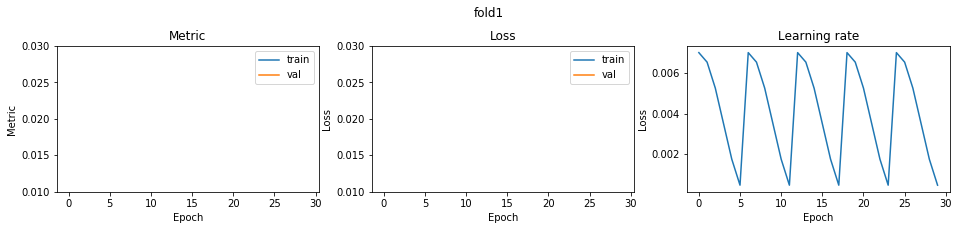

fold 2


epoch1 save best model... 0.7053740136062238
epoch2 save best model... 0.6982479746234691
epoch3 save best model... 0.6919785175896038
epoch4 save best model... 0.6889656912115284
epoch5 save best model... 0.6866687553894224
epoch6 save best model... 0.685590892955474
epoch7 save best model... 0.6763795227063601
epoch8 save best model... 0.6694697225031372
epoch9 save best model... 0.6624227978830648
epoch10 save best model... 0.6599579652422082
epoch11 save best model... 0.6567577849381822
epoch12 save best model... 0.6560635747738975
epoch13 save best model... 0.6467328926891693
epoch14 save best model... 0.6369566935753056
epoch15 save best model... 0.6293453201396939
epoch16 save best model... 0.6243585247633858
epoch17 save best model... 0.6208045778689555
epoch18 save best model... 0.6196590519543524
epoch19 save best model... 0.6081160294029103
epoch20 save best model... 0.596181460531243
epoch21 save best model... 0.5826976238445422
epoch22 save best model... 0.5716138289387065

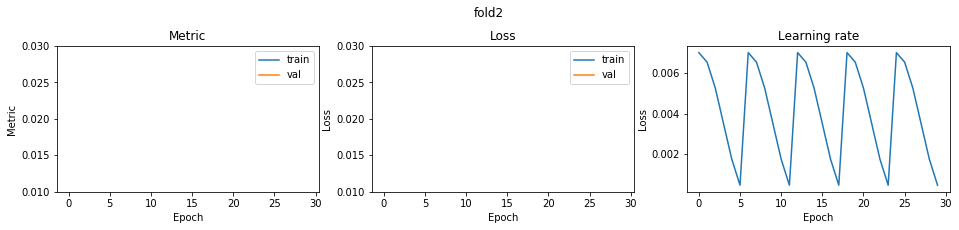

fold 3


epoch1 save best model... 0.704989501528425
epoch2 save best model... 0.6977738620208445
epoch3 save best model... 0.691960391694158
epoch4 save best model... 0.6858577592226258
epoch5 save best model... 0.6840226324652756
epoch6 save best model... 0.6832418332881971
epoch7 save best model... 0.6760890102332165
epoch8 save best model... 0.6703342485264928
epoch9 save best model... 0.6633810312438392
epoch10 save best model... 0.6597968405906052
epoch11 save best model... 0.6564856109695174
epoch12 save best model... 0.6560413123534861
epoch13 save best model... 0.6484815618714873
epoch14 save best model... 0.6405690139952988
epoch15 save best model... 0.6307661733214567
epoch16 save best model... 0.6270109737924129
epoch17 save best model... 0.6235464795846873
epoch18 save best model... 0.623436243849083
epoch19 save best model... 0.6111624190095889
epoch20 save best model... 0.5981244051374988
epoch21 save best model... 0.5855663332417776
epoch22 save best model... 0.576651490522137
e

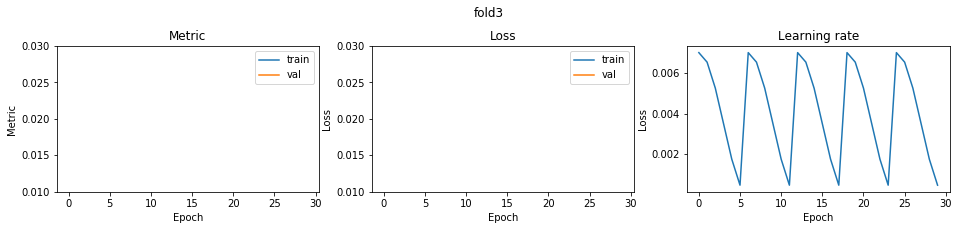

fold 4


epoch1 save best model... 0.710611275279712
epoch2 save best model... 0.699529972380549
epoch3 save best model... 0.6931606333185165
epoch4 save best model... 0.6888639495693198
epoch6 save best model... 0.687110265539556
epoch7 save best model... 0.6797554231450335
epoch8 save best model... 0.6714136677342286
epoch9 save best model... 0.665171461387756
epoch10 save best model... 0.6593190686577817
epoch11 save best model... 0.6571494341168154
epoch12 save best model... 0.6563484992687686
epoch13 save best model... 0.6466727218486725
epoch14 save best model... 0.6372747667829648
epoch15 save best model... 0.6275767972094595
epoch16 save best model... 0.622699903871584
epoch17 save best model... 0.6216431622353121
epoch18 save best model... 0.6201111634119768
epoch19 save best model... 0.6059326457271271
epoch20 save best model... 0.5912618492893315
epoch21 save best model... 0.5786056004515542
epoch22 save best model... 0.5660671389999042
epoch23 save best model... 0.5625837531611154
e

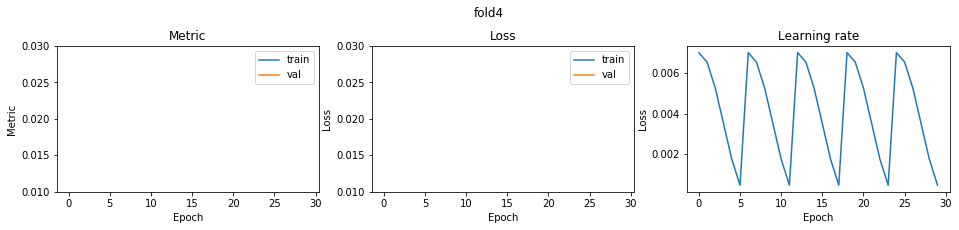

CV score: 0.4908990070684194

optimizer: QHM
fold 0


epoch1 save best model... 0.7020350388079406
epoch2 save best model... 0.6944495960085701
epoch3 save best model... 0.6891874735067537
epoch4 save best model... 0.6879048063163062
epoch5 save best model... 0.6826734623496244
epoch7 save best model... 0.6749078314505297
epoch8 save best model... 0.665878722363561
epoch9 save best model... 0.6596637295699065
epoch10 save best model... 0.6557721236300631
epoch11 save best model... 0.6526280672240637
epoch13 save best model... 0.643263941962518
epoch14 save best model... 0.6333530581622026
epoch15 save best model... 0.6258177767038888
epoch16 save best model... 0.6195248999736847
epoch17 save best model... 0.6171765160451989
epoch18 save best model... 0.6153338930058316
epoch19 save best model... 0.6016358342148992
epoch20 save best model... 0.5883461315974016
epoch21 save best model... 0.577961255966395
epoch22 save best model... 0.5666349695320825
epoch23 save best model... 0.563301535782347
epoch24 save best model... 0.5622293958631355


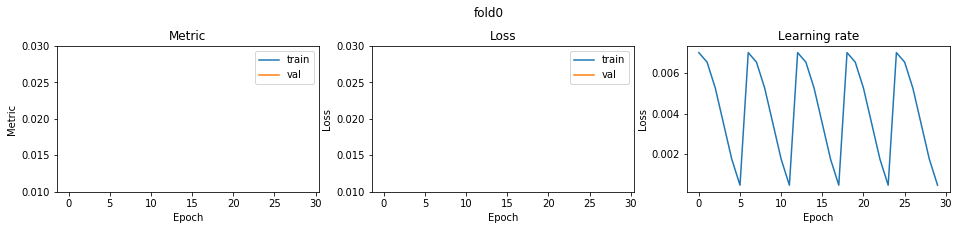

fold 1


epoch1 save best model... 0.7012455336975328
epoch2 save best model... 0.6963004723826148
epoch3 save best model... 0.6887448887315474
epoch4 save best model... 0.6859392377775605
epoch5 save best model... 0.6830020835633754
epoch7 save best model... 0.6749351391571751
epoch8 save best model... 0.6671787339588807
epoch9 save best model... 0.6615249859930905
epoch10 save best model... 0.6581490656514188
epoch11 save best model... 0.6569180118926269
epoch12 save best model... 0.6542808457098835
epoch13 save best model... 0.6445398850005318
epoch14 save best model... 0.6357171226400643
epoch15 save best model... 0.6275995865474396
epoch16 save best model... 0.6219364694349585
epoch17 save best model... 0.6213821339618103
epoch18 save best model... 0.618867068824151
epoch19 save best model... 0.6055449551834172
epoch20 save best model... 0.5924443671550694
epoch21 save best model... 0.5820285285977738
epoch22 save best model... 0.5720718958894438
epoch23 save best model... 0.56686131852068

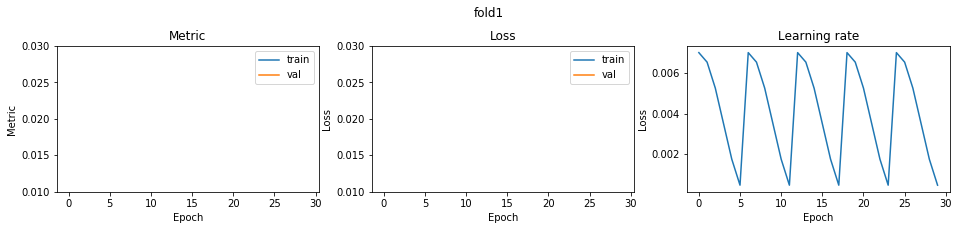

fold 2


epoch1 save best model... 0.7066734108601107
epoch2 save best model... 0.6980504056917939
epoch3 save best model... 0.6922882951780777
epoch4 save best model... 0.6895894441633948
epoch5 save best model... 0.6878676426983771
epoch7 save best model... 0.680989503222192
epoch8 save best model... 0.6713606125131287
epoch9 save best model... 0.6642936273108965
epoch10 save best model... 0.6617187085986056
epoch11 save best model... 0.660250562718692
epoch12 save best model... 0.6601640164213861
epoch13 save best model... 0.6507802994709184
epoch14 save best model... 0.6425058210349675
epoch15 save best model... 0.6357751987088539
epoch16 save best model... 0.6291375838968742
epoch17 save best model... 0.6268630504716798
epoch18 save best model... 0.6267936945531927
epoch19 save best model... 0.6156231852646813
epoch20 save best model... 0.6054089741735096
epoch21 save best model... 0.5920463185507009
epoch22 save best model... 0.5854622550558245
epoch23 save best model... 0.580288892157340

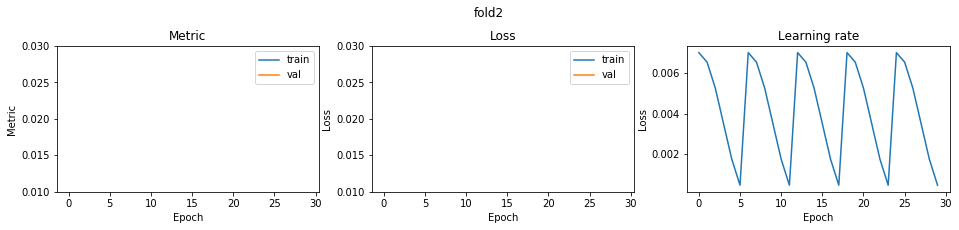

fold 3


epoch1 save best model... 0.7032699420946334
epoch2 save best model... 0.6967963000636438
epoch3 save best model... 0.6900792866741606
epoch4 save best model... 0.6889429688453674
epoch5 save best model... 0.684765985153259
epoch6 save best model... 0.6845209265895748
epoch7 save best model... 0.6772096147026723
epoch8 save best model... 0.6699470909146893
epoch9 save best model... 0.6625664591789245
epoch10 save best model... 0.6602171404486636
epoch11 save best model... 0.6580290924443742
epoch12 save best model... 0.6568396050457531
epoch13 save best model... 0.6485355642499033
epoch14 save best model... 0.641513733820383
epoch15 save best model... 0.6327734699281853
epoch16 save best model... 0.6286917831740239
epoch17 save best model... 0.6253471433709042
epoch18 save best model... 0.6236742117410369
epoch19 save best model... 0.6158831123067469
epoch20 save best model... 0.6023627983410429
epoch21 save best model... 0.5912061504731145
epoch22 save best model... 0.5837775384375066

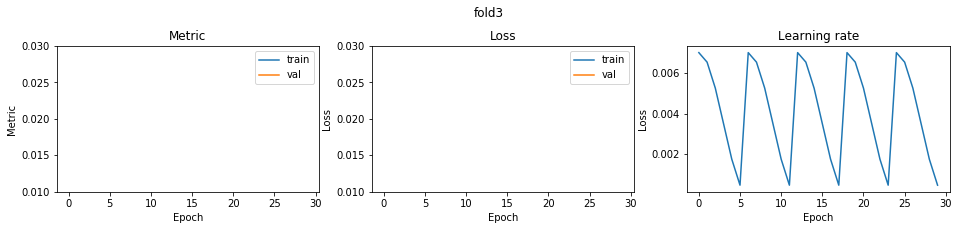

fold 4


epoch1 save best model... 0.7052615848923598
epoch2 save best model... 0.6997024585825978
epoch3 save best model... 0.6943236711899621
epoch4 save best model... 0.6900881158192228
epoch5 save best model... 0.6872201048703291
epoch6 save best model... 0.6867721942128244
epoch7 save best model... 0.6798727828440743
epoch8 save best model... 0.669441706091505
epoch9 save best model... 0.6639857751904967
epoch10 save best model... 0.6607423996056403
epoch11 save best model... 0.6584437178859407
epoch13 save best model... 0.6504574490842624
epoch14 save best model... 0.6420289953368672
epoch15 save best model... 0.6322326093708465
epoch16 save best model... 0.6276379644734984
epoch17 save best model... 0.6240894814558615
epoch19 save best model... 0.6130844064345392
epoch20 save best model... 0.5994160713801895
epoch21 save best model... 0.5870830620882994
epoch22 save best model... 0.5778442924006382
epoch23 save best model... 0.5752583297075606
epoch25 save best model... 0.556055138567314

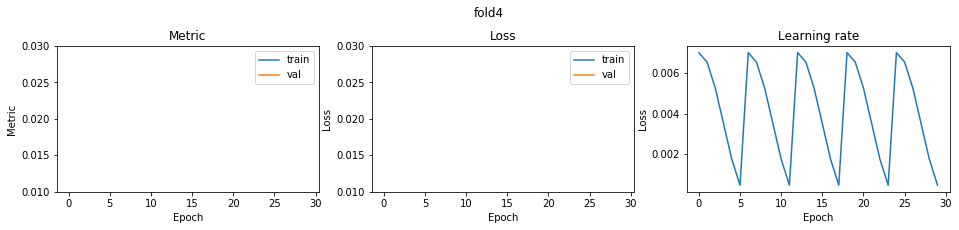

CV score: 0.49597358557430016

optimizer: SGDP
fold 0


epoch1 save best model... 0.7037449880178535
epoch2 save best model... 0.6988759305048098
epoch3 save best model... 0.6908531673405328
epoch4 save best model... 0.68741150184753
epoch5 save best model... 0.6844896616045054
epoch7 save best model... 0.6789282492190124
epoch8 save best model... 0.6715725840088447
epoch9 save best model... 0.6640918832433522
epoch10 save best model... 0.6592818624337876
epoch11 save best model... 0.6582324578170081
epoch13 save best model... 0.6486494259302057
epoch14 save best model... 0.640249830253575
epoch15 save best model... 0.6312666043876787
epoch16 save best model... 0.627476319826817
epoch17 save best model... 0.6240324192818314
epoch18 save best model... 0.6237815326058511
epoch19 save best model... 0.611973364559556
epoch20 save best model... 0.5989704136696383
epoch21 save best model... 0.5888777602234843
epoch22 save best model... 0.5802724488232294
epoch23 save best model... 0.5775017676157941
epoch24 save best model... 0.5750631091534956
e

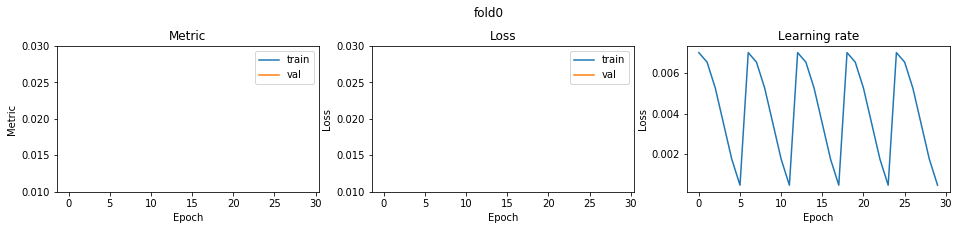

fold 1


epoch1 save best model... 0.7021881237500457
epoch2 save best model... 0.696130085138124
epoch3 save best model... 0.6886453764480457
epoch4 save best model... 0.6856713068053402
epoch5 save best model... 0.683355389721819
epoch7 save best model... 0.6762753463628
epoch8 save best model... 0.6692628500998822
epoch9 save best model... 0.6627559375181695
epoch10 save best model... 0.6603585661448985
epoch11 save best model... 0.65773012307272
epoch12 save best model... 0.6568809279984835
epoch13 save best model... 0.6494603878301758
epoch14 save best model... 0.6403452529535665
epoch15 save best model... 0.6330145755534455
epoch16 save best model... 0.6292622501688793
epoch17 save best model... 0.6232663837916543
epoch19 save best model... 0.6139654018363423
epoch20 save best model... 0.6000923157335821
epoch21 save best model... 0.5892384602149491
epoch22 save best model... 0.5828588954488138
epoch23 save best model... 0.5782095713179757
epoch24 save best model... 0.5746765908224758
epo

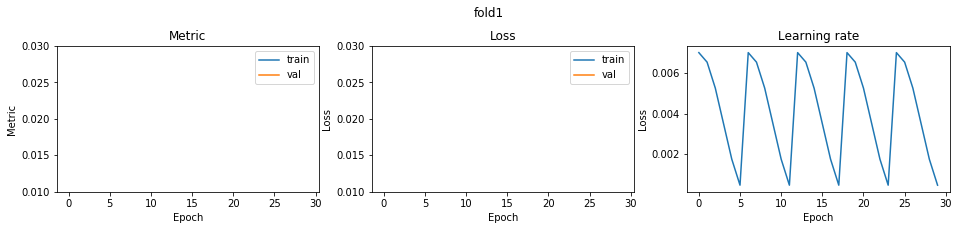

fold 2


epoch1 save best model... 0.7093491080573763
epoch2 save best model... 0.6981948373882122
epoch3 save best model... 0.6925005101484002
epoch4 save best model... 0.6908492391895503
epoch5 save best model... 0.6877473879713326
epoch6 save best model... 0.6853331348623874
epoch7 save best model... 0.6782285920116183
epoch8 save best model... 0.6716877719785065
epoch9 save best model... 0.6661452883928777
epoch10 save best model... 0.6595133459358885
epoch11 save best model... 0.6576554407479144
epoch13 save best model... 0.6499936506101226
epoch14 save best model... 0.6392622678881219
epoch15 save best model... 0.631919548041078
epoch16 save best model... 0.6262786538597119
epoch17 save best model... 0.622213555525799
epoch19 save best model... 0.6119384137392859
epoch20 save best model... 0.5966335727077162
epoch21 save best model... 0.5863744163192685
epoch22 save best model... 0.5742138179974394
epoch23 save best model... 0.5699866335846672
epoch24 save best model... 0.5698861680342631

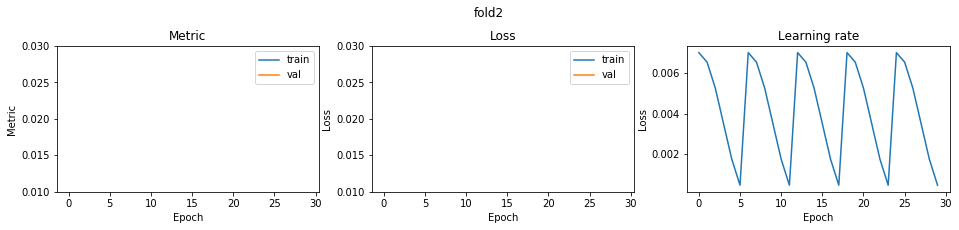

fold 3


epoch1 save best model... 0.70011426666603
epoch2 save best model... 0.6937457040393542
epoch3 save best model... 0.687526961584026
epoch4 save best model... 0.6839119776506358
epoch6 save best model... 0.6805787132378319
epoch7 save best model... 0.6729089449369826
epoch8 save best model... 0.6663788379732188
epoch9 save best model... 0.6598655042181254
epoch10 save best model... 0.6553435470085752
epoch11 save best model... 0.6522988042961764
epoch12 save best model... 0.6507585296869821
epoch13 save best model... 0.6418367111601427
epoch14 save best model... 0.6332161151466718
epoch15 save best model... 0.6260976460908703
epoch16 save best model... 0.6194302370173513
epoch17 save best model... 0.615647510434066
epoch18 save best model... 0.6141382549238096
epoch19 save best model... 0.5998815102023253
epoch20 save best model... 0.5860524277480696
epoch21 save best model... 0.5741007124916024
epoch22 save best model... 0.5658327931423666
epoch23 save best model... 0.5622555731369314


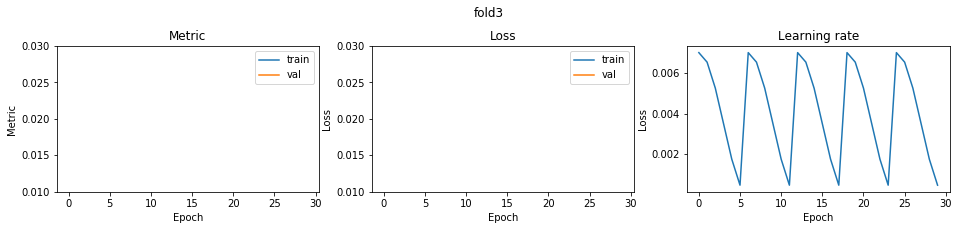

fold 4


epoch1 save best model... 0.7070377155697156
epoch2 save best model... 0.6988173358532725
epoch3 save best model... 0.6926304042746646
epoch4 save best model... 0.6886366016500903
epoch5 save best model... 0.6843049568575987
epoch7 save best model... 0.6773828619161879
epoch8 save best model... 0.6704976348779196
epoch9 save best model... 0.6638915214831845
epoch10 save best model... 0.6568840234317649
epoch11 save best model... 0.6549362261094374
epoch13 save best model... 0.6482746452296785
epoch14 save best model... 0.6399152208569381
epoch15 save best model... 0.6320448685072549
epoch16 save best model... 0.6258622282729877
epoch17 save best model... 0.6222381897016104
epoch19 save best model... 0.6104085585794036
epoch20 save best model... 0.597338679412503
epoch21 save best model... 0.5864646747334943
epoch22 save best model... 0.5752731519027832
epoch23 save best model... 0.5719547005883654
epoch24 save best model... 0.5703994550846161
epoch25 save best model... 0.55403405802668

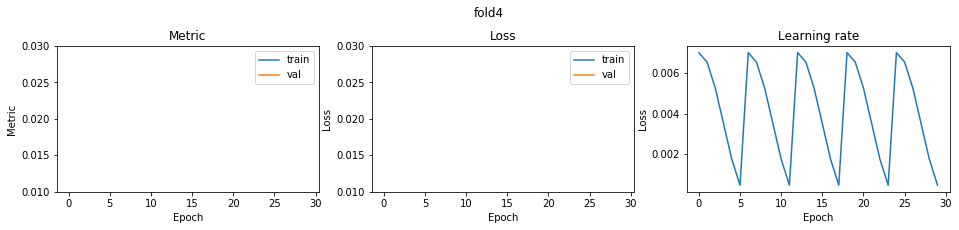

CV score: 0.49300472873641416

optimizer: SGDW
fold 0


epoch1 save best model... 0.7656186022085046
epoch10 save best model... 0.7560486580353392
epoch11 save best model... 0.7290726054773787
epoch13 save best model... 0.7183317412276474
epoch14 save best model... 0.6311233103954167
epoch15 save best model... 0.5883188938225592
epoch17 save best model... 0.5188875350430777
epoch19 save best model... 0.44954649996105794
epoch20 save best model... 0.37988083287903823
epoch21 save best model... 0.313164594959561
epoch25 save best model... 0.24865082914438225
epoch27 save best model... 0.20273344127762563
epoch30 save best model... 0.1908285524619739
fold0 score: 0.19082855201905743


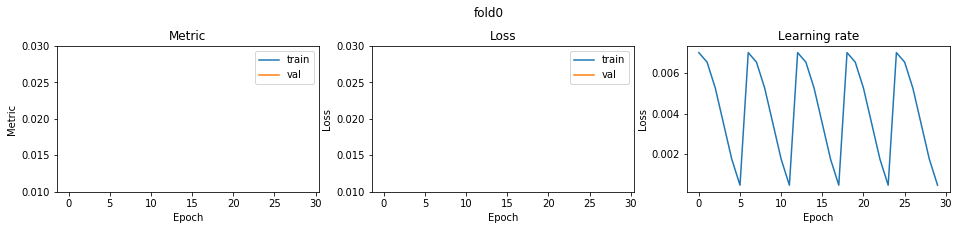

fold 1


epoch1 save best model... 0.7591103945350994
epoch6 save best model... 0.7451528001005434
epoch11 save best model... 0.710033416164087
epoch14 save best model... 0.6848428517030024
epoch15 save best model... 0.6033393157780591
epoch16 save best model... 0.5137747737209192
epoch19 save best model... 0.4040463466997651
epoch20 save best model... 0.3952880216693248
epoch21 save best model... 0.3429923112658874
epoch22 save best model... 0.29150006019714675
epoch23 save best model... 0.285074710985147
epoch25 save best model... 0.2652633450967789
epoch26 save best model... 0.22360387183411787
epoch27 save best model... 0.21109530766825385
epoch28 save best model... 0.199339813265273
epoch29 save best model... 0.194014314148727
epoch30 save best model... 0.1523784901908588
fold1 score: 0.1523784901731996


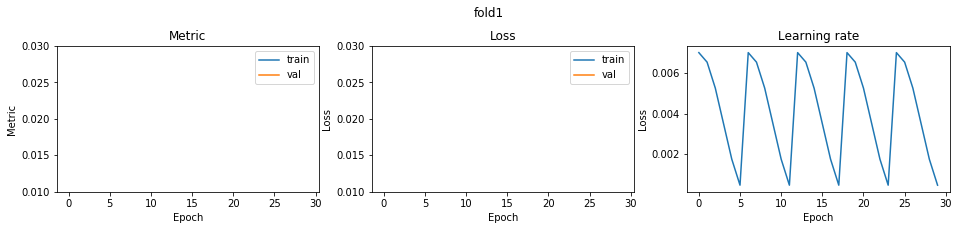

fold 2


epoch1 save best model... 0.7460889251065379
epoch11 save best model... 0.7304395025820525
epoch13 save best model... 0.7074547794542054
epoch14 save best model... 0.6731948649782775
epoch15 save best model... 0.5587509598852046
epoch16 save best model... 0.5225555289101291
epoch19 save best model... 0.4548318351753265
epoch20 save best model... 0.3718195501371189
epoch21 save best model... 0.34527723110938946
epoch22 save best model... 0.3263988443980268
epoch23 save best model... 0.3119400025744948
epoch25 save best model... 0.29649814071613717
epoch26 save best model... 0.24902485877166824
epoch27 save best model... 0.18957596606309496
epoch30 save best model... 0.18265921427380472
fold2 score: 0.1826592140813623


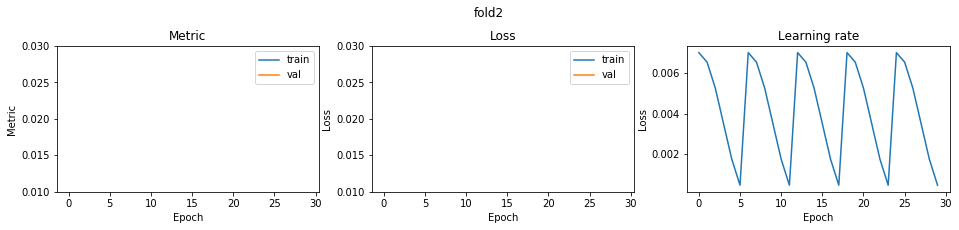

fold 3


epoch1 save best model... 0.7569117704665199
epoch8 save best model... 0.7547363441191393
epoch11 save best model... 0.6747246112530215
epoch13 save best model... 0.5897479666392733
epoch14 save best model... 0.5637789339302341
epoch15 save best model... 0.4786133855241849
epoch17 save best model... 0.4606240763615367
epoch19 save best model... 0.3970288883444932
epoch20 save best model... 0.36027003162814164
epoch21 save best model... 0.3237664693444628
epoch22 save best model... 0.2296650674932367
epoch25 save best model... 0.21202895751982453
epoch26 save best model... 0.20792183500623376
epoch27 save best model... 0.15997380295891425
epoch28 save best model... 0.1492764995825861
epoch30 save best model... 0.147639851726948
fold3 score: 0.14763985171808966


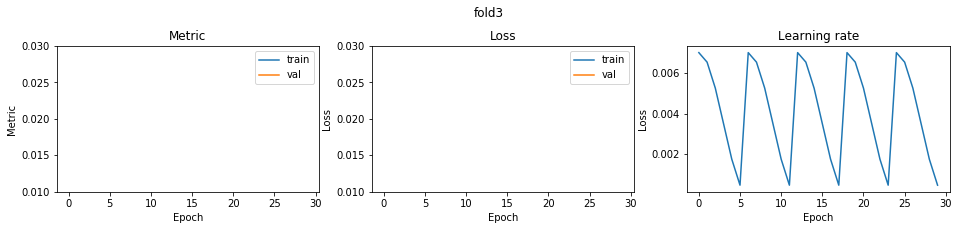

fold 4


epoch1 save best model... 0.7745815195363855
epoch12 save best model... 0.7101024940372328
epoch13 save best model... 0.7047951285415467
epoch14 save best model... 0.6417998122870243
epoch15 save best model... 0.5451097871963961
epoch18 save best model... 0.5370572227687662
epoch19 save best model... 0.4639700517499637
epoch20 save best model... 0.4128052518348759
epoch21 save best model... 0.329712045009424
epoch25 save best model... 0.26575659290804676
epoch26 save best model... 0.23732003797023876
epoch28 save best model... 0.15469332327366148
fold4 score: 0.15469332374555053


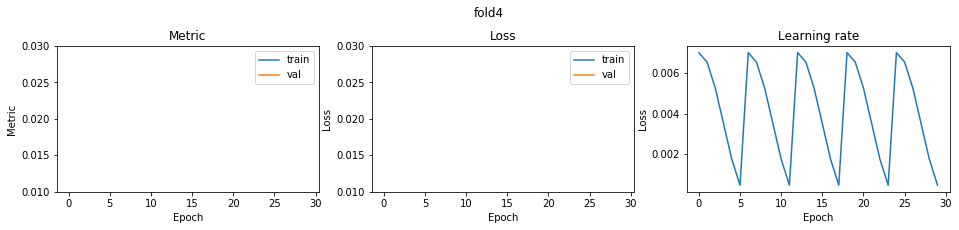

CV score: 0.16563971512767975

optimizer: SGD
fold 0


epoch1 save best model... 0.7107278088502298
epoch2 save best model... 0.7026322663780769
epoch3 save best model... 0.6969196335872919
epoch4 save best model... 0.6930565651837134
epoch5 save best model... 0.6918696514566287
epoch6 save best model... 0.6894581495222035
epoch7 save best model... 0.6839787870984957
epoch8 save best model... 0.6752656194506582
epoch9 save best model... 0.6683784912821915
epoch10 save best model... 0.6657036830461107
epoch11 save best model... 0.6634198476893484
epoch12 save best model... 0.6620927818000724
epoch13 save best model... 0.6537749581836623
epoch14 save best model... 0.6427641623384046
epoch15 save best model... 0.6367466157824141
epoch16 save best model... 0.6317545453073766
epoch17 save best model... 0.6287986627200741
epoch19 save best model... 0.6155116004389891
epoch20 save best model... 0.6019963394536516
epoch21 save best model... 0.5920574513817702
epoch22 save best model... 0.5849044021006868
epoch23 save best model... 0.57860172775177

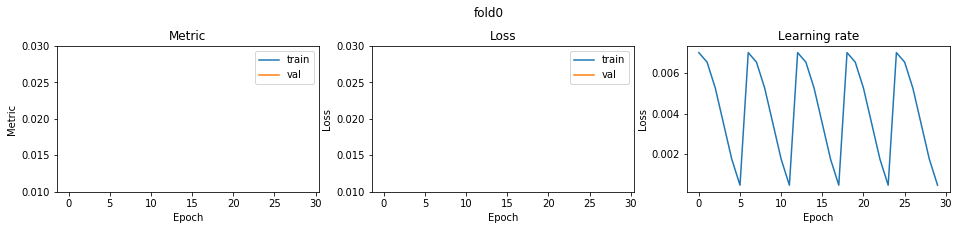

fold 1


epoch1 save best model... 0.705069327495668
epoch2 save best model... 0.6992400960814684
epoch3 save best model... 0.6919902586317682
epoch4 save best model... 0.6883091802585095
epoch5 save best model... 0.685657229978149
epoch7 save best model... 0.6784234882677626
epoch8 save best model... 0.6703916254389066
epoch9 save best model... 0.6646575198871015
epoch10 save best model... 0.6608926747295574
epoch11 save best model... 0.6583910832700601
epoch13 save best model... 0.6489938697311921
epoch14 save best model... 0.6417742254359762
epoch15 save best model... 0.6338376339162556
epoch16 save best model... 0.6280042564551144
epoch17 save best model... 0.6249230813263054
epoch19 save best model... 0.6138486439422856
epoch20 save best model... 0.6003741901049611
epoch21 save best model... 0.5898432002357644
epoch22 save best model... 0.5773742123572532
epoch23 save best model... 0.5759963947022578
epoch24 save best model... 0.5751496848796055
epoch25 save best model... 0.556156701869425

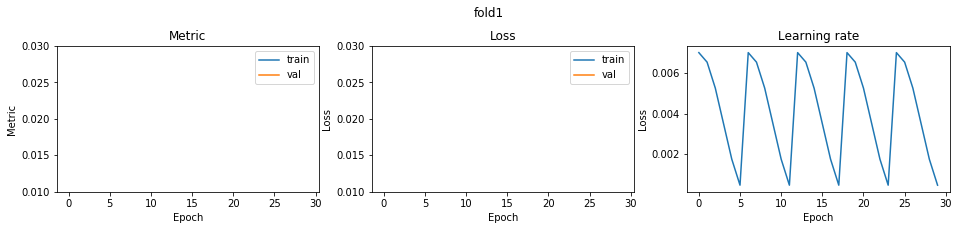

fold 2


epoch1 save best model... 0.7070577286674429
epoch2 save best model... 0.6967267040294839
epoch3 save best model... 0.6910529262412787
epoch4 save best model... 0.6873693711992873
epoch5 save best model... 0.6864183830573907
epoch7 save best model... 0.6766877167179797
epoch8 save best model... 0.6711170974584993
epoch9 save best model... 0.6624658266648966
epoch10 save best model... 0.6613654064056569
epoch11 save best model... 0.6580192924469309
epoch12 save best model... 0.6555649694534879
epoch13 save best model... 0.6465792841997144
epoch14 save best model... 0.6380361612062027
epoch15 save best model... 0.6313575815165823
epoch16 save best model... 0.6250402921830692
epoch17 save best model... 0.6225739564839136
epoch19 save best model... 0.6083740185403856
epoch20 save best model... 0.5946303565835159
epoch21 save best model... 0.5827214581517158
epoch22 save best model... 0.5756572935026582
epoch23 save best model... 0.5710549711719356
epoch24 save best model... 0.5685166250358

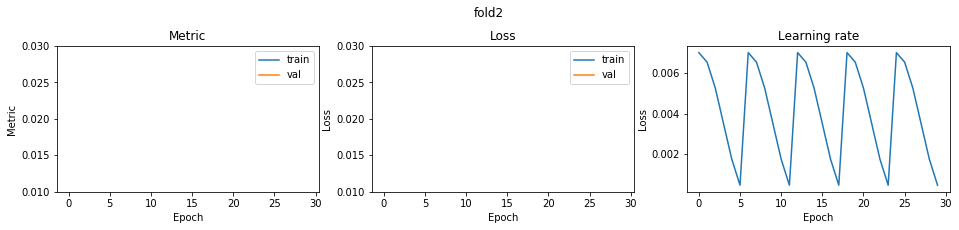

fold 3


epoch1 save best model... 0.7021457812237577
epoch2 save best model... 0.6964154871015179
epoch3 save best model... 0.6900536187688963
epoch4 save best model... 0.6869410243284186
epoch5 save best model... 0.6847607811382528
epoch7 save best model... 0.6752967697884336
epoch8 save best model... 0.6673006938367335
epoch9 save best model... 0.6611817772947846
epoch10 save best model... 0.6606185116909088
epoch11 save best model... 0.6554308789466128
epoch12 save best model... 0.6553834038606265
epoch13 save best model... 0.6504312054714472
epoch14 save best model... 0.6384058659603492
epoch15 save best model... 0.6309807020059207
epoch16 save best model... 0.6249612616786653
epoch17 save best model... 0.6224981673757688
epoch18 save best model... 0.6218846602972113
epoch19 save best model... 0.6093479212975991
epoch20 save best model... 0.5974327064320818
epoch21 save best model... 0.5853493755662088
epoch22 save best model... 0.5781112449315795
epoch23 save best model... 0.5749435367508

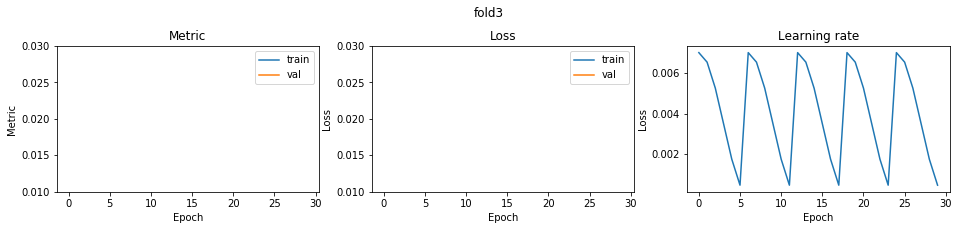

fold 4


epoch1 save best model... 0.7069279157762376
epoch2 save best model... 0.6974032594294103
epoch3 save best model... 0.6931689866583005
epoch4 save best model... 0.6883812532881126
epoch5 save best model... 0.684533999693964
epoch7 save best model... 0.6782880543304739
epoch8 save best model... 0.6701608236666964
epoch9 save best model... 0.6633969609721103
epoch10 save best model... 0.6592240631444579
epoch12 save best model... 0.6578696439369393
epoch13 save best model... 0.6487066078294654
epoch14 save best model... 0.6391569022708711
epoch15 save best model... 0.6341164334216802
epoch16 save best model... 0.627825359548686
epoch17 save best model... 0.6267845414765604
epoch18 save best model... 0.6245628785706869
epoch19 save best model... 0.6127843455736077
epoch20 save best model... 0.6013963644759802
epoch21 save best model... 0.5907839678143043
epoch22 save best model... 0.5803212957121516
epoch23 save best model... 0.578014860690862
epoch24 save best model... 0.5758880550334556

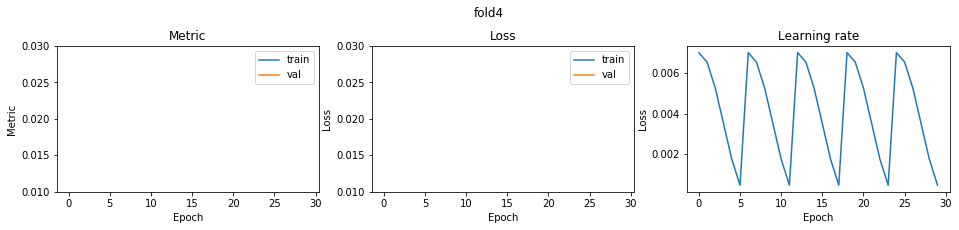

CV score: 0.49823505021660547

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01938778491847743
epoch2 save best model... 0.018402665241670228
epoch3 save best model... 0.017737743950922015
epoch4 save best model... 0.01732732405236886
epoch5 save best model... 0.01693623384168045
epoch6 save best model... 0.016590241907092323
epoch11 save best model... 0.01636530237955493
epoch12 save best model... 0.016229294700408035
epoch17 save best model... 0.0161791043530021
epoch18 save best model... 0.016090506108600758
epoch24 save best model... 0.016053594580526912
fold0 score: 0.016053594437202695


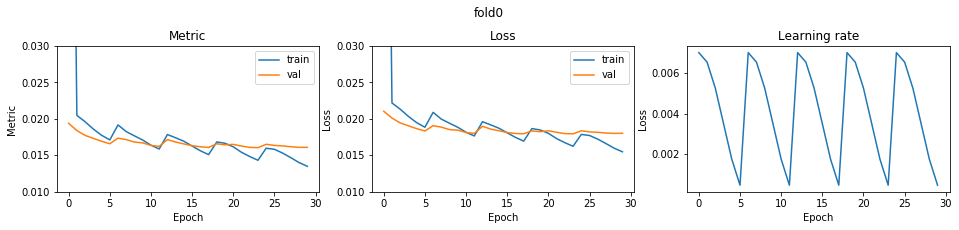

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01940356201423711
epoch2 save best model... 0.018536031376472854
epoch3 save best model... 0.01813388335558644
epoch4 save best model... 0.01753320925168593
epoch5 save best model... 0.017080743390346178
epoch6 save best model... 0.016870999513128183
epoch10 save best model... 0.016864337047655793
epoch11 save best model... 0.01676601557539363
epoch12 save best model... 0.016562330959448375
epoch17 save best model... 0.01651912685619499
epoch18 save best model... 0.01644185584740436
fold1 score: 0.01644185582733095


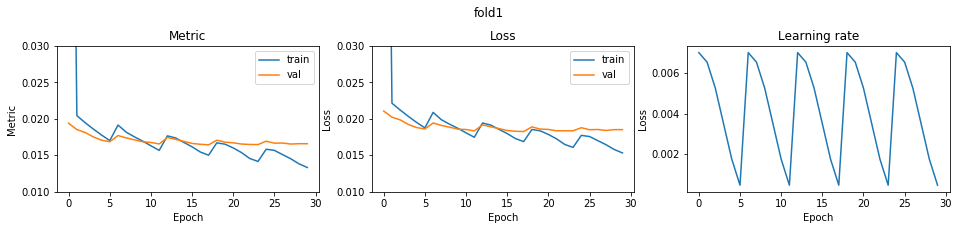

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01941170100051393
epoch2 save best model... 0.018384498576290938
epoch3 save best model... 0.017979985777365915
epoch4 save best model... 0.017388988819714287
epoch5 save best model... 0.016938679057983377
epoch6 save best model... 0.016704858510525195
epoch10 save best model... 0.016646696151908776
epoch11 save best model... 0.016428565347385137
epoch12 save best model... 0.0163119021717414
epoch17 save best model... 0.016245928987025482
epoch18 save best model... 0.016187320667066275
epoch24 save best model... 0.016148272617432544
fold2 score: 0.016148272555986738


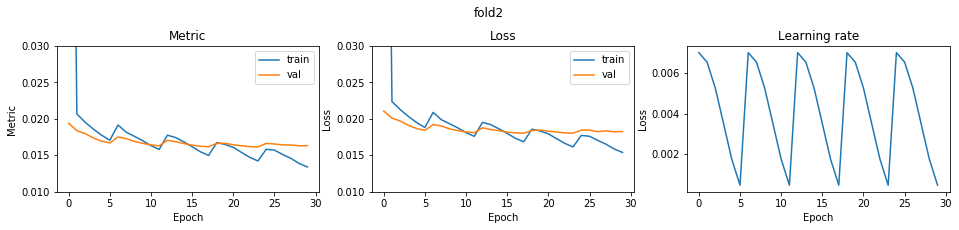

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01962241274909305
epoch2 save best model... 0.01867644269155139
epoch3 save best model... 0.01808454235103448
epoch4 save best model... 0.01756642190124288
epoch5 save best model... 0.017107860984573467
epoch6 save best model... 0.0169045393896164
epoch11 save best model... 0.016702585251989154
epoch12 save best model... 0.016522856863270725
epoch17 save best model... 0.01649210798619888
epoch18 save best model... 0.01639666762330266
epoch24 save best model... 0.01638799688157229
fold3 score: 0.01638799677136244


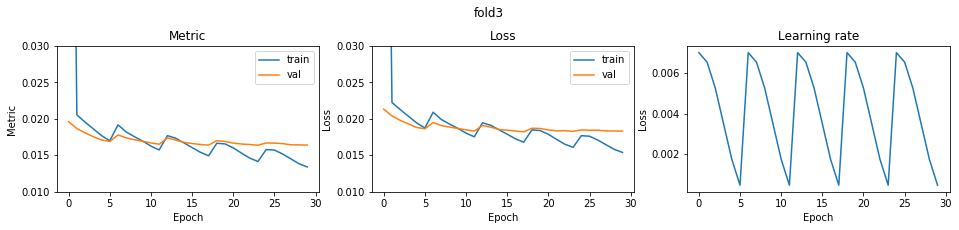

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.018980976896347788
epoch2 save best model... 0.018361705110953582
epoch3 save best model... 0.017765553108499234
epoch4 save best model... 0.017345709213244482
epoch5 save best model... 0.017110473015568388
epoch6 save best model... 0.016834240674480354
epoch10 save best model... 0.016753276790532543
epoch11 save best model... 0.016536045679928637
epoch12 save best model... 0.016450034493924136
epoch18 save best model... 0.016381320347139666
epoch24 save best model... 0.016367491880741505
fold4 score: 0.016367491760575902


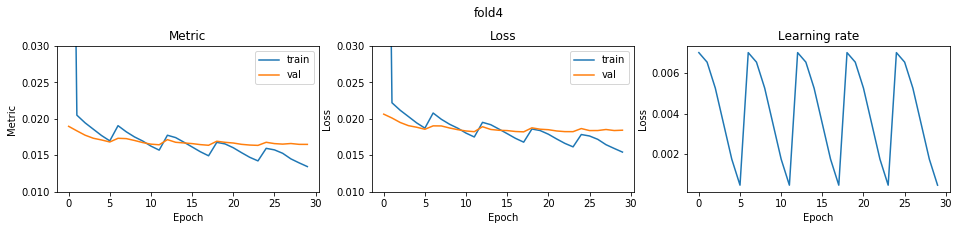

CV score: 0.016279840883402154

optimizer: AdaBound
fold 0


epoch1 save best model... 0.030823903085328723
epoch2 save best model... 0.030438460402003997
fold0 score: 0.03043846040871007


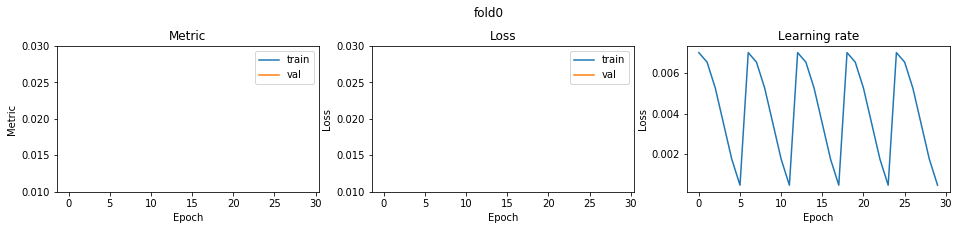

fold 1


epoch1 save best model... 0.031154330809659854
epoch2 save best model... 0.030683218307350078
epoch3 save best model... 0.030651291865005828
epoch4 save best model... 0.030625825189775475
fold1 score: 0.030625824995732506


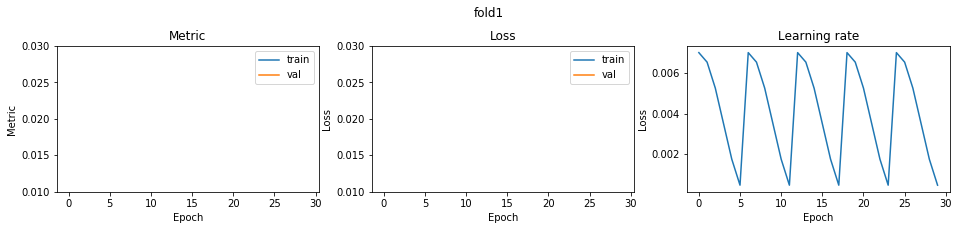

fold 2


epoch1 save best model... 0.030901679942309246
epoch2 save best model... 0.030526415368732625
epoch3 save best model... 0.030422497023381657
epoch5 save best model... 0.03037852649087853
fold2 score: 0.03037852645025006


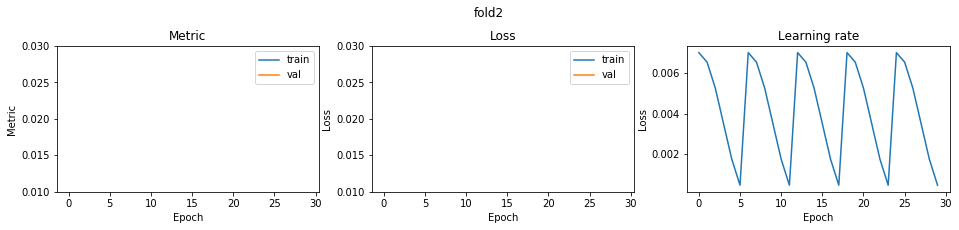

fold 3


epoch1 save best model... 0.03084314563194956
epoch2 save best model... 0.030580004612683977
fold3 score: 0.03058000474140109


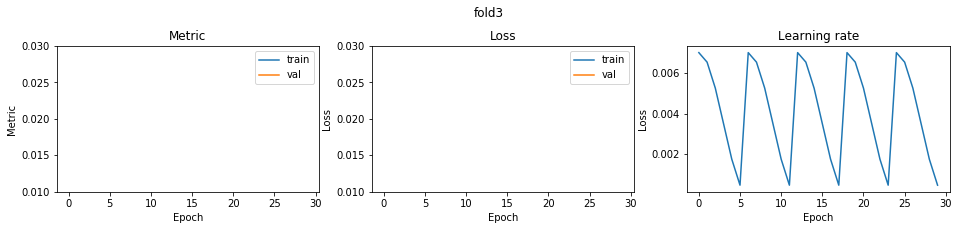

fold 4


epoch1 save best model... 0.03065144387678432
epoch2 save best model... 0.030200022524371234
fold4 score: 0.030200022464310698


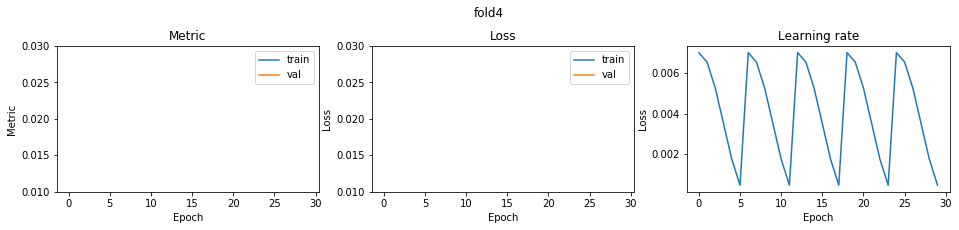

CV score: 0.030444562562590184

optimizer: AdaMod
fold 0


epoch1 save best model... 0.019865779697487727
epoch2 save best model... 0.018269353375212207
epoch3 save best model... 0.01784375082862676
epoch4 save best model... 0.01723872698792564
epoch5 save best model... 0.01687312888104579
epoch6 save best model... 0.016605078850730676
epoch11 save best model... 0.01635384120827791
epoch12 save best model... 0.016201154041636506
epoch17 save best model... 0.016147966377420143
epoch18 save best model... 0.01610805838239424
fold0 score: 0.01610805830998812


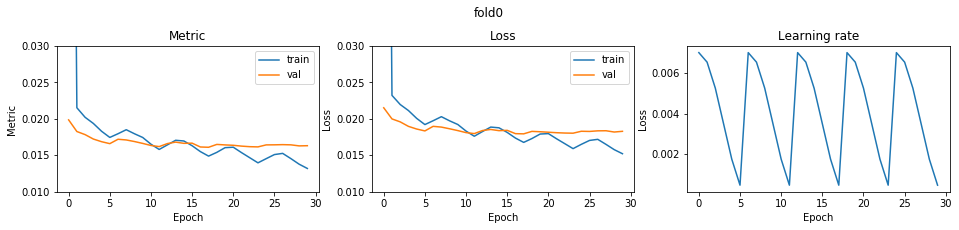

fold 1


epoch1 save best model... 0.020416530580818992
epoch2 save best model... 0.018621456367552525
epoch3 save best model... 0.01793545089266544
epoch4 save best model... 0.017509662605844155
epoch5 save best model... 0.017135228106985877
epoch6 save best model... 0.01687579449774614
epoch10 save best model... 0.01685641098476388
epoch11 save best model... 0.016541533088950258
epoch12 save best model... 0.016396235174264553
epoch18 save best model... 0.0163947057274316
fold1 score: 0.016394705704490496


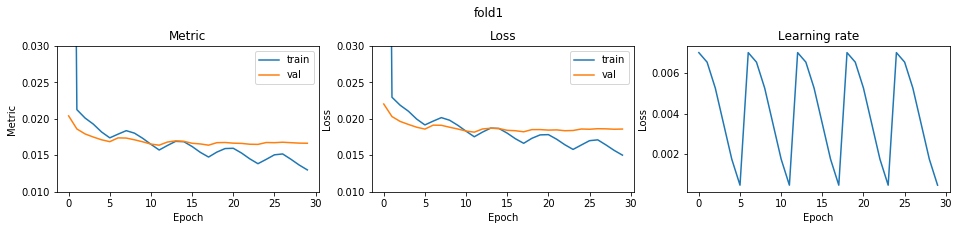

fold 2


epoch1 save best model... 0.020000373051724828
epoch2 save best model... 0.01857752074871792
epoch3 save best model... 0.01796308286741841
epoch4 save best model... 0.017455403913490646
epoch5 save best model... 0.01708577958772315
epoch6 save best model... 0.01670355750848347
epoch11 save best model... 0.016384747290572564
epoch12 save best model... 0.016202332888636293
epoch18 save best model... 0.01613757642392153
fold2 score: 0.01613757633588914


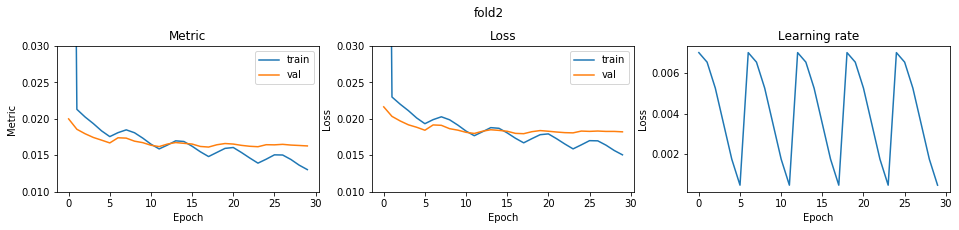

fold 3


epoch1 save best model... 0.02009069213478196
epoch2 save best model... 0.018603558809091262
epoch3 save best model... 0.018124718991254618
epoch4 save best model... 0.017645322447876043
epoch5 save best model... 0.01725363515673846
epoch6 save best model... 0.01699379742154024
epoch10 save best model... 0.01681356926179217
epoch11 save best model... 0.016596797363225856
epoch12 save best model... 0.01644231588972185
epoch17 save best model... 0.016419023731490068
epoch18 save best model... 0.016300151752125566
fold3 score: 0.016300151566432573


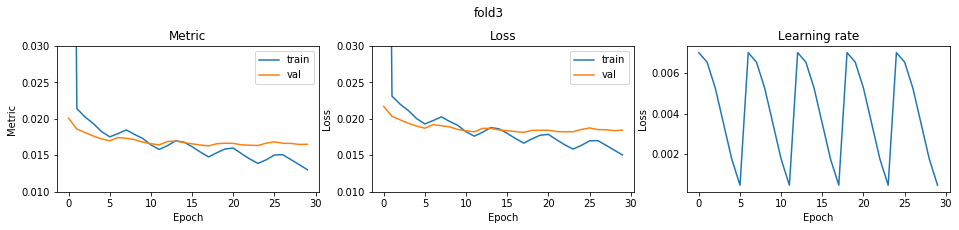

fold 4


epoch1 save best model... 0.019737190327231598
epoch2 save best model... 0.018443291395020104
epoch3 save best model... 0.017935721765872693
epoch4 save best model... 0.017487645865012818
epoch5 save best model... 0.017151915285829666
epoch6 save best model... 0.016810452960567348
epoch10 save best model... 0.016747703946329195
epoch11 save best model... 0.01652406969686847
epoch12 save best model... 0.01634745300834434
epoch18 save best model... 0.016291007354159698
fold4 score: 0.016291007318058666


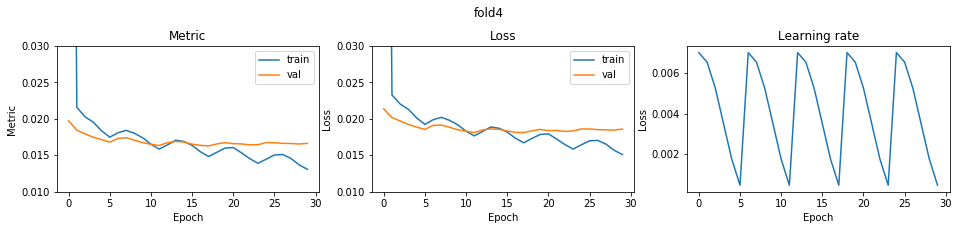

CV score: 0.016246298038955286

optimizer: AdamW
fold 0


epoch1 save best model... 0.0200601369923231
epoch2 save best model... 0.01874625493681105
epoch3 save best model... 0.017963274111780326
epoch4 save best model... 0.017386528546656725
epoch5 save best model... 0.017144387363029777
epoch6 save best model... 0.016899410367928497
epoch9 save best model... 0.016884349155025492
epoch10 save best model... 0.016538877609548645
epoch11 save best model... 0.016417584883935903
epoch12 save best model... 0.01626340428066009
epoch17 save best model... 0.0161948291606064
epoch18 save best model... 0.016169698288609063
epoch23 save best model... 0.01616716541282001
epoch24 save best model... 0.0161476724341953
epoch30 save best model... 0.016147336783842236
fold0 score: 0.016147336665541905


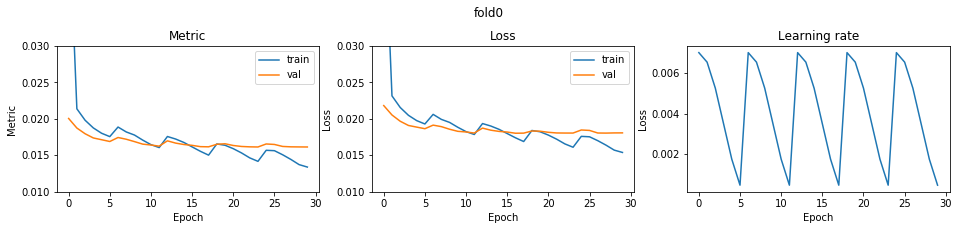

fold 1


epoch1 save best model... 0.020256583791715892
epoch2 save best model... 0.018989360913563003
epoch3 save best model... 0.01806491088715426
epoch4 save best model... 0.017687823283907275
epoch5 save best model... 0.017216917612023548
epoch6 save best model... 0.017024432987358364
epoch10 save best model... 0.016752575610090182
epoch11 save best model... 0.016600326107639635
epoch12 save best model... 0.016473717111385434
epoch17 save best model... 0.016425042176578006
epoch18 save best model... 0.016366575596318086
fold1 score: 0.016366575580625167


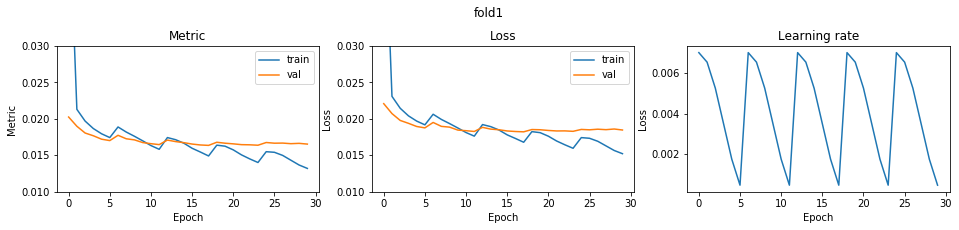

fold 2


epoch1 save best model... 0.019996878658127448
epoch2 save best model... 0.018401359059816276
epoch3 save best model... 0.017997879453901414
epoch4 save best model... 0.017447693480314944
epoch5 save best model... 0.017085286941846987
epoch6 save best model... 0.016864379581448482
epoch10 save best model... 0.01667002875079467
epoch11 save best model... 0.01645077077816602
epoch12 save best model... 0.01635203798089111
epoch17 save best model... 0.016303772404900267
epoch18 save best model... 0.01618876219123405
fold2 score: 0.016188762063660846


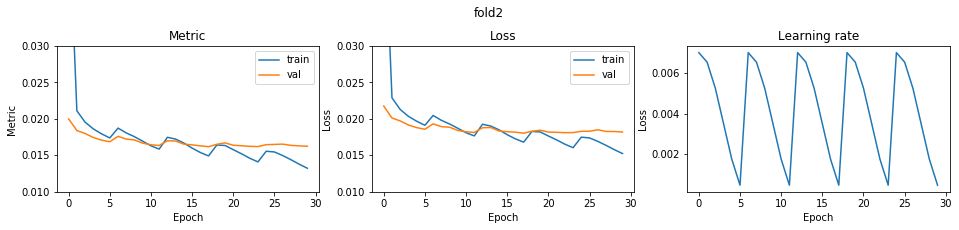

fold 3


epoch1 save best model... 0.020169399422858596
epoch2 save best model... 0.018611765817096265
epoch3 save best model... 0.017969304725850226
epoch4 save best model... 0.017534534801603857
epoch5 save best model... 0.01724162875655572
epoch6 save best model... 0.01704291034201351
epoch10 save best model... 0.016961932935855926
epoch11 save best model... 0.01670534206524593
epoch12 save best model... 0.01661092317228233
epoch17 save best model... 0.01645660314598632
epoch18 save best model... 0.016431617188205887
fold3 score: 0.016431617071714626


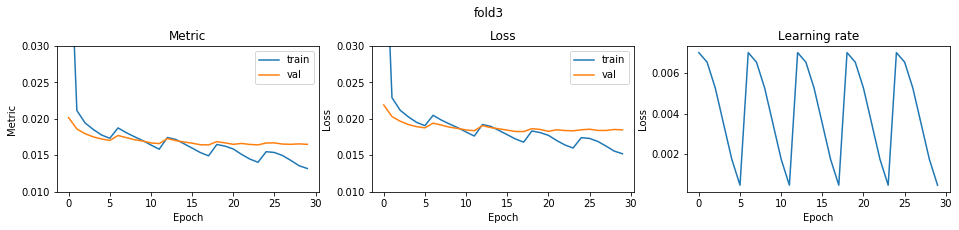

fold 4


epoch1 save best model... 0.019703618824855343
epoch2 save best model... 0.01842788129892192
epoch3 save best model... 0.0178482549502631
epoch4 save best model... 0.017499901021243092
epoch5 save best model... 0.017108307584084926
epoch6 save best model... 0.01692544923870398
epoch10 save best model... 0.01670864938942881
epoch11 save best model... 0.016558857525620346
epoch12 save best model... 0.01647183290196918
epoch17 save best model... 0.01640921230502172
epoch18 save best model... 0.016383516268724054
fold4 score: 0.01638351613347181


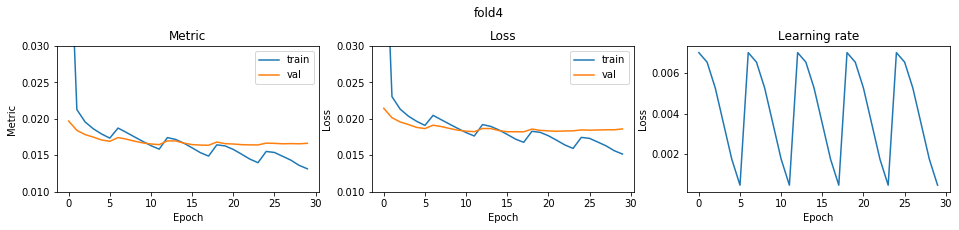

CV score: 0.016303563862459847

optimizer: AdamP
fold 0


epoch1 save best model... 0.019923176166679973
epoch2 save best model... 0.018445704548125386
epoch3 save best model... 0.017708706421298154
epoch4 save best model... 0.017327985666471625
epoch5 save best model... 0.016983107711636122
epoch6 save best model... 0.01681043396964839
epoch10 save best model... 0.016623400522561442
epoch11 save best model... 0.016411454711694924
epoch12 save best model... 0.016267477777831104
epoch17 save best model... 0.01619278575020051
epoch18 save best model... 0.01617005508528823
epoch24 save best model... 0.016058636706636407
fold0 score: 0.01605863653961849


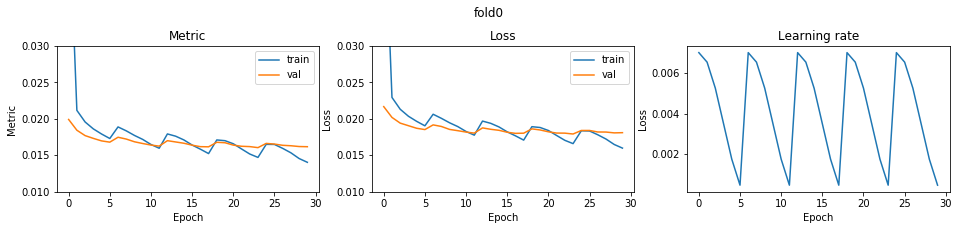

fold 1


epoch1 save best model... 0.020086190762373033
epoch2 save best model... 0.0186424442904533
epoch3 save best model... 0.018090333526465583
epoch4 save best model... 0.01751399351639122
epoch5 save best model... 0.017168850620360193
epoch6 save best model... 0.016974179405191952
epoch10 save best model... 0.01687817212863042
epoch11 save best model... 0.016663594244824206
epoch12 save best model... 0.01652286945967189
epoch17 save best model... 0.016515329213230262
epoch18 save best model... 0.016423561688793508
epoch24 save best model... 0.016418747263957357
fold1 score: 0.016418747226414745


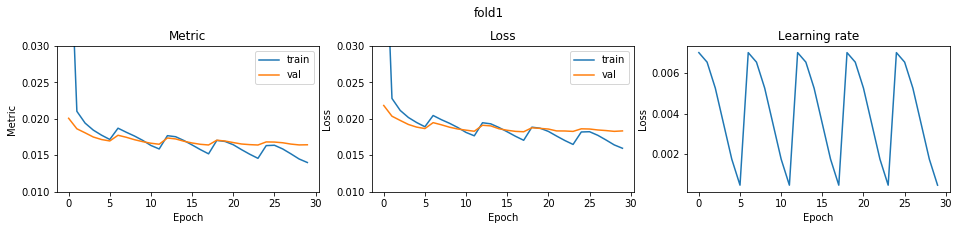

fold 2


epoch1 save best model... 0.020169258787362282
epoch2 save best model... 0.018537016844558985
epoch3 save best model... 0.017858316015480158
epoch4 save best model... 0.0172674174346904
epoch5 save best model... 0.017134290116829137
epoch6 save best model... 0.016888157446102905
epoch10 save best model... 0.016694461429433496
epoch11 save best model... 0.01642983880697812
epoch12 save best model... 0.016318996328462444
epoch17 save best model... 0.016248702788188643
epoch18 save best model... 0.016198053009855596
epoch24 save best model... 0.016138912448487662
fold2 score: 0.01613891227611616


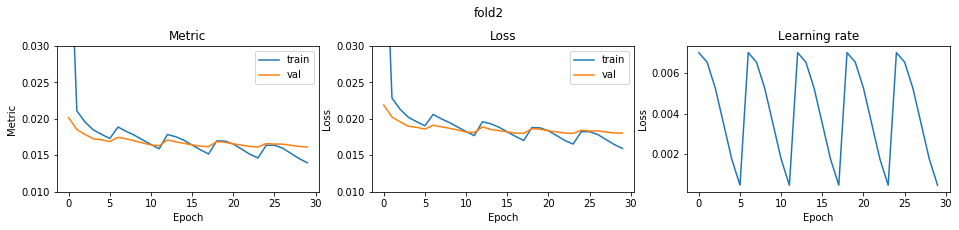

fold 3


epoch1 save best model... 0.0203348841441791
epoch2 save best model... 0.018635417240542403
epoch3 save best model... 0.01808065529870281
epoch4 save best model... 0.017440163658545744
epoch5 save best model... 0.017271774762855303
epoch6 save best model... 0.017068954812180345
epoch10 save best model... 0.016899241072153313
epoch11 save best model... 0.01665760446382275
epoch12 save best model... 0.01655588871746373
epoch17 save best model... 0.016538609613098016
epoch18 save best model... 0.016479445822910322
epoch23 save best model... 0.016406331528275187
epoch24 save best model... 0.016375453196941177
fold3 score: 0.016375453153761713


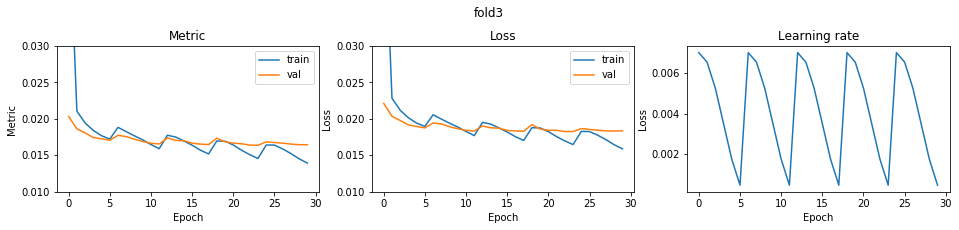

fold 4


epoch1 save best model... 0.01983701015116142
epoch2 save best model... 0.01826677194802867
epoch3 save best model... 0.017781643841016808
epoch4 save best model... 0.017368471356011196
epoch5 save best model... 0.017083838792912375
epoch6 save best model... 0.01688658904267267
epoch10 save best model... 0.01677853761873036
epoch11 save best model... 0.016579649935567705
epoch12 save best model... 0.016461195442019398
epoch17 save best model... 0.016365125121926394
epoch18 save best model... 0.0162840247905234
epoch24 save best model... 0.016260218899909213
fold4 score: 0.01626021884829837


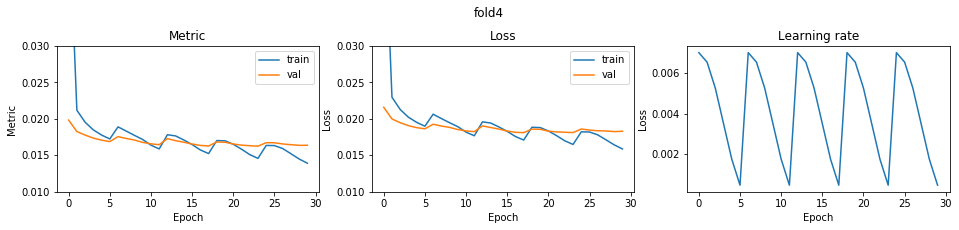

CV score: 0.016250391017613317

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.03170954561654419
epoch21 save best model... 0.03158073350023436
fold0 score: 0.03158073270780018


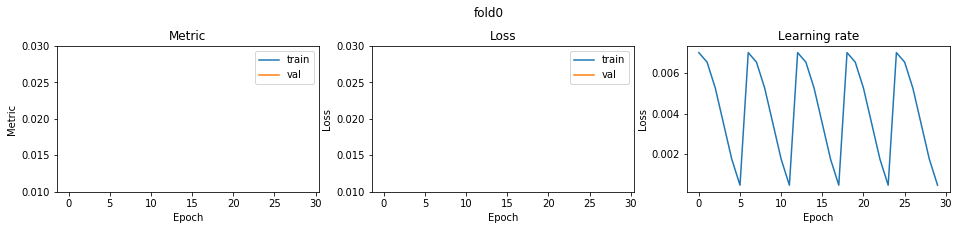

fold 1


epoch1 save best model... 0.03146685013285692
fold1 score: 0.03146685008488902


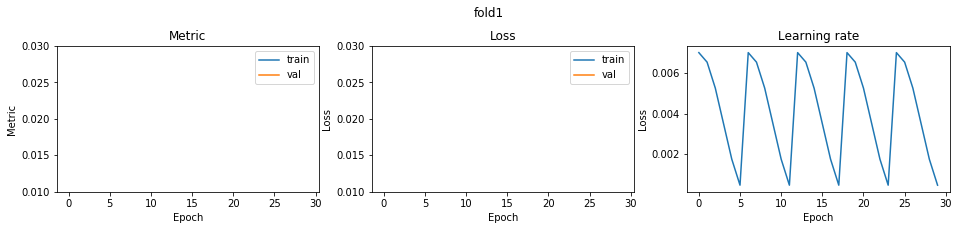

fold 2


epoch1 save best model... 0.03198097421182712
epoch7 save best model... 0.03156495772558482
fold2 score: 0.03156495728447901


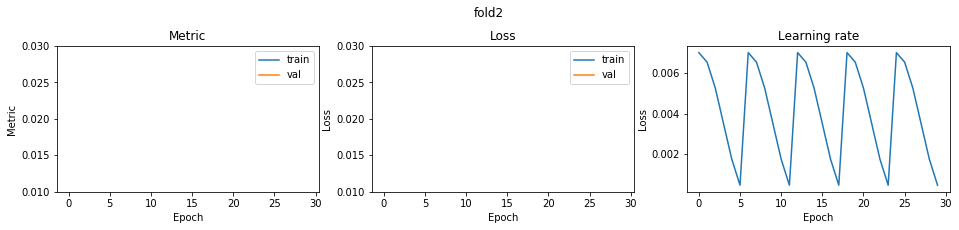

fold 3


epoch1 save best model... 0.03179613929284325
fold3 score: 0.03179613929250763


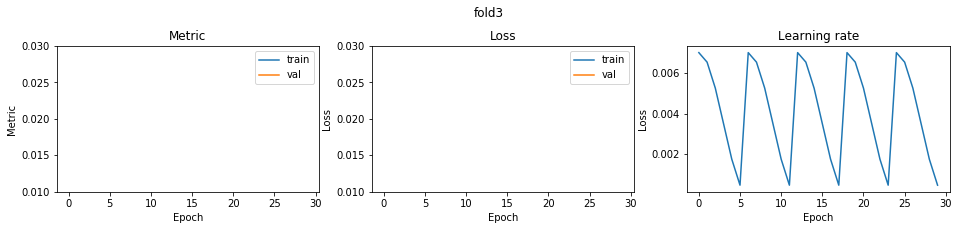

fold 4


epoch1 save best model... 0.03169519930551834
epoch28 save best model... 0.031667053830175575
fold4 score: 0.03166705294177929


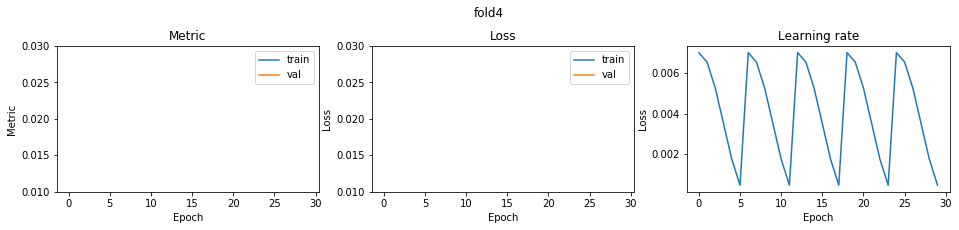

CV score: 0.03161515550573714

optimizer: Lamb
fold 0


epoch1 save best model... 0.02009652682022109
epoch2 save best model... 0.01824496281343875
epoch3 save best model... 0.017776134512588755
epoch4 save best model... 0.017348516695965124
epoch5 save best model... 0.01713693488075277
epoch6 save best model... 0.017053220309062537
epoch9 save best model... 0.016793068580685824
epoch10 save best model... 0.016607278283337527
epoch11 save best model... 0.016463353407647725
epoch12 save best model... 0.016399567783863235
epoch15 save best model... 0.016336297234923393
epoch16 save best model... 0.016248364274332763
epoch17 save best model... 0.01620975424597095
epoch18 save best model... 0.016184833915670802
fold0 score: 0.01618483386092837


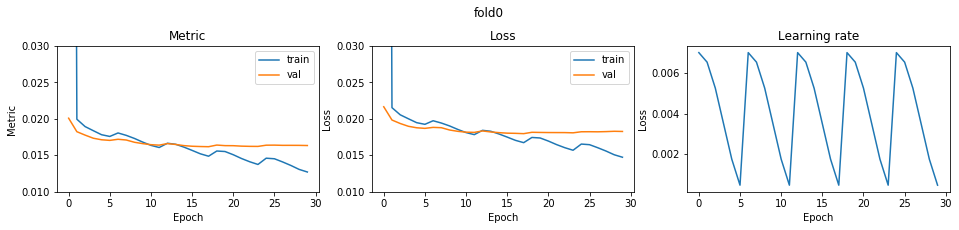

fold 1


epoch1 save best model... 0.020060280970694344
epoch2 save best model... 0.018499035925508278
epoch3 save best model... 0.017945384747191914
epoch4 save best model... 0.01756899647277182
epoch5 save best model... 0.017407759395974404
epoch6 save best model... 0.017298398109517464
epoch9 save best model... 0.017174097447297275
epoch10 save best model... 0.016892834772574628
epoch11 save best model... 0.016710437635436406
epoch12 save best model... 0.01670260029518372
epoch15 save best model... 0.016701261490230327
epoch16 save best model... 0.016615283375024104
epoch17 save best model... 0.016550306468441536
epoch18 save best model... 0.016523037668326895
fold1 score: 0.01652303754863405


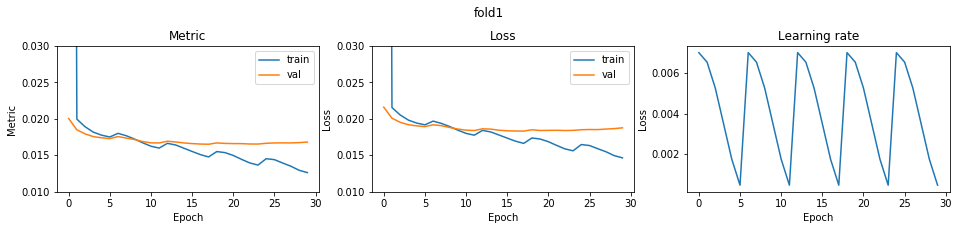

fold 2


epoch1 save best model... 0.019925812817388526
epoch2 save best model... 0.01843353374981071
epoch3 save best model... 0.017783481794912143
epoch4 save best model... 0.017350886416646758
epoch5 save best model... 0.017110282563710298
epoch6 save best model... 0.017009727739597216
epoch9 save best model... 0.016849809993583837
epoch10 save best model... 0.016610082944247793
epoch11 save best model... 0.016486944109379675
epoch12 save best model... 0.01645550563571583
epoch16 save best model... 0.01637367425432548
epoch17 save best model... 0.01630911733433146
epoch18 save best model... 0.01625419179273408
fold2 score: 0.016254191686685293


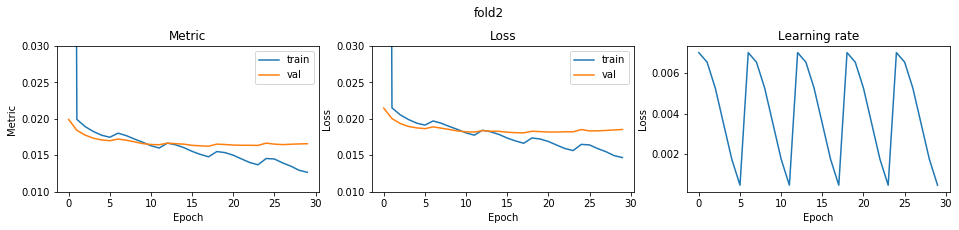

fold 3


epoch1 save best model... 0.020253482108388374
epoch2 save best model... 0.018477066451416335
epoch3 save best model... 0.017917180468237075
epoch4 save best model... 0.01760468598718252
epoch5 save best model... 0.017363478527202828
epoch6 save best model... 0.017340042806550826
epoch8 save best model... 0.017290765198545874
epoch9 save best model... 0.017001665035233003
epoch10 save best model... 0.016924092672968915
epoch11 save best model... 0.01675040951393256
epoch12 save best model... 0.016702596745231023
epoch15 save best model... 0.016692815336201483
epoch16 save best model... 0.016570058300802677
epoch17 save best model... 0.016510618301129695
epoch18 save best model... 0.016457456737281523
epoch23 save best model... 0.01644946378539051
epoch24 save best model... 0.016438374143933922
fold3 score: 0.016438374083231958


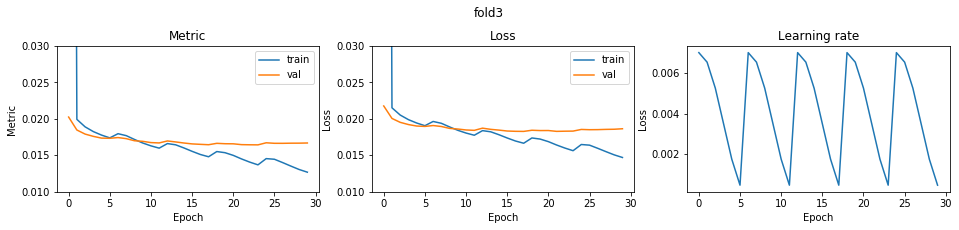

fold 4


epoch1 save best model... 0.019799647923211032
epoch2 save best model... 0.01841606020180674
epoch3 save best model... 0.01774784000272224
epoch4 save best model... 0.01754612310456456
epoch5 save best model... 0.017262880103174675
epoch6 save best model... 0.017216754903282824
epoch8 save best model... 0.0171162749880369
epoch9 save best model... 0.016919991022701416
epoch10 save best model... 0.016798402744097156
epoch11 save best model... 0.016705384166117818
epoch12 save best model... 0.016634323853142306
epoch15 save best model... 0.016594720036555124
epoch16 save best model... 0.016520828616238943
epoch17 save best model... 0.016467571331947567
fold4 score: 0.016467571305571957


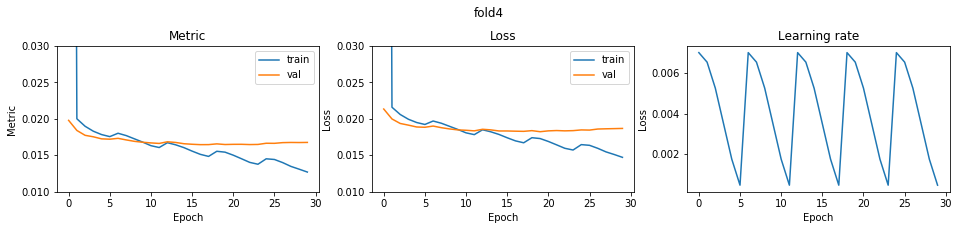

CV score: 0.016373600328965798

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.018574860748879457
epoch2 save best model... 0.017711462914638203
epoch3 save best model... 0.017331135070167803
epoch4 save best model... 0.01705334561289307
epoch5 save best model... 0.01682453841259512
epoch6 save best model... 0.01677451908147145
epoch9 save best model... 0.01662789821743558
epoch10 save best model... 0.0164316652465722
epoch11 save best model... 0.01636898519984682
epoch12 save best model... 0.016251933859376944
epoch16 save best model... 0.01623871451952327
epoch17 save best model... 0.016108049864717387
epoch24 save best model... 0.016056095415425055
epoch30 save best model... 0.01604337333096934
fold0 score: 0.016043373288191644


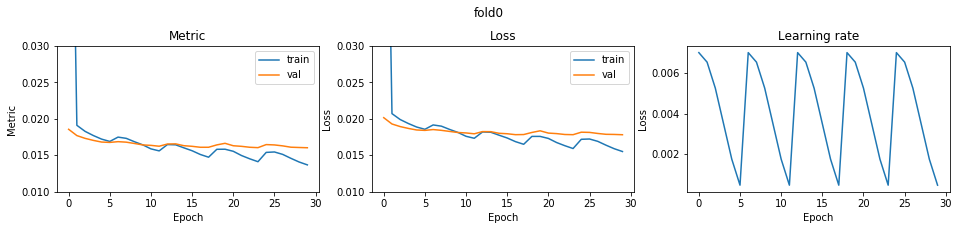

fold 1


epoch1 save best model... 0.018797861674440208
epoch2 save best model... 0.017933249776585822
epoch3 save best model... 0.01760609791626635
epoch4 save best model... 0.01725665994131109
epoch5 save best model... 0.017094011121448812
epoch6 save best model... 0.01699616141552791
epoch9 save best model... 0.01696808901813843
epoch10 save best model... 0.016772101062871338
epoch11 save best model... 0.01659675319648313
epoch12 save best model... 0.01654141651129948
epoch18 save best model... 0.016518665997298315
epoch23 save best model... 0.016508838163948082
epoch24 save best model... 0.016471408935436478
fold1 score: 0.01647140884726475


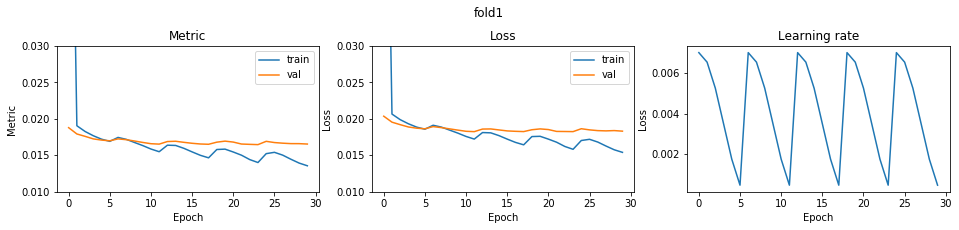

fold 2


epoch1 save best model... 0.018563468417496093
epoch2 save best model... 0.017759686972717608
epoch3 save best model... 0.017451596821283364
epoch4 save best model... 0.017076251845646418
epoch5 save best model... 0.01690470973145591
epoch6 save best model... 0.016797139134286043
epoch9 save best model... 0.01677456144226503
epoch10 save best model... 0.01648703940135488
epoch11 save best model... 0.016368366363480616
epoch12 save best model... 0.016295554993793412
epoch17 save best model... 0.01621068497038792
epoch18 save best model... 0.01617821455205538
fold2 score: 0.016178214525022352


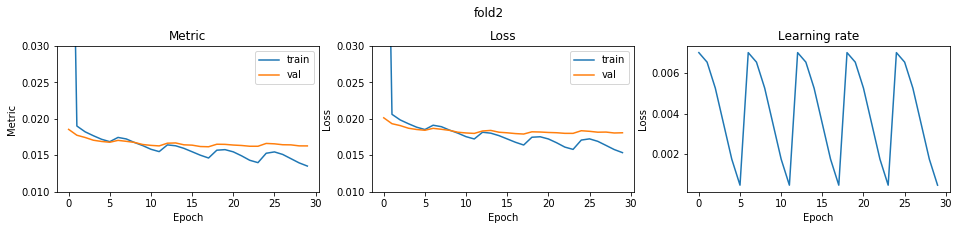

fold 3


epoch1 save best model... 0.01876856371726425
epoch2 save best model... 0.01796280670070974
epoch3 save best model... 0.017506087423304353
epoch4 save best model... 0.01731366501921673
epoch5 save best model... 0.017132013714988983
epoch6 save best model... 0.01703027822204562
epoch9 save best model... 0.016881147911241765
epoch10 save best model... 0.016730333139996865
epoch11 save best model... 0.016545823009383433
epoch12 save best model... 0.016486809652188374
epoch17 save best model... 0.016381918518021194
epoch18 save best model... 0.016362044739628163
epoch24 save best model... 0.016344265297802
epoch30 save best model... 0.016312676879889194
fold3 score: 0.016312676681335164


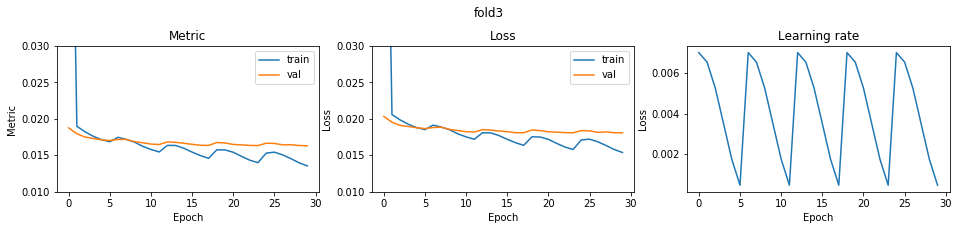

fold 4


epoch1 save best model... 0.0184251694827593
epoch2 save best model... 0.01780970825310924
epoch3 save best model... 0.017436920746668732
epoch4 save best model... 0.01713557140116743
epoch5 save best model... 0.016910322221390616
epoch6 save best model... 0.01686843177240028
epoch9 save best model... 0.016818475738965433
epoch10 save best model... 0.016553261985149496
epoch11 save best model... 0.016476625327979784
epoch12 save best model... 0.01640214552394282
epoch17 save best model... 0.016349019707606972
epoch18 save best model... 0.01633151265450993
epoch24 save best model... 0.01632656647499167
fold4 score: 0.016326566348183417


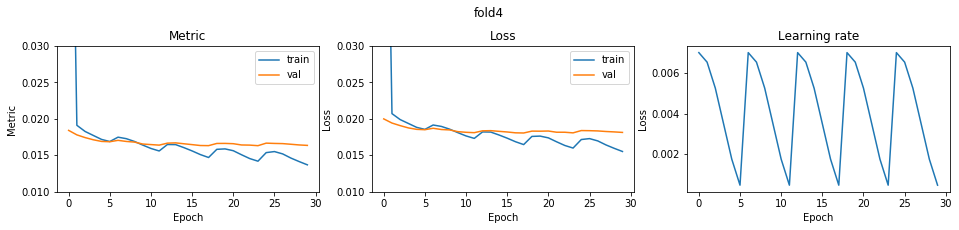

CV score: 0.016266442619633496

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.02033859429571243
epoch2 save best model... 0.01889562524668448
epoch3 save best model... 0.018230277582459948
epoch4 save best model... 0.017772024409136902
epoch5 save best model... 0.017354333236100732
epoch6 save best model... 0.01708092738222967
epoch9 save best model... 0.017037239634264303
epoch10 save best model... 0.016682909457925242
epoch11 save best model... 0.016497105612061018
epoch12 save best model... 0.016325805016320225
epoch17 save best model... 0.016255821166708557
epoch18 save best model... 0.016164359859358476
epoch23 save best model... 0.01612494934587856
epoch24 save best model... 0.016069988678962602
fold0 score: 0.016069988576051155


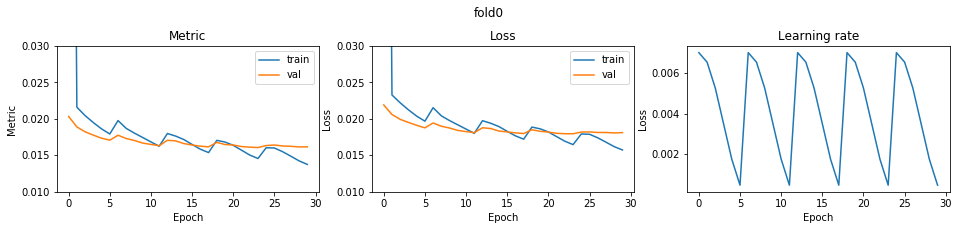

fold 1


epoch1 save best model... 0.020445931998227283
epoch2 save best model... 0.018966631726190994
epoch3 save best model... 0.018175851225201104
epoch4 save best model... 0.0176798105367185
epoch5 save best model... 0.017328299186049223
epoch6 save best model... 0.017132998867256204
epoch10 save best model... 0.01690925500725092
epoch11 save best model... 0.016691111853631844
epoch12 save best model... 0.01655783128047667
epoch17 save best model... 0.016482123990722915
epoch18 save best model... 0.016388529281843412
fold1 score: 0.01638852908783396


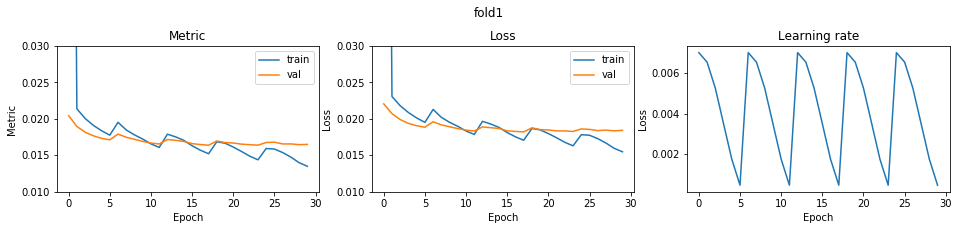

fold 2


epoch1 save best model... 0.02054939140546808
epoch2 save best model... 0.01904328479046436
epoch3 save best model... 0.018309485911643976
epoch4 save best model... 0.017599936826360418
epoch5 save best model... 0.017208140040413614
epoch6 save best model... 0.016995696687472927
epoch10 save best model... 0.016772740064954862
epoch11 save best model... 0.016549271707312477
epoch12 save best model... 0.0163981469484302
epoch17 save best model... 0.016278191311312484
epoch18 save best model... 0.01615694483076251
epoch24 save best model... 0.016125916991842026
fold2 score: 0.01612591692450605


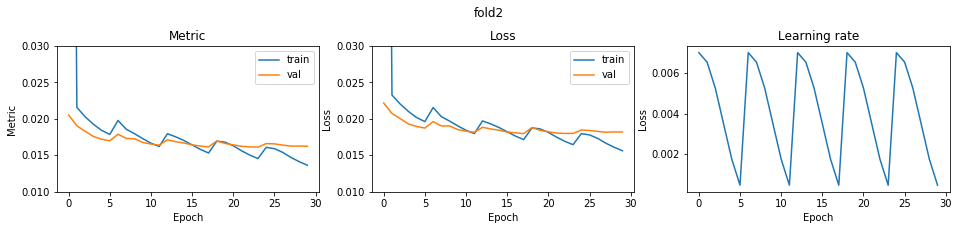

fold 3


epoch1 save best model... 0.02046349021120332
epoch2 save best model... 0.018863667622378313
epoch3 save best model... 0.018190850807960592
epoch4 save best model... 0.017836306547504215
epoch5 save best model... 0.017397875908617955
epoch6 save best model... 0.017169115275297322
epoch10 save best model... 0.016947295475148665
epoch11 save best model... 0.01681593176367818
epoch12 save best model... 0.016614721527064308
epoch17 save best model... 0.016508053306379868
epoch18 save best model... 0.016429748353474098
epoch23 save best model... 0.016416038643645128
epoch24 save best model... 0.016371918393719032
epoch30 save best model... 0.016368150167540563
fold3 score: 0.016368150082556324


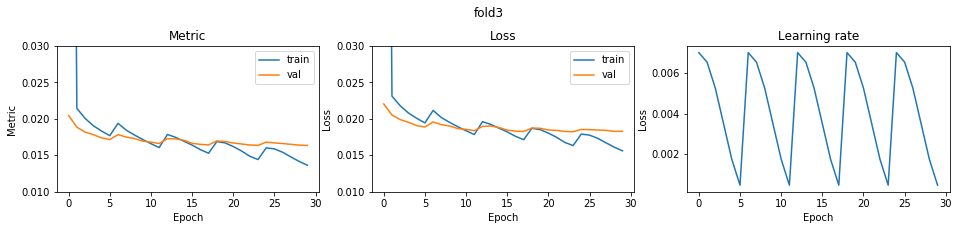

fold 4


epoch1 save best model... 0.020069285761352824
epoch2 save best model... 0.01876245541137416
epoch3 save best model... 0.017997276287415577
epoch4 save best model... 0.017659230807325156
epoch5 save best model... 0.01732082213222098
epoch6 save best model... 0.01702468520866236
epoch10 save best model... 0.016888542702434273
epoch11 save best model... 0.016699727558889394
epoch12 save best model... 0.016570583077525222
epoch17 save best model... 0.01648635625678002
epoch18 save best model... 0.01643672288100581
epoch23 save best model... 0.016371553340303057
epoch24 save best model... 0.016368583103128474
fold4 score: 0.016368582969310576


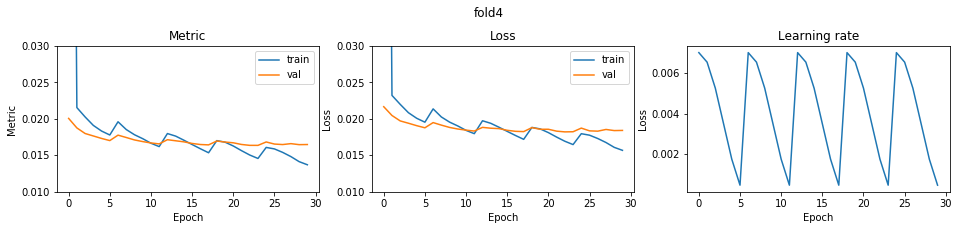

CV score: 0.016264234166881743

optimizer: QHAdam
fold 0


epoch1 save best model... 0.03179580162625106
epoch7 save best model... 0.03172954224168847
epoch15 save best model... 0.03141891842958324
fold0 score: 0.03141891772222907


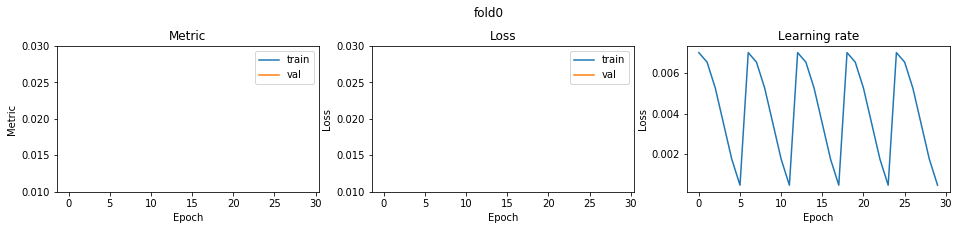

fold 1


epoch1 save best model... 0.031973484470696784
epoch2 save best model... 0.03186893556245804
epoch13 save best model... 0.03179862302099689
fold1 score: 0.0317986256442831


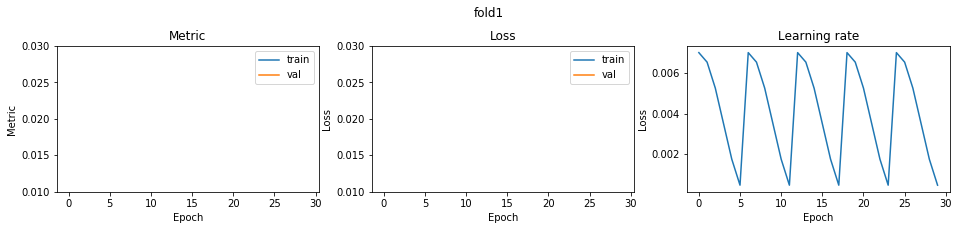

fold 2


epoch1 save best model... 0.03213910545579161
epoch7 save best model... 0.03202885252207782
epoch11 save best model... 0.0319667644824219
epoch13 save best model... 0.03162856635209585
epoch27 save best model... 0.031249678101900717
fold2 score: 0.031249675168538917


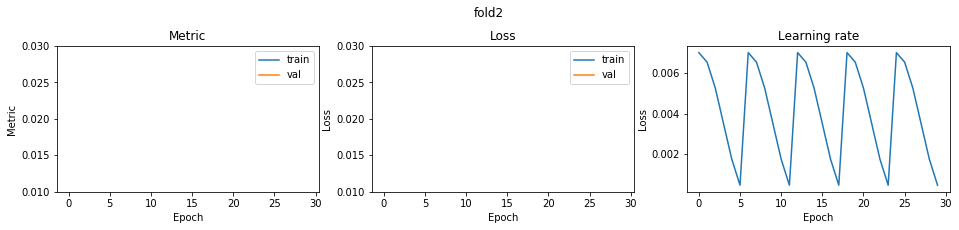

fold 3


epoch1 save best model... 0.03194150930028706
fold3 score: 0.03194150916188684


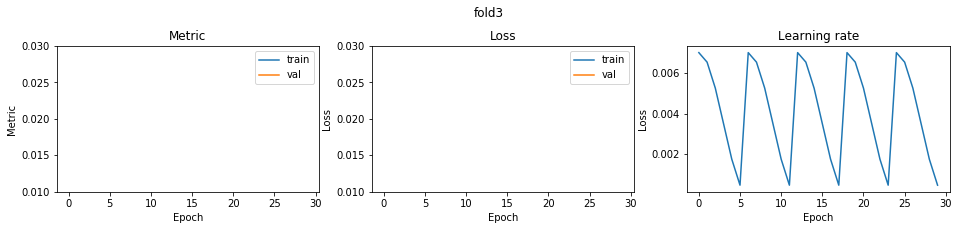

fold 4


epoch1 save best model... 0.03221664188391527
epoch2 save best model... 0.03202563312439278
epoch5 save best model... 0.03200354606829635
epoch11 save best model... 0.03196997408816646
epoch20 save best model... 0.03136697114701966
fold4 score: 0.03136697002080355


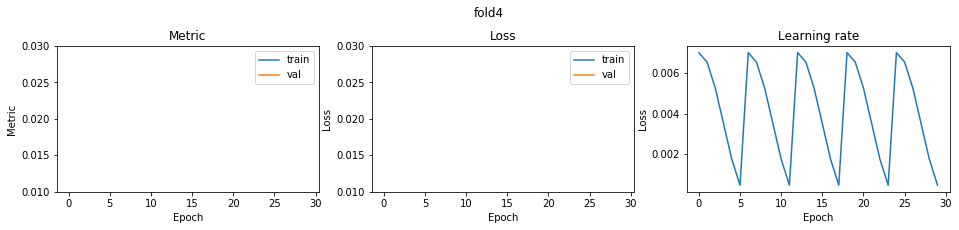

CV score: 0.03155514236741719

optimizer: RAdam
fold 0


epoch1 save best model... 0.0208583637011282
epoch2 save best model... 0.019148500222958845
epoch3 save best model... 0.018071530451298033
epoch4 save best model... 0.01754441767727324
epoch5 save best model... 0.017122669432286793
epoch6 save best model... 0.016961233558001713
epoch10 save best model... 0.01668549175703037
epoch11 save best model... 0.01645753302257126
epoch12 save best model... 0.016311669985260943
epoch17 save best model... 0.01621682977172332
epoch18 save best model... 0.016142040730829525
epoch23 save best model... 0.016064368415377814
epoch24 save best model... 0.01603803335389882
fold0 score: 0.016038033221477392


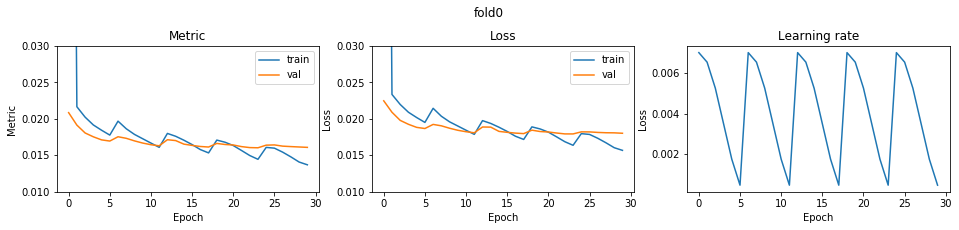

fold 1


epoch1 save best model... 0.02048315357448273
epoch2 save best model... 0.018843979664498293
epoch3 save best model... 0.01826885370565224
epoch4 save best model... 0.017734010204991955
epoch5 save best model... 0.017341454432100417
epoch6 save best model... 0.01707205916573475
epoch10 save best model... 0.01698996506437853
epoch11 save best model... 0.01663939903201024
epoch12 save best model... 0.016516516626383673
epoch18 save best model... 0.01642878574638961
epoch24 save best model... 0.01639864133918345
fold1 score: 0.016398641262450338


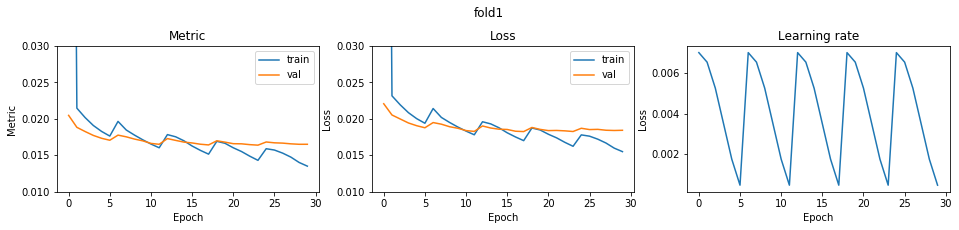

fold 2


epoch1 save best model... 0.020539045003687337
epoch2 save best model... 0.019204613735475363
epoch3 save best model... 0.018096115255520837
epoch4 save best model... 0.01761923550793001
epoch5 save best model... 0.017247679940617745
epoch6 save best model... 0.016967018848078403
epoch10 save best model... 0.01678190661917232
epoch11 save best model... 0.01651664861021905
epoch12 save best model... 0.016425542796519112
epoch17 save best model... 0.016286836526048742
epoch18 save best model... 0.016175204350921377
epoch24 save best model... 0.01616883405379647
fold2 score: 0.016168834000966633


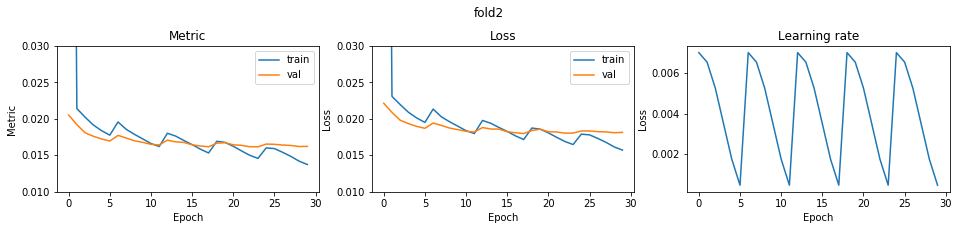

fold 3


epoch1 save best model... 0.020637928438213802
epoch2 save best model... 0.01881437038362094
epoch3 save best model... 0.018477070009535294
epoch4 save best model... 0.017707750154128787
epoch5 save best model... 0.017415005953002355
epoch6 save best model... 0.017145336289086075
epoch10 save best model... 0.016988189942744435
epoch11 save best model... 0.01675839675696469
epoch12 save best model... 0.01663340928334242
epoch17 save best model... 0.01648373952292432
epoch18 save best model... 0.01636820738426577
fold3 score: 0.016368207302738934


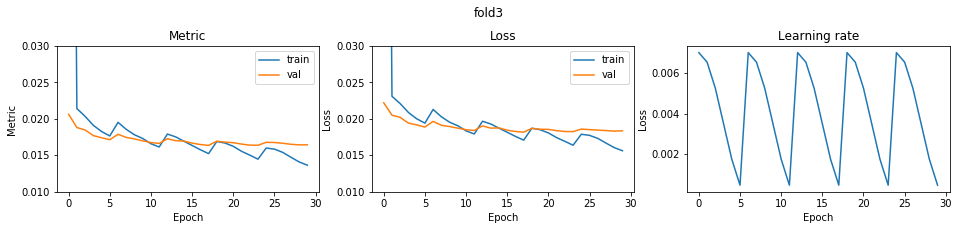

fold 4


epoch1 save best model... 0.02009826918940881
epoch2 save best model... 0.018799676502585953
epoch3 save best model... 0.01805910061289618
epoch4 save best model... 0.01764659095250053
epoch5 save best model... 0.017254502046216865
epoch6 save best model... 0.017031657410221248
epoch10 save best model... 0.0168884941153992
epoch11 save best model... 0.01658419541895797
epoch12 save best model... 0.01651943545398177
epoch17 save best model... 0.01644365368517018
epoch18 save best model... 0.016378092054693465
epoch23 save best model... 0.01635281533673236
epoch24 save best model... 0.016308145415555506
fold4 score: 0.016308145388141182


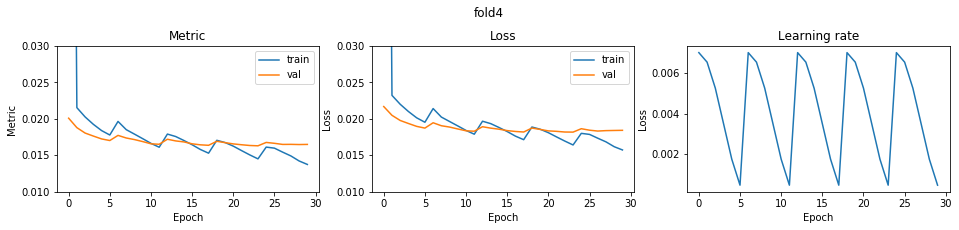

CV score: 0.016256369741497474

optimizer: Ranger
fold 0


epoch1 save best model... 0.021413188327553602
epoch2 save best model... 0.01962744036014775
epoch3 save best model... 0.018542314868988916
epoch4 save best model... 0.017987631428520067
epoch5 save best model... 0.017657777446413368
epoch6 save best model... 0.017455609537372557
epoch8 save best model... 0.017360572153723594
epoch9 save best model... 0.016997533680230447
epoch10 save best model... 0.016704687079444426
epoch11 save best model... 0.016523990529782408
epoch12 save best model... 0.016400565528618447
epoch16 save best model... 0.016315621678167976
epoch17 save best model... 0.01616255653882081
epoch18 save best model... 0.01606679539660794
fold0 score: 0.0160667952323587


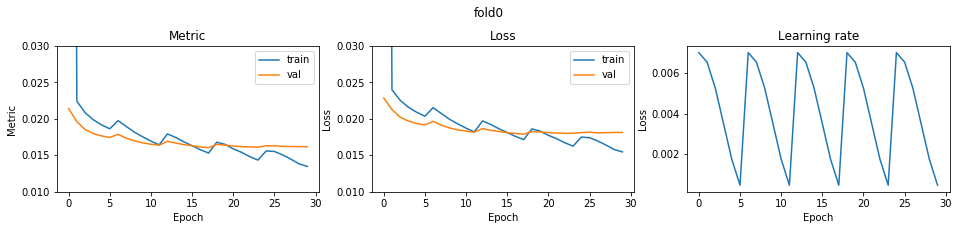

fold 1


epoch1 save best model... 0.02182060088830756
epoch2 save best model... 0.019625055860650786
epoch3 save best model... 0.018782231254355866
epoch4 save best model... 0.018124321425547086
epoch5 save best model... 0.017760780043467136
epoch6 save best model... 0.01762527914233565
epoch8 save best model... 0.017580251005943123
epoch9 save best model... 0.017269164622789105
epoch10 save best model... 0.017010038452064648
epoch11 save best model... 0.016723523568086145
epoch12 save best model... 0.016596236336432223
epoch17 save best model... 0.0164614844563088
epoch18 save best model... 0.016380962611643537
fold1 score: 0.01638096255006352


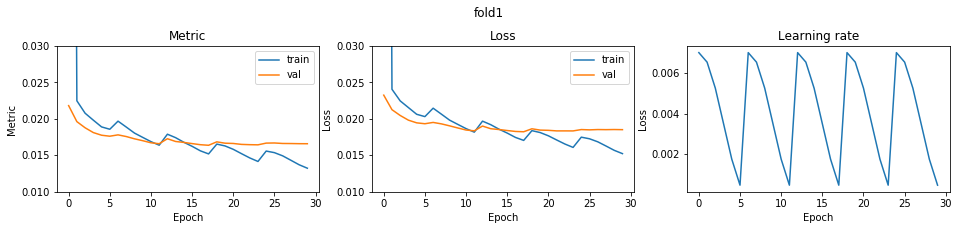

fold 2


epoch1 save best model... 0.021213365225157453
epoch2 save best model... 0.01993432659193225
epoch3 save best model... 0.018614378217314907
epoch4 save best model... 0.017940096335184685
epoch5 save best model... 0.017564761776822552
epoch6 save best model... 0.017412983569004427
epoch8 save best model... 0.017240954332153818
epoch9 save best model... 0.017077809403822128
epoch10 save best model... 0.016816295839134857
epoch11 save best model... 0.01654593597424481
epoch12 save best model... 0.016411709105419826
epoch16 save best model... 0.016395641251673632
epoch17 save best model... 0.016260609778922113
epoch18 save best model... 0.016151836728450105
fold2 score: 0.016151836736682034


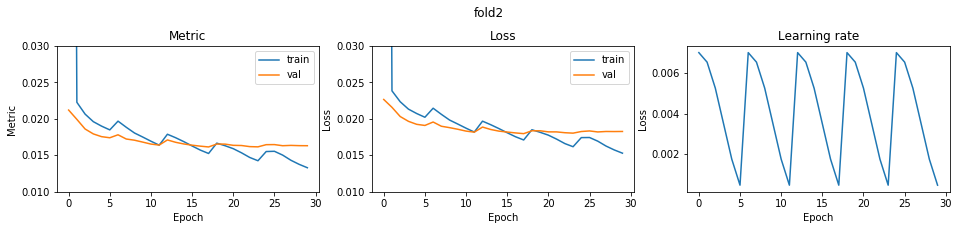

fold 3


epoch1 save best model... 0.021594691621924587
epoch2 save best model... 0.019787595371857862
epoch3 save best model... 0.018729601875117265
epoch4 save best model... 0.018111469544012073
epoch5 save best model... 0.017831458779293746
epoch6 save best model... 0.017608128525825866
epoch9 save best model... 0.01726606152145561
epoch10 save best model... 0.017064349294336756
epoch11 save best model... 0.01687071022995512
epoch12 save best model... 0.016731234122670184
epoch16 save best model... 0.016606616569525966
epoch17 save best model... 0.016465934597227325
epoch18 save best model... 0.016355651285677536
epoch24 save best model... 0.016332981471982116
fold3 score: 0.016332981359168445


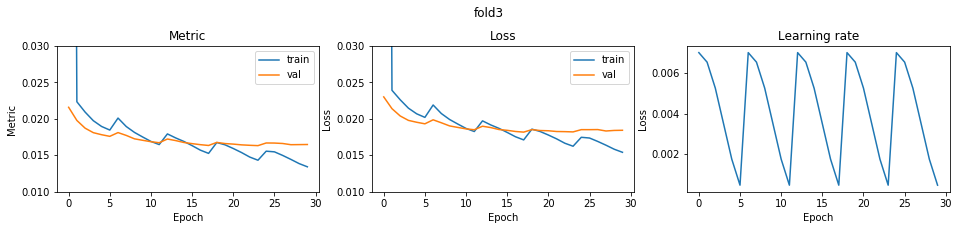

fold 4


epoch1 save best model... 0.02103923326082409
epoch2 save best model... 0.01938047374859622
epoch3 save best model... 0.01841417355568982
epoch4 save best model... 0.017907069582738203
epoch5 save best model... 0.017629984486211676
epoch6 save best model... 0.01740775026491332
epoch9 save best model... 0.0171687768916504
epoch10 save best model... 0.016915218686952272
epoch11 save best model... 0.016655677258289484
epoch12 save best model... 0.01657221872902609
epoch16 save best model... 0.016533199001468532
epoch17 save best model... 0.016382674253407805
epoch18 save best model... 0.01631894500752177
fold4 score: 0.01631894482301102


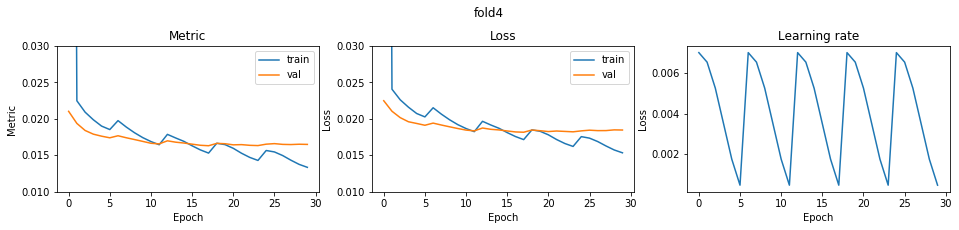

CV score: 0.016250302673562457

optimizer: RangerQH
fold 0


epoch1 save best model... 0.03144193725461026
fold0 score: 0.031441937192957965


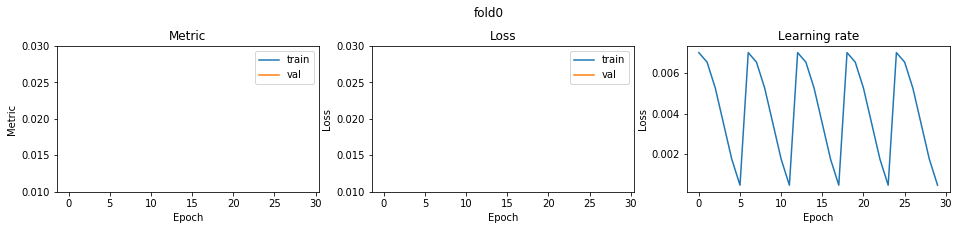

fold 1


epoch1 save best model... 0.031711044312406164
epoch28 save best model... 0.03157652808087213
fold1 score: 0.03157652625811253


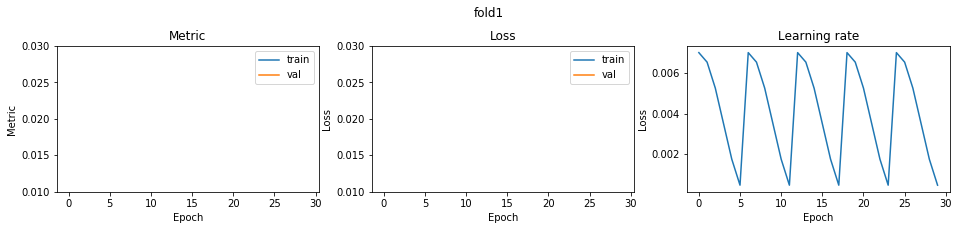

fold 2


epoch1 save best model... 0.031528690853214504
epoch13 save best model... 0.0314114169551004
fold2 score: 0.031411418735677564


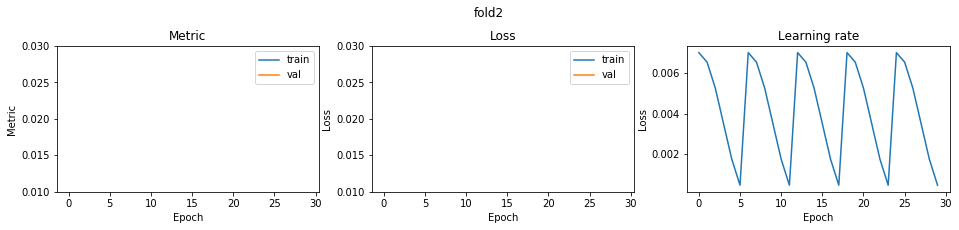

fold 3


epoch1 save best model... 0.03210303753207105
epoch7 save best model... 0.03210231881834787
epoch10 save best model... 0.03195600819886409
epoch15 save best model... 0.03171001233516901
fold3 score: 0.03171001390404341


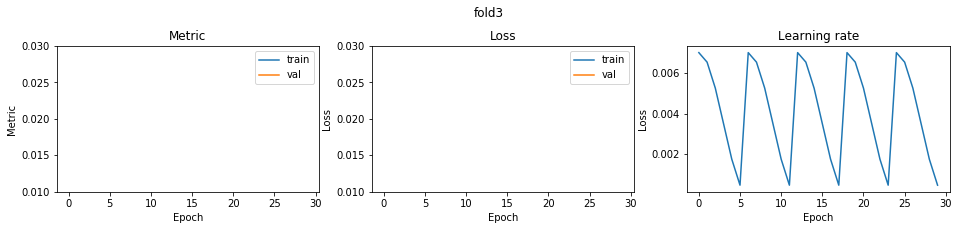

fold 4


epoch1 save best model... 0.0316432331724767
fold4 score: 0.0316432329045352


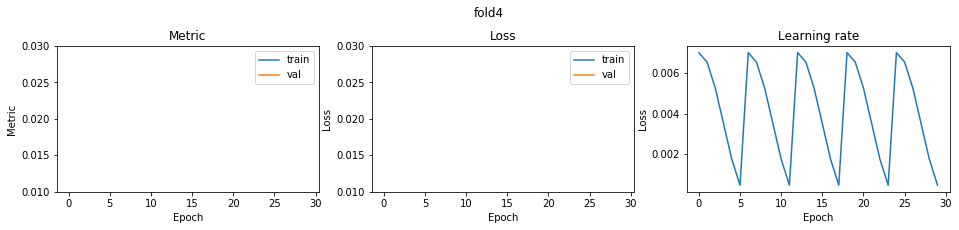

CV score: 0.03155663150831466

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5341030567545011
epoch2 save best model... 0.06512220410931355
epoch3 save best model... 0.031161616657752383
epoch4 save best model... 0.026120094248944372
epoch5 save best model... 0.024973224009257784
epoch6 save best model... 0.024586202271265702
epoch7 save best model... 0.022195391856761892
epoch8 save best model... 0.021281239701804105
epoch9 save best model... 0.020846751922049937
epoch10 save best model... 0.02062942182097864
epoch11 save best model... 0.020564210031325834
epoch13 save best model... 0.020212198783705067
epoch14 save best model... 0.019952499695919914
epoch15 save best model... 0.01978520096824897
epoch16 save best model... 0.019714233420941987
epoch17 save best model... 0.019634055095917816
epoch19 save best model... 0.019425686986815686
epoch20 save best model... 0.019316862389479248
epoch21 save best model... 0.019156479668338913
epoch22 save best model... 0.01909816271725168
epoch23 save best model... 0.019096624025553125
epoch24

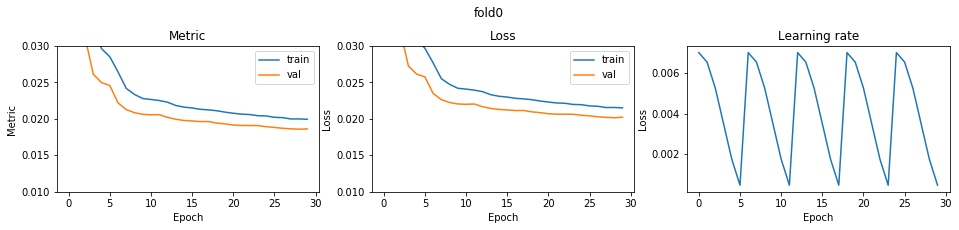

fold 1


epoch1 save best model... 0.5411678660320621
epoch2 save best model... 0.06667161398832715
epoch3 save best model... 0.031283895745890425
epoch4 save best model... 0.026186208798972124
epoch5 save best model... 0.02485518728837619
epoch6 save best model... 0.024595781214370574
epoch7 save best model... 0.022182397468418297
epoch8 save best model... 0.02134704965088872
epoch9 save best model... 0.020924547414290496
epoch10 save best model... 0.020725632516302696
epoch12 save best model... 0.020618804090707904
epoch13 save best model... 0.02029698215234888
epoch14 save best model... 0.020013098059848924
epoch15 save best model... 0.019928393168275164
epoch16 save best model... 0.019794201796654146
epoch17 save best model... 0.019745626770966578
epoch19 save best model... 0.01953458607173042
epoch20 save best model... 0.019457545810467998
epoch21 save best model... 0.019316424348952425
epoch22 save best model... 0.019216400663896557
epoch23 save best model... 0.019196244842385777
epoch24 

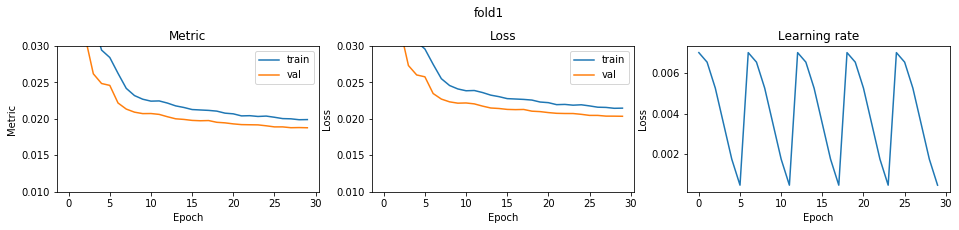

fold 2


epoch1 save best model... 0.5376991072665805
epoch2 save best model... 0.06543909038734697
epoch3 save best model... 0.03139836582280721
epoch4 save best model... 0.02635833640292365
epoch5 save best model... 0.024906029216444393
epoch6 save best model... 0.024659263172523663
epoch7 save best model... 0.0222829871302342
epoch8 save best model... 0.021389607357073005
epoch9 save best model... 0.02103498285242897
epoch10 save best model... 0.02081072029115929
epoch11 save best model... 0.020692811548492583
epoch12 save best model... 0.02066038953644128
epoch13 save best model... 0.02042297158015972
epoch14 save best model... 0.02011887333637002
epoch15 save best model... 0.019983199312790675
epoch16 save best model... 0.01986105089099417
epoch17 save best model... 0.019830539303550172
epoch19 save best model... 0.019592569922821674
epoch20 save best model... 0.019466235163401135
epoch21 save best model... 0.019337130777960513
epoch22 save best model... 0.01922465054461328
epoch23 save be

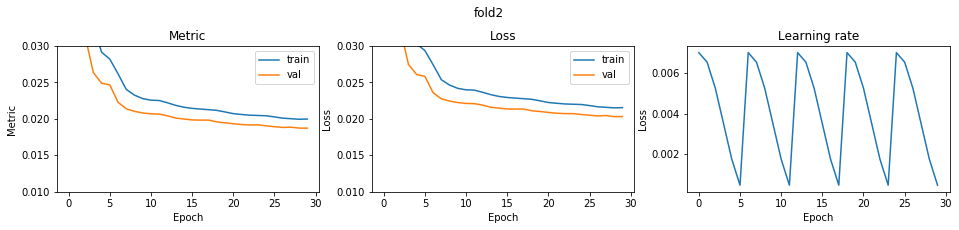

fold 3


epoch1 save best model... 0.5241409454910522
epoch2 save best model... 0.06334417155500426
epoch3 save best model... 0.030854914107429954
epoch4 save best model... 0.02629756784927872
epoch5 save best model... 0.025011667627035078
epoch6 save best model... 0.0245277359945899
epoch7 save best model... 0.022294000592210025
epoch8 save best model... 0.021540098646676893
epoch9 save best model... 0.021126812788104143
epoch10 save best model... 0.020954020854280858
epoch11 save best model... 0.020805864159128117
epoch13 save best model... 0.020534034796771943
epoch14 save best model... 0.020328680833203376
epoch15 save best model... 0.020177430515273015
epoch16 save best model... 0.02003495613906473
epoch17 save best model... 0.020019176204801283
epoch18 save best model... 0.020007320132386576
epoch19 save best model... 0.01979032253553764
epoch20 save best model... 0.019678173714438304
epoch21 save best model... 0.0195146796130204
epoch22 save best model... 0.01945205215738072
epoch23 save

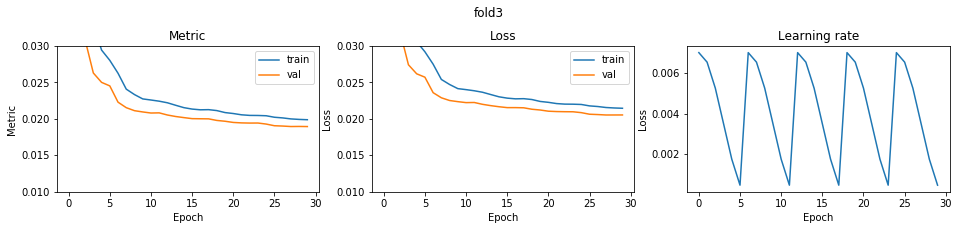

fold 4


epoch1 save best model... 0.53228230055481
epoch2 save best model... 0.06459218702853949
epoch3 save best model... 0.030497183597271153
epoch4 save best model... 0.025821441438278196
epoch5 save best model... 0.024698376613149338
epoch6 save best model... 0.024363232660266423
epoch7 save best model... 0.022070188233989516
epoch8 save best model... 0.021309401523449154
epoch9 save best model... 0.020816872222242974
epoch10 save best model... 0.020583616253115864
epoch11 save best model... 0.020506876312484774
epoch13 save best model... 0.020212349887080237
epoch14 save best model... 0.020027293396396625
epoch15 save best model... 0.01993653406399665
epoch16 save best model... 0.01977718317444205
epoch17 save best model... 0.019732555247215313
epoch19 save best model... 0.019540604730911026
epoch20 save best model... 0.019395422322807117
epoch21 save best model... 0.019275637144108296
epoch22 save best model... 0.019210402220317876
epoch23 save best model... 0.01915323610899117
epoch25 s

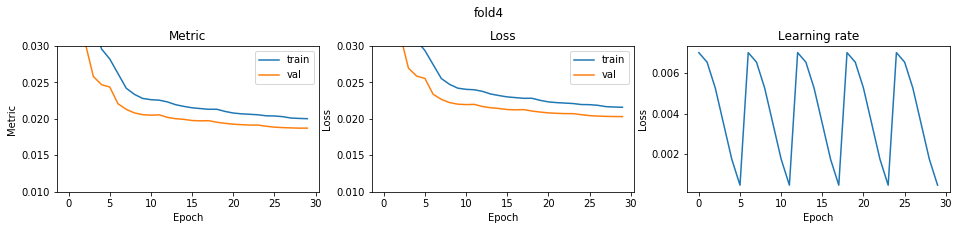

CV score: 0.01875554405019963

optimizer: SWATS
fold 0


epoch1 save best model... 0.031114464329559874
fold0 score: 0.031114464267957675


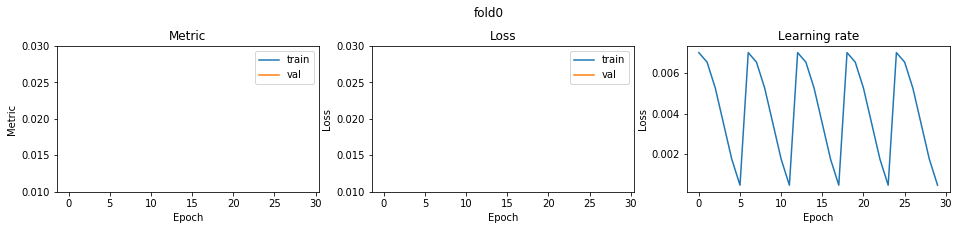

fold 1


epoch1 save best model... 0.03096112182483121
fold1 score: 0.030961121790154873


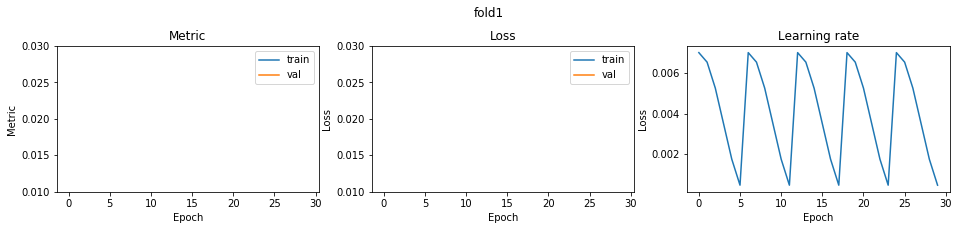

fold 2


epoch1 save best model... 0.031143150124915316
fold2 score: 0.031143150093055013


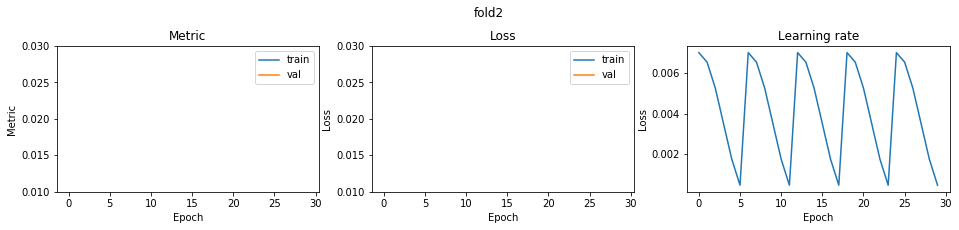

fold 3


epoch1 save best model... 0.031063105838886697
fold3 score: 0.031063105732937368


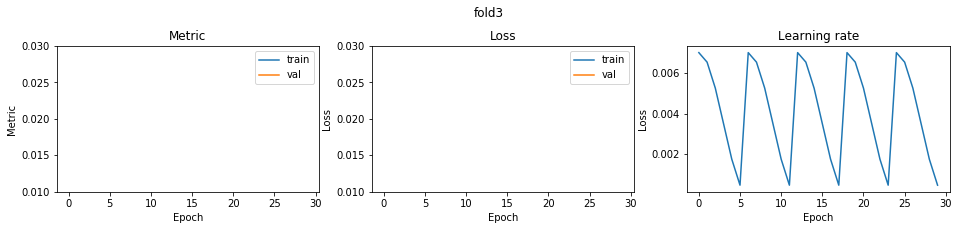

fold 4


epoch1 save best model... 0.03079692870972504
fold4 score: 0.030796928505008914


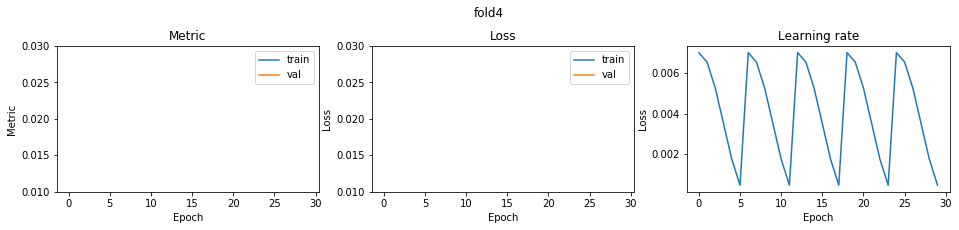

CV score: 0.031015750762544494

optimizer: Yogi
fold 0


epoch1 save best model... 0.031010195856451445
fold0 score: 0.031010195717106344


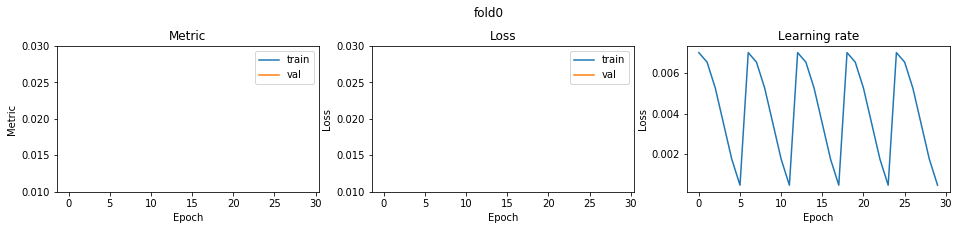

fold 1


epoch1 save best model... 0.03085473847381752
fold1 score: 0.030854738640295715


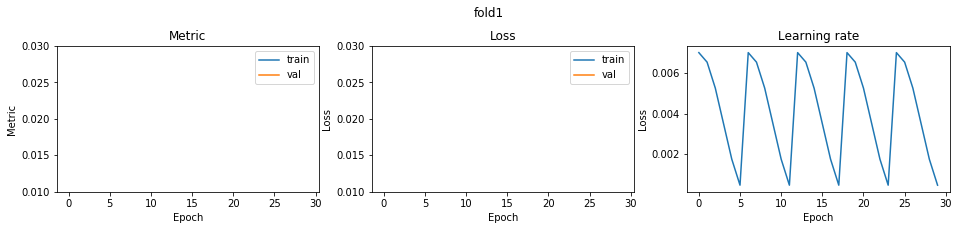

fold 2


epoch1 save best model... 0.031016398730097258
fold2 score: 0.031016398587571783


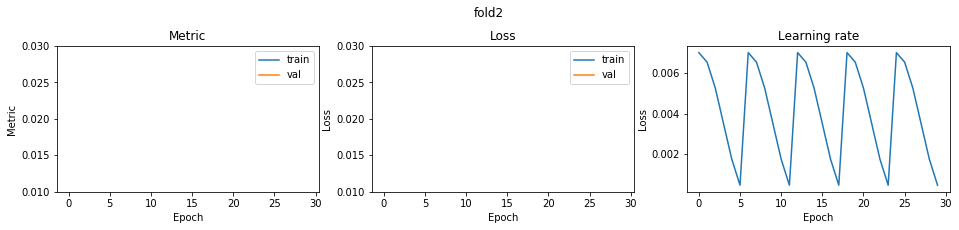

fold 3


epoch1 save best model... 0.031051056270311524
fold3 score: 0.031051056192036304


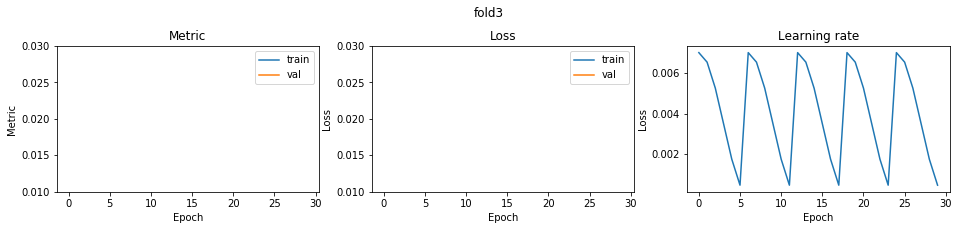

fold 4


epoch1 save best model... 0.030993465447038886
fold4 score: 0.030993465475698277


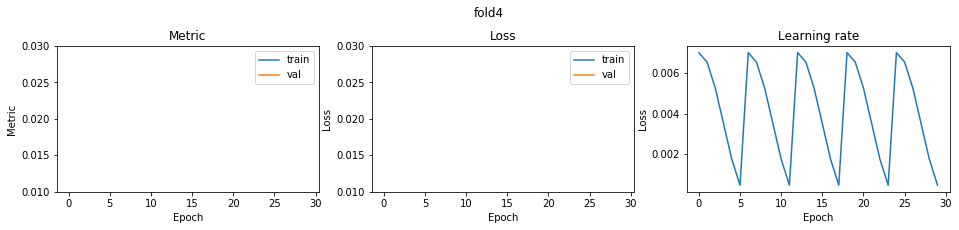

CV score: 0.030985175442526065

optimizer: Adam
fold 0


epoch1 save best model... 0.031946653128518875
epoch4 save best model... 0.031791821148475646
epoch5 save best model... 0.031749756494218774
epoch14 save best model... 0.03174829920902339
fold0 score: 0.03174829967726368


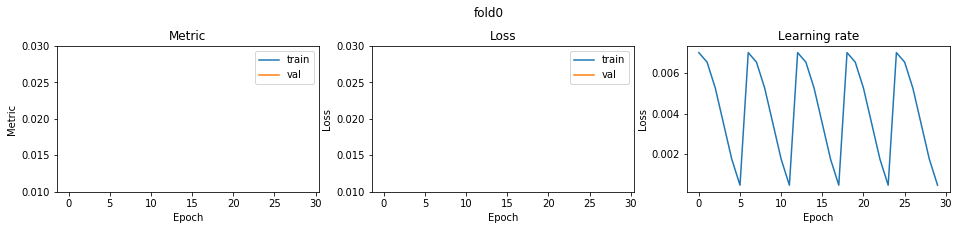

fold 1


epoch1 save best model... 0.031976906657830054
epoch13 save best model... 0.03164838158794377
fold1 score: 0.03164837981210121


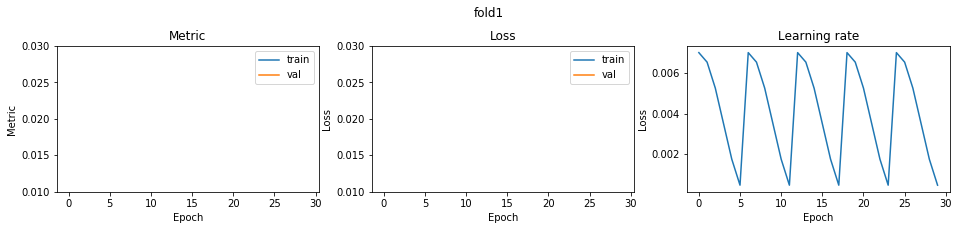

fold 2


epoch1 save best model... 0.031941081815895556
epoch11 save best model... 0.031839049970198534
epoch19 save best model... 0.03168210555585201
fold2 score: 0.031682107656769334


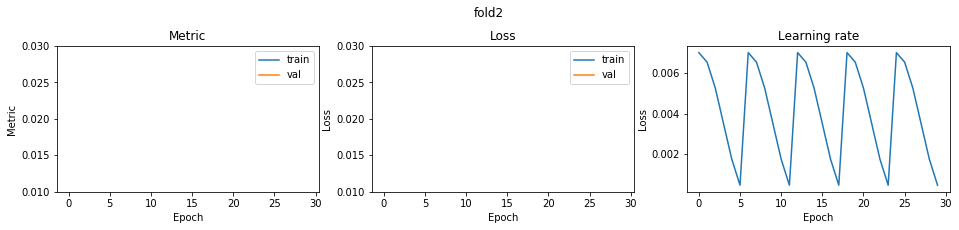

fold 3


epoch1 save best model... 0.03182400782127994
epoch21 save best model... 0.031781861553465046
epoch27 save best model... 0.03151845534868827
fold3 score: 0.03151845654738814


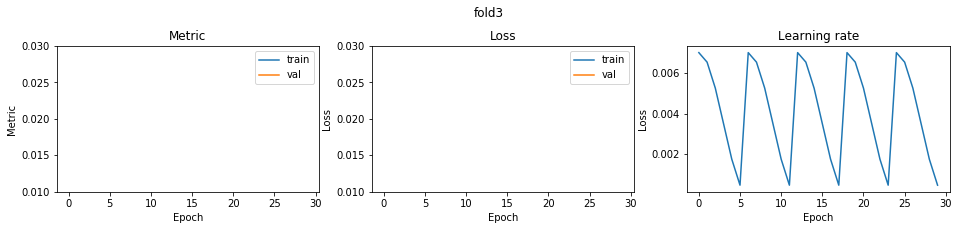

fold 4


epoch1 save best model... 0.03228572195985594
epoch4 save best model... 0.032239450814715825
epoch6 save best model... 0.03210212286722959
epoch7 save best model... 0.0318484262429636
epoch10 save best model... 0.03146843506290592
fold4 score: 0.03146843692133963


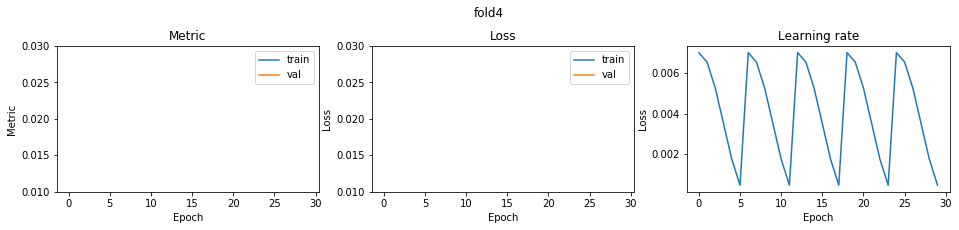

CV score: 0.03161313137469361

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.031227423665633507
fold0 score: 0.031227423649614176


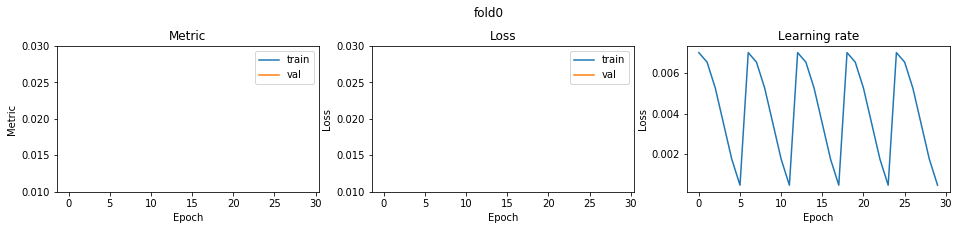

fold 1


epoch1 save best model... 0.03172166035000271
epoch25 save best model... 0.03159229589363496
epoch26 save best model... 0.031557366254491834
fold1 score: 0.03155736384652529


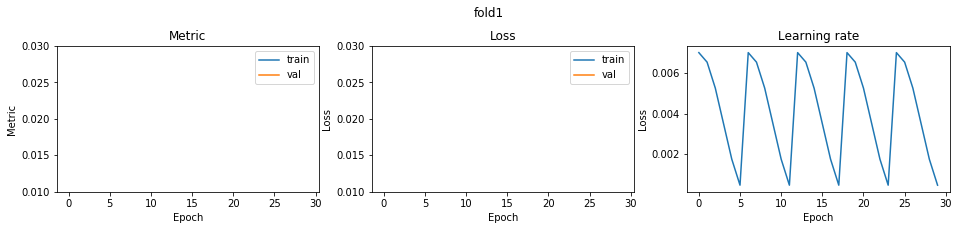

fold 2


epoch1 save best model... 0.031323804877194245
fold2 score: 0.0313238048708741


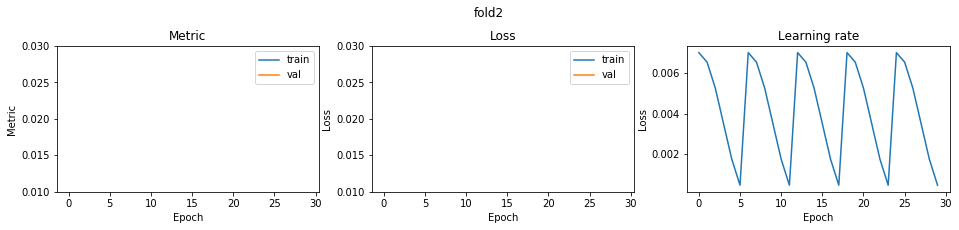

fold 3


epoch1 save best model... 0.03186426096954351
epoch7 save best model... 0.03180485187450547
epoch19 save best model... 0.03163614660959716
fold3 score: 0.03163614707056637


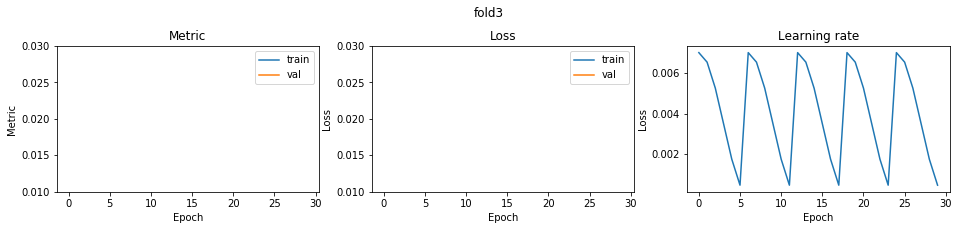

fold 4


epoch1 save best model... 0.03187326012022267
epoch10 save best model... 0.03176027211044535
fold4 score: 0.031760270906241186


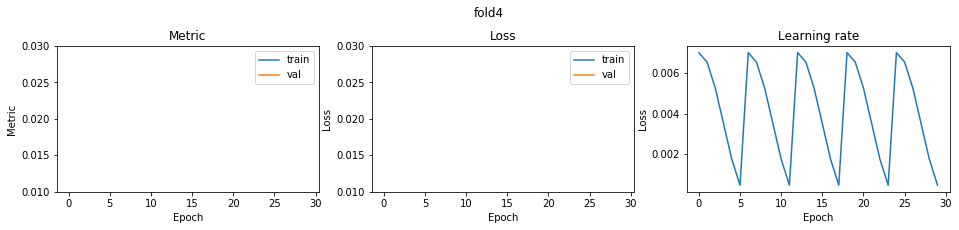

CV score: 0.0315010075742964

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.03395185788291462
epoch2 save best model... 0.03156313874794845
fold0 score: 0.03156313865480341


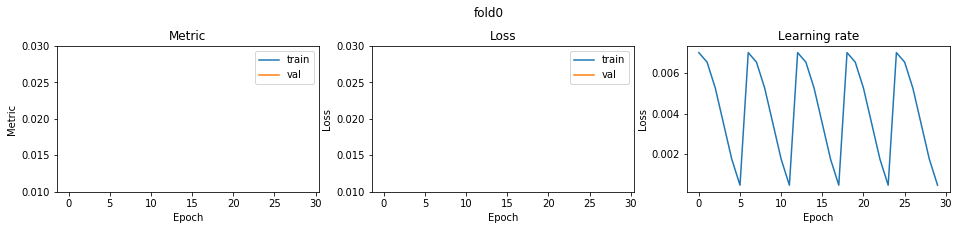

fold 1


epoch1 save best model... 0.03296978914536031
epoch2 save best model... 0.03133840551084227
fold1 score: 0.031338405598431054


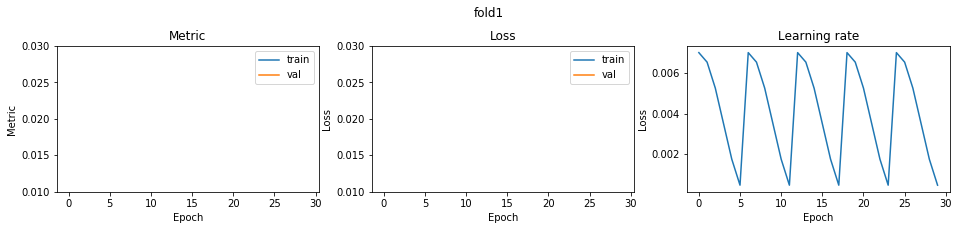

fold 2


epoch1 save best model... 0.03396926895904362
epoch2 save best model... 0.03133699817994198
fold2 score: 0.03133699806260609


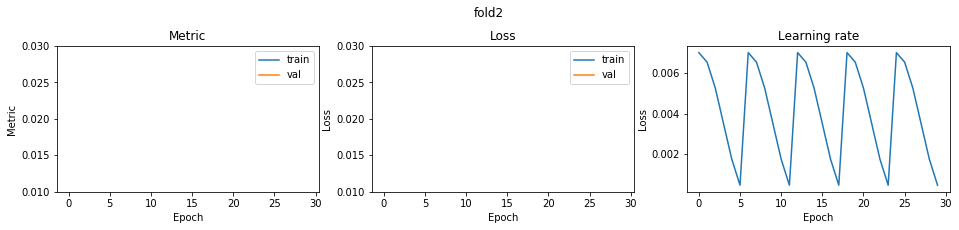

fold 3


epoch1 save best model... 0.03398074476909665
epoch2 save best model... 0.031641444576594444
fold3 score: 0.03164144449975492


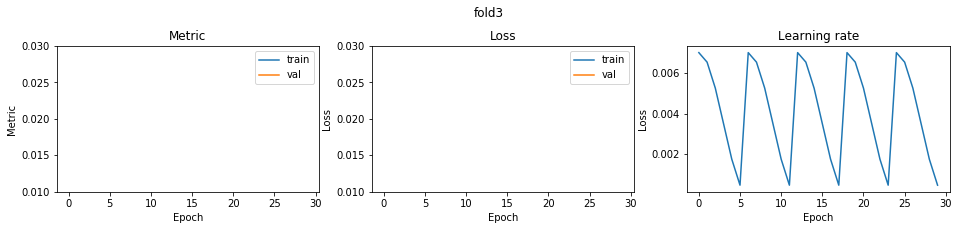

fold 4


epoch1 save best model... 0.0331178108005358
epoch2 save best model... 0.0313991252612959
epoch3 save best model... 0.03134891814414353
fold4 score: 0.031348918187449906


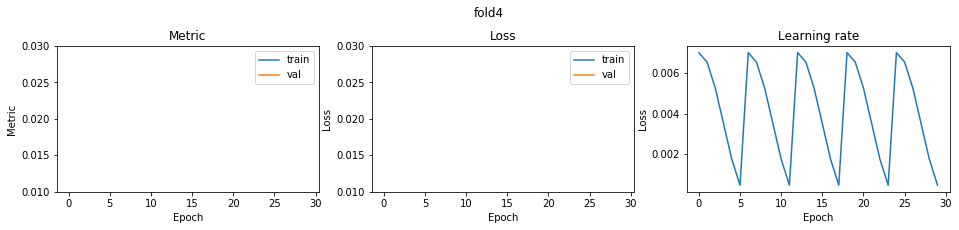

CV score: 0.031445790849266825

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.03136042080446229
epoch2 save best model... 0.030896672515669552
fold0 score: 0.03089667246636053


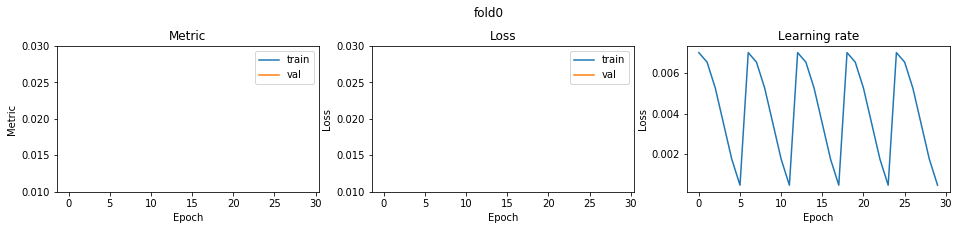

fold 1


epoch1 save best model... 0.03098092830297914
epoch2 save best model... 0.030934126394522653
fold1 score: 0.030934126284608853


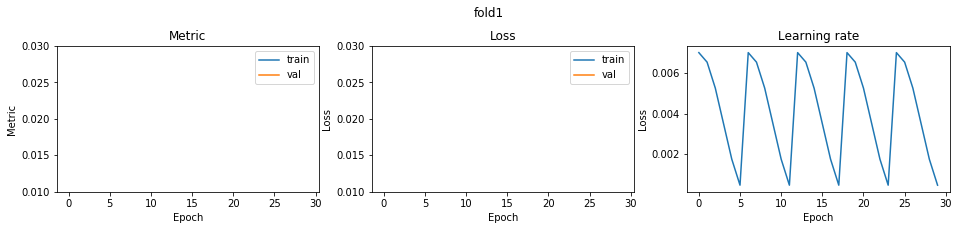

fold 2


epoch1 save best model... 0.03118274891042416
epoch2 save best model... 0.03097384305716267
fold2 score: 0.030973843040751955


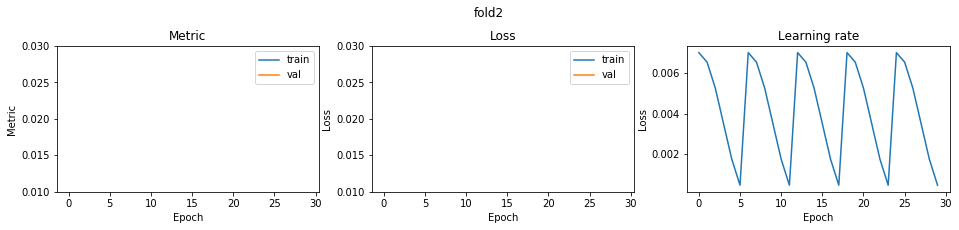

fold 3


epoch1 save best model... 0.03147116116670243
epoch2 save best model... 0.03094655031631096
fold3 score: 0.03094654998425728


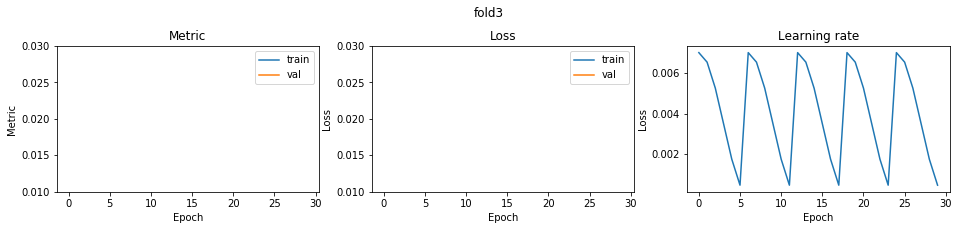

fold 4


epoch1 save best model... 0.031073060101386083
epoch2 save best model... 0.030743805182448552
fold4 score: 0.0307438052337292


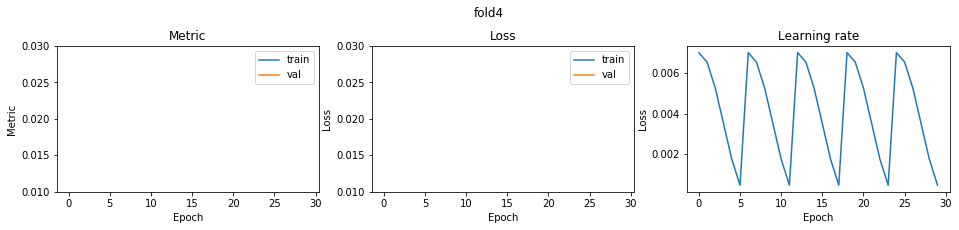

CV score: 0.030898994391438485

optimizer: RangerLars
fold 0


epoch1 save best model... 0.02162349425375054
epoch2 save best model... 0.01977427585266853
epoch3 save best model... 0.018862106141067855
epoch4 save best model... 0.01815388042624013
epoch5 save best model... 0.01784395085889549
epoch6 save best model... 0.01770127211996526
epoch8 save best model... 0.017315880158292406
epoch9 save best model... 0.017001953085455917
epoch10 save best model... 0.016767953598451776
epoch11 save best model... 0.016577867198743962
epoch12 save best model... 0.016498966750971004
epoch15 save best model... 0.016343963201792065
epoch16 save best model... 0.016247966519826365
epoch17 save best model... 0.01616456415801222
epoch18 save best model... 0.016102161305979877
epoch24 save best model... 0.01608436945783386
fold0 score: 0.016084369280461707


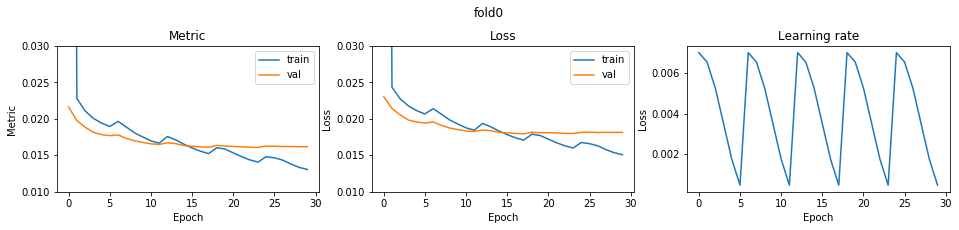

fold 1


epoch1 save best model... 0.02232988107984295
epoch2 save best model... 0.019975426231461497
epoch3 save best model... 0.019127378855167965
epoch4 save best model... 0.018412372341821314
epoch5 save best model... 0.018110303284197632
epoch6 save best model... 0.01797388574733607
epoch7 save best model... 0.017954408334800283
epoch8 save best model... 0.017633387542655022
epoch9 save best model... 0.017223392168259834
epoch10 save best model... 0.01698725262950061
epoch11 save best model... 0.0168583040255319
epoch12 save best model... 0.016739424940442258
epoch15 save best model... 0.01663745004165129
epoch16 save best model... 0.01654390214143907
epoch17 save best model... 0.0164574267320194
epoch18 save best model... 0.016449233513867824
epoch22 save best model... 0.016448547590653822
epoch23 save best model... 0.016402710198177975
epoch24 save best model... 0.016399780224892444
fold1 score: 0.016399780064917126


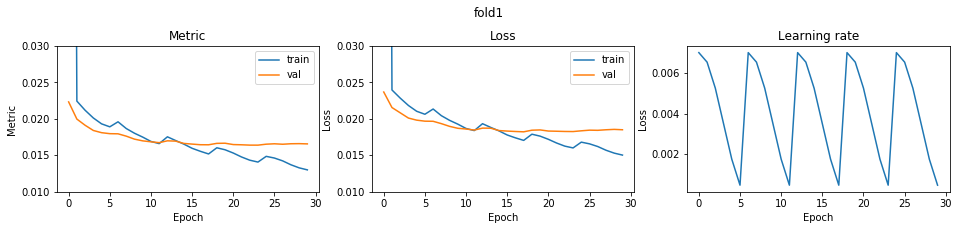

fold 2


epoch1 save best model... 0.021606567678822422
epoch2 save best model... 0.019950768587175875
epoch3 save best model... 0.018967414750127892
epoch4 save best model... 0.018283297629688697
epoch5 save best model... 0.017963440366484874
epoch6 save best model... 0.017789680161486864
epoch8 save best model... 0.01745411014898603
epoch9 save best model... 0.017124130899215186
epoch10 save best model... 0.016874302905812558
epoch11 save best model... 0.01670386602112836
epoch12 save best model... 0.01656893178532874
epoch15 save best model... 0.016439946046861696
epoch16 save best model... 0.0163663409304024
epoch17 save best model... 0.016278704069639684
epoch18 save best model... 0.016204292992268696
epoch24 save best model... 0.016203241564942863
fold2 score: 0.016203241370145897


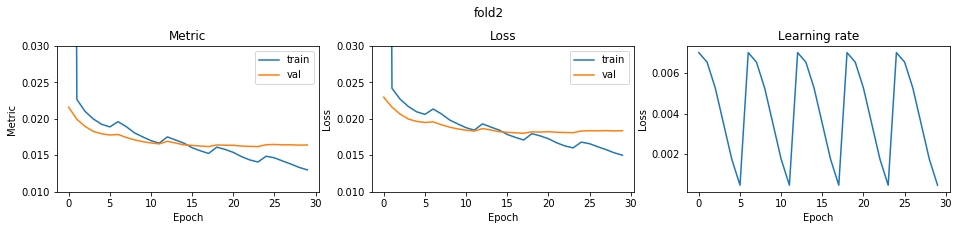

fold 3


epoch1 save best model... 0.0215665011647622
epoch2 save best model... 0.019921853725537488
epoch3 save best model... 0.018857753660809884
epoch4 save best model... 0.018416273476373497
epoch5 save best model... 0.0181476407758637
epoch6 save best model... 0.0179381968657187
epoch8 save best model... 0.017589120940222556
epoch9 save best model... 0.017400231358334253
epoch10 save best model... 0.017095639759882573
epoch11 save best model... 0.01688122308700598
epoch12 save best model... 0.01685458054778788
epoch15 save best model... 0.016721948935885772
epoch16 save best model... 0.016605909371107886
epoch17 save best model... 0.016531654060786435
epoch18 save best model... 0.016505468939271902
epoch23 save best model... 0.016503218830836795
epoch24 save best model... 0.016492977205044453
fold3 score: 0.016492977075989


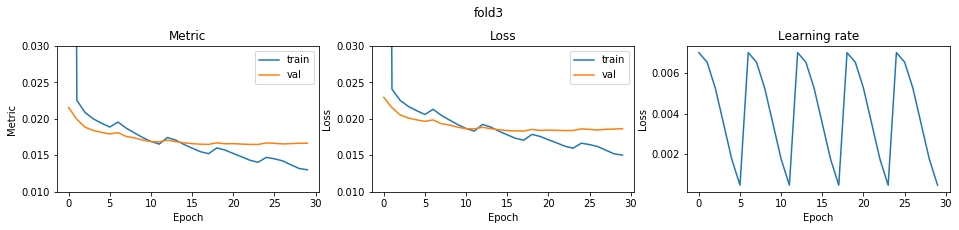

fold 4


epoch1 save best model... 0.021366871800910094
epoch2 save best model... 0.019402411638638154
epoch3 save best model... 0.018629646134522483
epoch4 save best model... 0.01814699936488427
epoch5 save best model... 0.017762451216256022
epoch6 save best model... 0.01766641072903448
epoch7 save best model... 0.017596880238341987
epoch8 save best model... 0.0173016063427735
epoch9 save best model... 0.01705983333068991
epoch10 save best model... 0.01686590060396523
epoch11 save best model... 0.01671478901788219
epoch12 save best model... 0.01663075141091078
epoch15 save best model... 0.016578940018706006
epoch16 save best model... 0.016464676205196115
epoch17 save best model... 0.016396773832686805
epoch18 save best model... 0.01633642549013426
epoch24 save best model... 0.016335664869016695
fold4 score: 0.01633566477818543


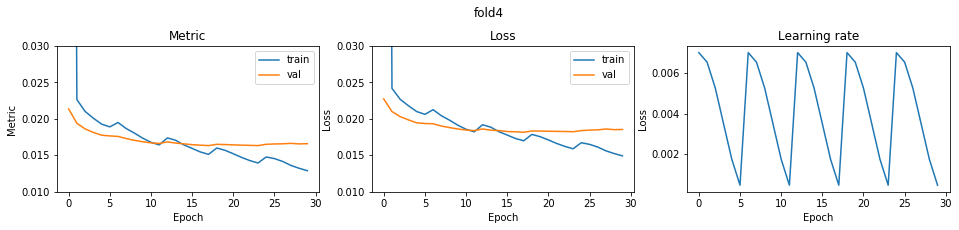

CV score: 0.01630320666846839


In [24]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [25]:
score_dict

{'Adam_CG': 0.03176753944425062,
 'AdamW_CG': 0.016322130833203254,
 'PlainRAdam_CG': 0.021382929175292466,
 'RAdam_CG': 0.016324975494012524,
 'Ranger_CG': 0.016339922808089068,
 'AggMo': 0.030215637362335936,
 'Apollo': 0.49044109976524325,
 'PID': 0.4908990070684152,
 'QHM': 0.49597358557429994,
 'SGDP': 0.4930047287364143,
 'SGDW': 0.1656397151276789,
 'SGD': 0.49823505021660275,
 'AdaBelief': 0.01627984088340205,
 'AdaBound': 0.030444562562590094,
 'AdaMod': 0.01624629803895543,
 'AdamW': 0.016303563862459878,
 'AdamP': 0.01625039101761329,
 'DiffGrad': 0.03161515550573633,
 'Lamb': 0.016373600328965822,
 'NovoGrad': 0.016266442619633503,
 'PlainRAdam': 0.016264234166881764,
 'QHAdam': 0.0315551423674176,
 'RAdam': 0.016256369741497495,
 'Ranger': 0.016250302673562467,
 'RangerQH': 0.031556631508314774,
 'RangerVA': 0.01875554405019954,
 'SWATS': 0.031015750762544432,
 'Yogi': 0.030985175442526113,
 'Adam': 0.03161313137469436,
 'LookaheadAdam': 0.031501007574297205,
 'LookaheadDi

In [26]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

metric
Adam_CG            0.031768
AdamW_CG           0.016322
PlainRAdam_CG      0.021383
RAdam_CG           0.016325
Ranger_CG          0.016340
AggMo              0.030216
Apollo             0.490441
PID                0.490899
QHM                0.495974
SGDP               0.493005
SGDW               0.165640
SGD                0.498235
AdaBelief          0.016280
AdaBound           0.030445
AdaMod             0.016246
AdamW              0.016304
AdamP              0.016250
DiffGrad           0.031615
Lamb               0.016374
NovoGrad           0.016266
PlainRAdam         0.016264
QHAdam             0.031555
RAdam              0.016256
Ranger             0.016250
RangerQH           0.031557
RangerVA           0.018756
SWATS              0.031016
Yogi               0.030985
Adam               0.031613
LookaheadAdam      0.031501
LookaheadDiffGrad  0.031446
LookaheadYogi      0.030899
RangerLars         0.016303

In [27]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                     metric
Adam_CG            0.031768
AdamW_CG           0.016322
PlainRAdam_CG      0.021383
RAdam_CG           0.016325
Ranger_CG          0.016340
AggMo              0.030216
Apollo             0.490441
PID                0.490899
QHM                0.495974
SGDP               0.493005
SGDW               0.165640
SGD                0.498235
AdaBelief          0.016280
AdaBound           0.030445
AdaMod             0.016246
AdamW              0.016304
AdamP              0.016250
DiffGrad           0.031615
Lamb               0.016374
NovoGrad           0.016266
PlainRAdam         0.016264
QHAdam             0.031555
RAdam              0.016256
Ranger             0.016250
RangerQH           0.031557
RangerVA           0.018756
SWATS              0.031016
Yogi               0.030985
Adam               0.031613
LookaheadAdam      0.031501
LookaheadDiffGrad  0.031446
LookaheadYogi      0.030899
RangerLars         0.016303


In [28]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}

In [29]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

metric
AdaMod             0.016246
Ranger             0.016250
AdamP              0.016250
RAdam              0.016256
PlainRAdam         0.016264
NovoGrad           0.016266
AdaBelief          0.016280
RangerLars         0.016303
AdamW              0.016304
AdamW_CG           0.016322
RAdam_CG           0.016325
Ranger_CG          0.016340
Lamb               0.016374
RangerVA           0.018756
PlainRAdam_CG      0.021383
AggMo              0.030216
AdaBound           0.030445
LookaheadYogi      0.030899
Yogi               0.030985
SWATS              0.031016
LookaheadDiffGrad  0.031446
LookaheadAdam      0.031501
QHAdam             0.031555
RangerQH           0.031557
Adam               0.031613
DiffGrad           0.031615
Adam_CG            0.031768
SGDW               0.165640
Apollo             0.490441
PID                0.490899
SGDP               0.493005
QHM                0.495974
SGD                0.498235

In [30]:
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))

                     metric
AdaMod             0.016246
Ranger             0.016250
AdamP              0.016250
RAdam              0.016256
PlainRAdam         0.016264
NovoGrad           0.016266
AdaBelief          0.016280
RangerLars         0.016303
AdamW              0.016304
AdamW_CG           0.016322
RAdam_CG           0.016325
Ranger_CG          0.016340
Lamb               0.016374
RangerVA           0.018756
PlainRAdam_CG      0.021383
AggMo              0.030216
AdaBound           0.030445
LookaheadYogi      0.030899
Yogi               0.030985
SWATS              0.031016
LookaheadDiffGrad  0.031446
LookaheadAdam      0.031501
QHAdam             0.031555
RangerQH           0.031557
Adam               0.031613
DiffGrad           0.031615
Adam_CG            0.031768
SGDW               0.165640
Apollo             0.490441
PID                0.490899
SGDP               0.493005
QHM                0.495974
SGD                0.498235


In [ ]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')